In [25]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import spacy
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud
from deep_translator import GoogleTranslator

In [26]:
file_path = "../../data/adhd-beliefs-pt/adhd-beliefs-pt-prepared.pkl"
df = pd.read_pickle(file_path)
df

datetime        sex      adhd_diagnosis  age  \
0    2025-03-29T18:09:34+01:00  Masculino           Não tenho   21   
1    2025-03-30T16:29:47+02:00   Feminino           Não tenho   22   
2    2025-03-31T12:05:45+02:00   Feminino           Não tenho   53   
3    2025-03-31T12:08:00+02:00   Feminino           Não tenho   23   
4    2025-03-31T12:21:38+02:00   Feminino           Não tenho   20   
..                         ...        ...                 ...  ...   
327  2025-06-13T17:52:30+02:00   Feminino  Sim, diagnosticado   28   
328  2025-06-13T20:39:33+02:00   Feminino           Não tenho   26   
329  2025-06-13T21:18:34+02:00   Feminino           Não tenho   25   
330  2025-06-13T22:05:46+02:00   Feminino  Sim, diagnosticado   24   
331  2025-06-14T03:09:53+02:00   Feminino           Não tenho   30   

        education             occupation                dialect  \
0    Licenciatura              Estudante  Português de Portugal   
1    Licenciatura              Estudante  Português de Portugal   
2    Licenciatura            Trabalhador  Português de Portugal   
3        Mestrado  Trabalhador-estudante  Português de Portugal   
4    Licenciatura              Estudante  Português de Portugal   
..            ...                    ...                    ...   
327  Licenciatura            Trabalhador  Português de Portugal   
328  Licenciatura              Estudante  Português de Portugal   
329  Licenciatura            Trabalhador  Português de Portugal   
330  Licenciatura              Estudante  Português de Portugal   
331      Mestrado            Trabalhador  Português de Portugal   

    forgetting_objects forgetting_responsabilities emotion_management  ...  \
0                    2                           3                  2  ...   
1                    3                           3                  4  ...   
2                    3                           4                  4  ...   
3                    2                           1                  4  ...   
4                    4                           2                  2  ...   
..                 ...                         ...                ...  ...   
327                  4                           4                  4  ...   
328                  3                           3                  4  ...   
329                  2                           4                  3  ...   
330                  3                           2                  4  ...   
331                  2                           4                  3  ...   

    need_fast_talk_interest need_fast_talk_information  \
0                         2                          1   
1                         1                          1   
2                         1                          1   
3                         1                          1   
4                         2                          2   
..                      ...                        ...   
327                       3                          3   
328                       1                          1   
329                       2                          2   
330                       3                          4   
331                       3                          2   

    speaking_before_thinking something_to_add something_to_add_timid  \
0                          1                3                      4   
1                          3                4                      4   
2                          3                3                      1   
3                          4                4                      4   
4                          4                3                      4   
..                       ...              ...                    ...   
327                        3                4                      3   
328                        2                3                      4   
329                        2                2                      3   
330                   

In [27]:
sex_translation = {"Masculino": "Male", "Feminino": "Female"}

adhd_translation = {
    "Sim, diagnosticado": "Diagnosed with ADHD",
    "Estou em processo de diagnóstico": "In process of being diagnosed",
    "Suspeito que tenho": "Suspects having ADHD",
    "Não tenho": "Does not have ADHD",
}

education_translation = {
    "Ensino secundário": "High School",
    "Licenciatura": "Bachelor's degree",
    "Mestrado": "Master's degree",
    "Doutoramento": "PhD",
    "Pós-Graduação": "Postgraduate"
}

occupation_translation = {
    "Estudante": "Student",
    "Trabalhador": "Worker",
    "Trabalhador-estudante": "Working-Student",
    "Desempregado": "Unemployed",
    "Reformado": "Retired"
}

dialect_translation = {
    "Português de Portugal": "European Portuguese",
    "Português do Brasil": "Brazilian Portuguese"
}

In [28]:
for col, translation in [
    ("sex", sex_translation),
    ("adhd_diagnosis", adhd_translation),
    ("education", education_translation),
    ("occupation", occupation_translation),
    ("dialect", dialect_translation),
]:
    if isinstance(df[col].dtype, pd.CategoricalDtype):
        df[col] = df[col].cat.rename_categories(translation)
    else:
        df[col] = df[col].replace(translation)


In [29]:
df.head()

datetime     sex      adhd_diagnosis  age  \
0  2025-03-29T18:09:34+01:00    Male  Does not have ADHD   21   
1  2025-03-30T16:29:47+02:00  Female  Does not have ADHD   22   
2  2025-03-31T12:05:45+02:00  Female  Does not have ADHD   53   
3  2025-03-31T12:08:00+02:00  Female  Does not have ADHD   23   
4  2025-03-31T12:21:38+02:00  Female  Does not have ADHD   20   

           education       occupation              dialect forgetting_objects  \
0  Bachelor's degree          Student  European Portuguese                  2   
1  Bachelor's degree          Student  European Portuguese                  3   
2  Bachelor's degree           Worker  European Portuguese                  3   
3    Master's degree  Working-Student  European Portuguese                  2   
4  Bachelor's degree          Student  European Portuguese                  4   

  forgetting_responsabilities emotion_management  ... need_fast_talk_interest  \
0                           3                  2  ...                       2   
1                           3                  4  ...                       1   
2                           4                  4  ...                       1   
3                           1                  4  ...                       1   
4                           2                  2  ...                       2   

  need_fast_talk_information speaking_before_thinking something_to_add  \
0                          1                        1                3   
1                          1                        3                4   
2                          1                        3                3   
3                          1                        4                4   
4                          2                        4                3   

  something_to_add_timid something_to_add_impulsive  \
0                      4                          2   
1                      4                          2   
2                      1                          2   
3                      4                          2   
4                      4                          3   

                                    special_interest  \
0                                                NaN   
1  Adoro cozinhar, porque sinto que é a forma ide...   
2                                                NaN   
3  Gosto de ver séries porque relatam relações sa...   
4                                                NaN   

                                         diary_entry  \
0                                                NaN   
1  Hoje foi um dia bastante normal, como ontem fi...   
2                                                NaN   
3  Os eventos que considero mais relevantes serão...   
4                                                NaN   

                                 selfdefining_memory  \
0                                                NaN   
1  Quando era mais nova, eu tinha uma professora ...   
2                                                NaN   
3                                          Não tenho   
4                                                NaN   

                                         empty_sheet  
0                                                NaN  
1  Recentemente tenho pensado muito no impacto qu...  
2                                                NaN  
3  Este questionário foi um pouco extenso. Meu au...  
4                                                NaN  

[5 rows x 61 columns]

#### Commonly used dictionaries

In [30]:
column_descriptive_names = {
    "special_interest": "Special Interest",
    "diary_entry": "Diary Entry",
    "selfdefining_memory": "Self-Defining Memory",
    "empty_sheet": "Free Writing",
}

In [31]:
feature_map = {
    "forgetting_objects": "Forgetting Objects",
    "forgetting_responsabilities": "Forgetting Responsibilities",
    "emotion_management": "Emotion Management",
    "emotion_reactions": "Emotion Reactions",
    "emotion_choices": "Emotion Choices",
    "emotion_intense_reaction": "Intense Emotional Reactions",
    "strong_mood_swings": "Strong Mood Swings",
    "control_mood_swings": "Control Over Mood Swings",
    "mood_swings_outside_consequence": "Mood Swings with Consequences",
    "justice_sense": "Sense of Justice",
    "defend_beliefs": "Defending Beliefs",
    "express_writing": "Expressing Through Writing",
    "topic_change_involuntary": "Involuntary Topic Changes",
    "related_topic": "Related Topics",
    "topic_change_unrealized": "Unrealized Topic Changes",
    "parallel_topic": "Parallel Topics",
    "nonlinear_storytelling": "Nonlinear Storytelling",
    "excessive_details": "Excessive Details",
    "forgetting_mid_conversation": "Forgetting Mid-Conversation",
    "talkback": "Talkback",
    "talkback_authority": "Talkback to Authority",
    "talkback_comfortable": "Comfortable Talkback",
    "interrupting_involuntary": "Involuntary Interrupting",
    "excited_opinion": "Excited Opinions",
    "want_interrupt": "Want to Interrupt",
    "want_interrupt_control": "Control Over Interrupting",
    "called_out_expressing": "Called Out for Expressing",
    "called_out_exalted": "Called Out for Being Exalted",
    "called_out_talking_loud": "Called Out for Talking Loudly",
    "called_out_nonlinear_talk": "Called Out for Nonlinear Talk",
    "called_out_nonlinear_write": "Called Out for Nonlinear Writing",
    "called_out_gestures": "Called Out for Gestures",
    "called_out_talking": "Called Out for Talking",
    "detailed_opinions": "Detailed Opinions",
    "detailed_opinions_interest": "Detailed Opinions on Interests",
    "detailed_opinions_people": "Detailed Opinions on People",
    "detailed_opinions_misunderstood": "Misunderstood Detailed Opinions",
    "swearing": "Swearing",
    "swearing_anywhere": "Swearing Anywhere",
    "swearing_casual": "Casual Swearing",
    "talk_fast": "Talking Fast",
    "talk_fast_unrealized": "Unrealized Fast Talking",
    "talk_fast_uncontrolled": "Uncontrolled Fast Talking",
    "called_out_talk_fast": "Called Out for Talking Fast",
    "need_fast_talk_interest": "Need for Fast Talking on Interests",
    "need_fast_talk_information": "Need for Fast Talking on Information",
    "speaking_before_thinking": "Speaking Before Thinking",
    "something_to_add": "Something to Add",
    "something_to_add_timid": "Timid Additions",
    "something_to_add_impulsive": "Impulsive Additions",
}

# Dataset Overview

## Data Distribution

### ADHD Diagnosis Distribution

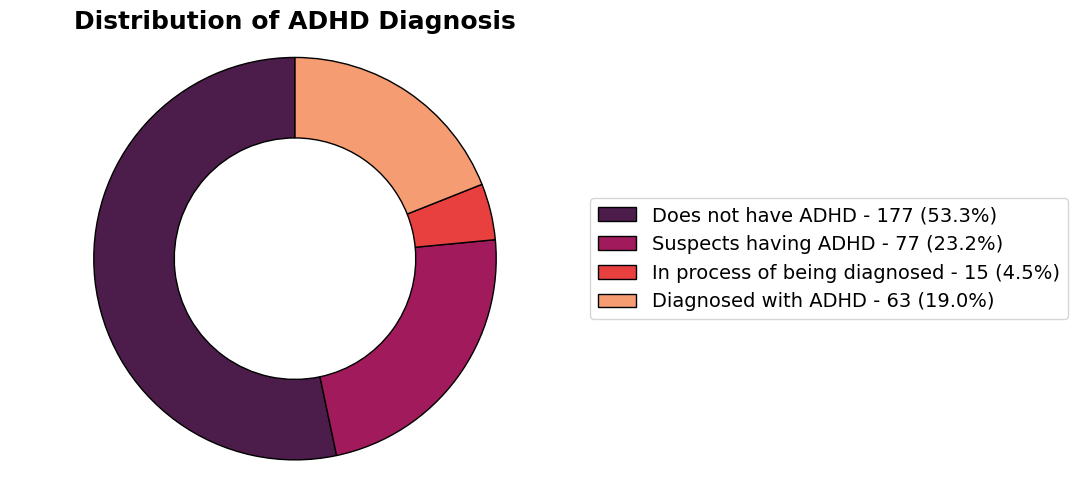

In [8]:
adhd_counts = df["adhd_diagnosis"].value_counts()
adhd_labels = [
    f"{label} - {count} ({count / adhd_counts.sum() * 100:.1f}%)"
    for label, count in adhd_counts.items()
]

# Define the desired order for the categories
adhd_order = [
    "Does not have ADHD",
    "Suspects having ADHD",
    "In process of being diagnosed",
    "Diagnosed with ADHD",
]

# Reorder counts and labels according to adhd_order
adhd_counts_ordered = adhd_counts.reindex(adhd_order)
adhd_labels_ordered = [label for label in adhd_labels if any(label.startswith(cat) for cat in adhd_order)]
# Ensure the order matches adhd_order
adhd_labels_ordered = [next(label for label in adhd_labels if label.startswith(cat)) for cat in adhd_order]

plt.figure(figsize=(6, 5))
wedges, texts = plt.pie(
    adhd_counts_ordered,
    startangle=90,
    colors=sns.color_palette("rocket", len(adhd_counts_ordered)),
    wedgeprops={"edgecolor": "black", "width": 0.4},
)
plt.title("Distribution of ADHD Diagnosis", fontsize=18, fontweight="bold")
plt.axis("equal")
plt.tight_layout()

# Place the legend to the right, vertically centered with the donut
plt.legend(
    wedges,
    adhd_labels_ordered,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=14,
    frameon=True,
)
plt.savefig("data/adhd_diagnosis_distribution_donut.png", dpi=300, bbox_inches="tight")
plt.show()



### Age Profile of the Dataset

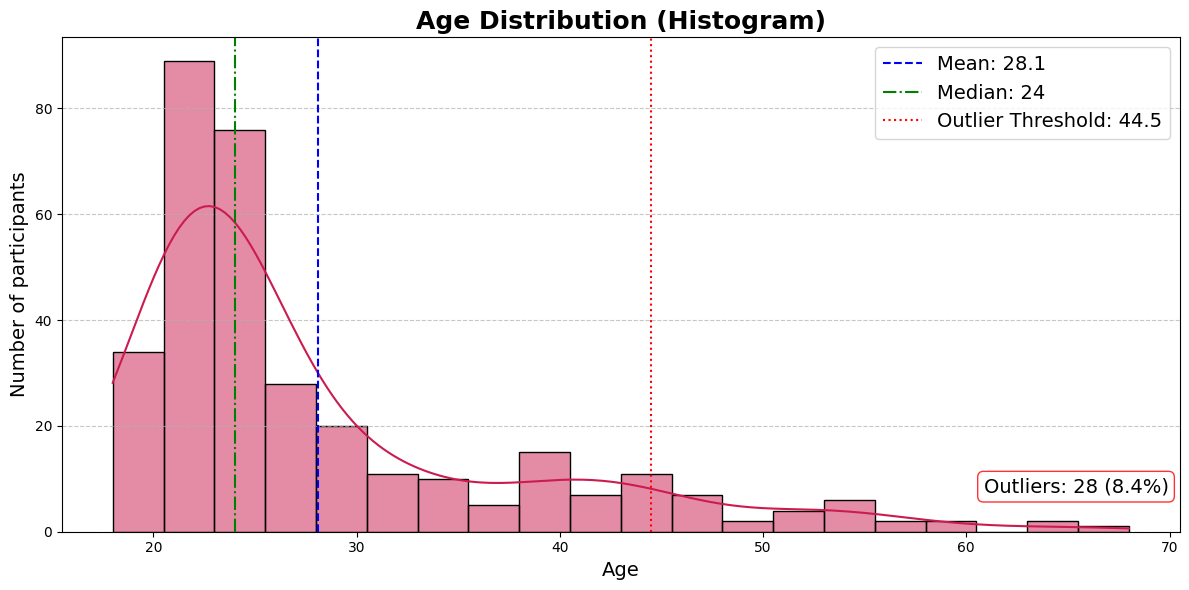

In [9]:
# Age distribution histogram
plt.figure(figsize=(12, 6))
sns.histplot(df["age"], bins=20, kde=True, color=sns.color_palette("rocket", 1)[0])
plt.title("Age Distribution (Histogram)", fontsize=18, fontweight="bold")
plt.xlabel("Age", fontsize=14)
plt.ylabel("Number of participants", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Calculate mean, median, and outlier threshold
q1 = df["age"].quantile(0.25)
q3 = df["age"].quantile(0.75)
iqr = q3 - q1
outlier_threshold = q3 + 1.5 * iqr

mean_age = df["age"].mean()
median_age = df["age"].median()

# Add reference lines
plt.axvline(mean_age, color="blue", linestyle="--", label=f"Mean: {mean_age:.1f}")
plt.axvline(
    median_age, color="green", linestyle="-.", label=f"Median: {median_age:.0f}"
)
plt.axvline(
    outlier_threshold,
    color="red",
    linestyle=":",
    label=f"Outlier Threshold: {outlier_threshold:.1f}",
)

# Identify and count outliers
outliers = df[df["age"] > outlier_threshold]
outlier_count = len(outliers)
outlier_percent = (outlier_count / len(df)) * 100
plt.legend(fontsize=14)

# Add annotation about outliers
plt.annotate(
    f"Outliers: {outlier_count} ({outlier_percent:.1f}%)",
    xy=(0.99, 0.08),
    xycoords="axes fraction",
    fontsize=14,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="red", facecolor="white", alpha=0.8),
    ha="right",
)


plt.tight_layout()
plt.savefig("data/age_distribution_histogram.png", dpi=300, bbox_inches="tight")
plt.show()

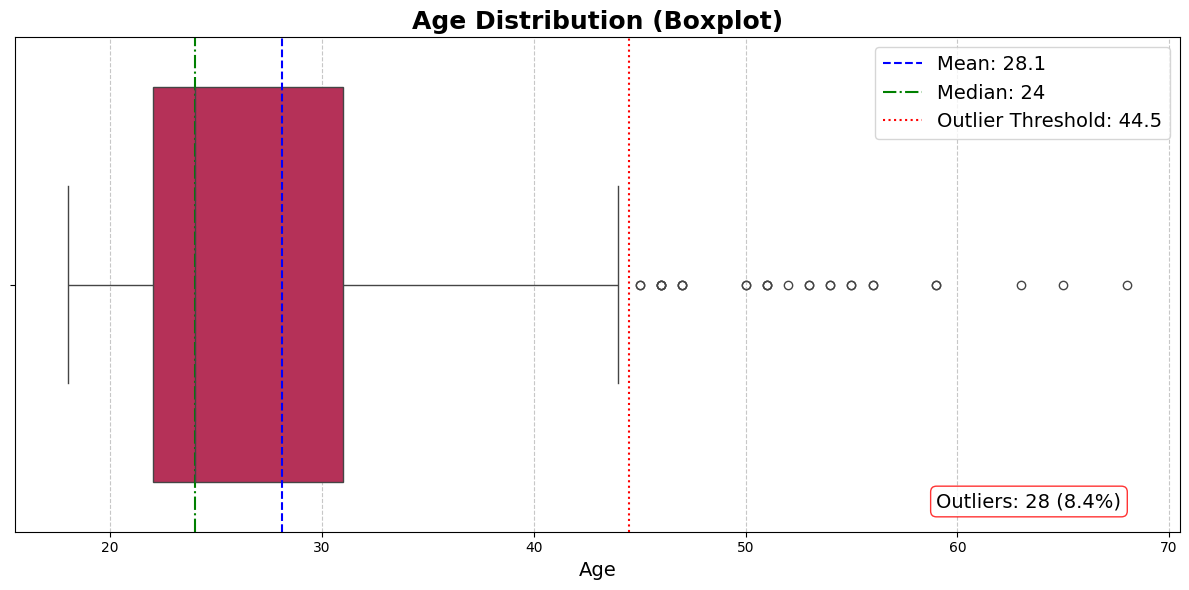

In [10]:
# Age distribution boxplot with outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["age"], color=sns.color_palette("rocket", 1)[0])

# Calculate mean, median, and outlier threshold
q1 = df["age"].quantile(0.25)
q3 = df["age"].quantile(0.75)
iqr = q3 - q1
outlier_threshold = q3 + 1.5 * iqr

mean_age = df["age"].mean()
median_age = df["age"].median()

# Add reference lines
plt.axvline(mean_age, color="blue", linestyle="--", label=f"Mean: {mean_age:.1f}")
plt.axvline(
    median_age, color="green", linestyle="-.", label=f"Median: {median_age:.0f}"
)
plt.axvline(
    outlier_threshold,
    color="red",
    linestyle=":",
    label=f"Outlier Threshold: {outlier_threshold:.1f}",
)

plt.title("Age Distribution (Boxplot)", fontsize=18, fontweight="bold")
plt.xlabel("Age", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.legend(fontsize=14)

# Identify and count outliers
outliers = df[df["age"] > outlier_threshold]
outlier_count = len(outliers)
outlier_percent = (outlier_count / len(df)) * 100

# Add annotation about outliers
plt.annotate(
    f"Outliers: {outlier_count} ({outlier_percent:.1f}%)",
    xy=(0.95, 0.05),
    xycoords="axes fraction",
    fontsize=14,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="red", facecolor="white", alpha=0.8),
    ha="right",
)

plt.tight_layout()
plt.savefig(
    "data/age_distribution_boxplot_with_outliers.png", dpi=300, bbox_inches="tight"
)
plt.show()

### Sociodemographic Characteristics

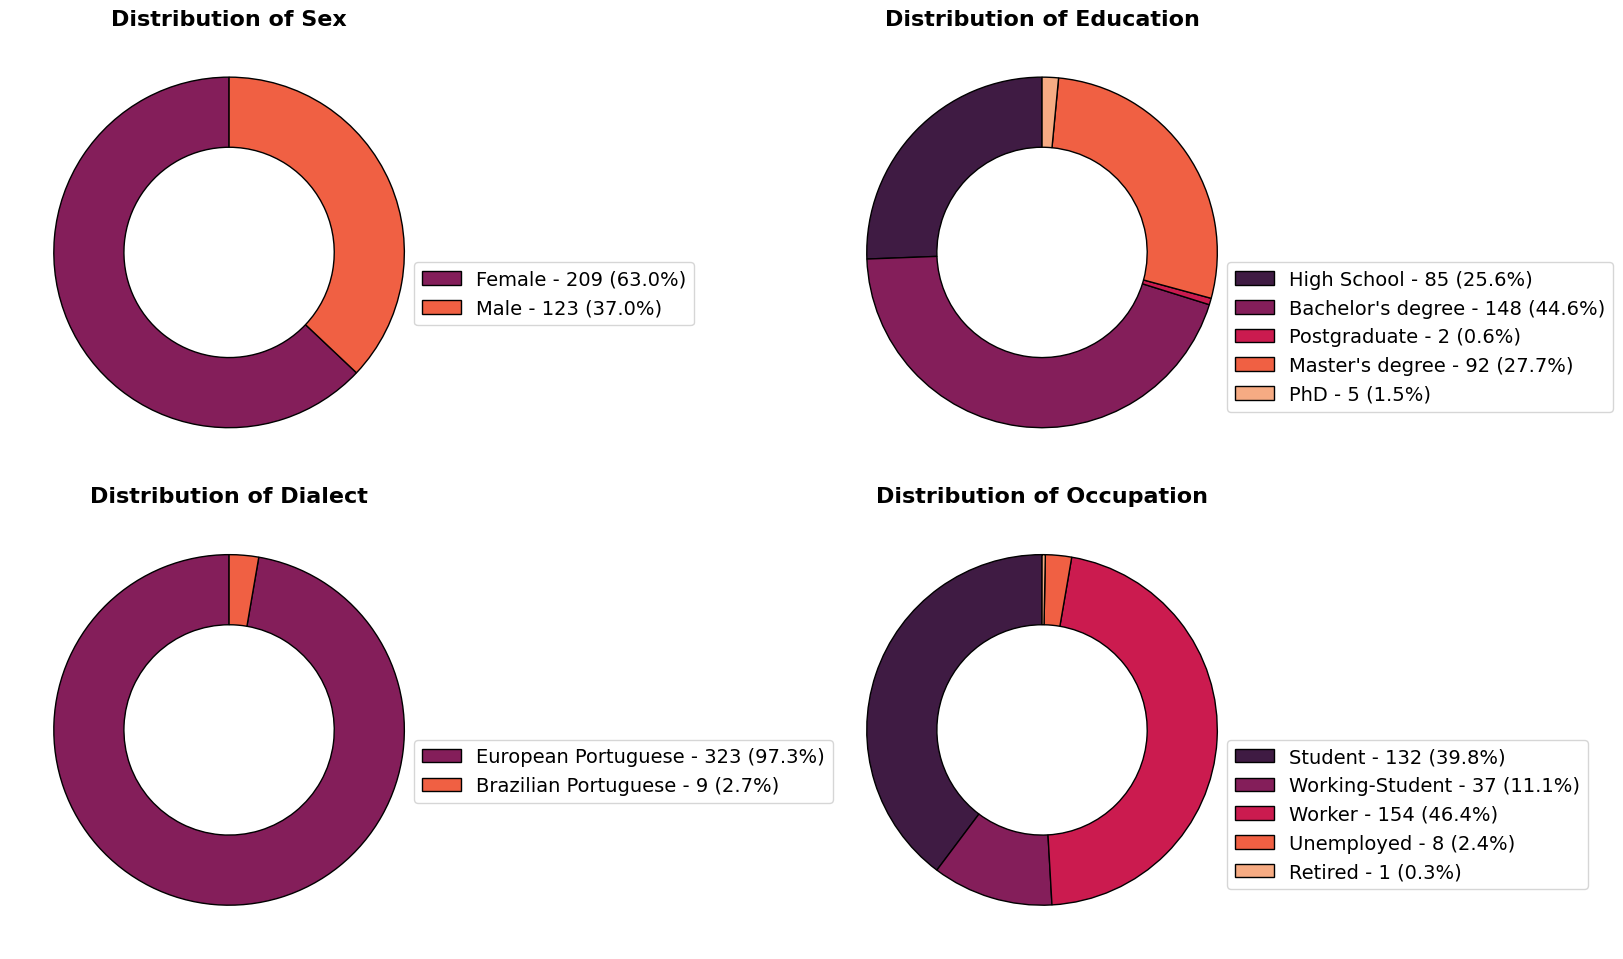

In [11]:
# Define labels for the legends
sex_counts = df["sex"].value_counts()
sex_labels = [
    f"{label} - {count} ({count / sex_counts.sum() * 100:.1f}%)"
    for label, count in sex_counts.items()
]
education_counts = df["education"].value_counts()
education_labels = [
    f"{label} - {count} ({count / education_counts.sum() * 100:.1f}%)"
    for label, count in education_counts.items()
]
occupation_counts = df["occupation"].value_counts()
occupation_labels = [
    f"{label} - {count} ({count / occupation_counts.sum() * 100:.1f}%)"
    for label, count in occupation_counts.items()
]
dialect_counts = df["dialect"].value_counts()
dialect_labels = [
    f"{label} - {count} ({count / dialect_counts.sum() * 100:.1f}%)"
    for label, count in dialect_counts.items()
]

# Define explicit order for education and occupation
education_order = ["High School", "Bachelor's degree", "Postgraduate", "Master's degree", "PhD"]
occupation_order = ["Student", "Working-Student", "Worker", "Unemployed", "Retired"]

# Reindex counts and labels according to the defined order (filtering only present categories)
education_counts = education_counts.reindex([e for e in education_order if e in education_counts.index])
education_labels = [label for e in education_counts.index for label in education_labels if label.startswith(e)]

occupation_counts = occupation_counts.reindex([o for o in occupation_order if o in occupation_counts.index])
occupation_labels = [label for o in occupation_counts.index for label in occupation_labels if label.startswith(o)]

# Create a figure with a uniform grid layout
fig1 = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 2, figure=fig1)

# Donut chart for distribution of sex
ax1 = fig1.add_subplot(gs[0, 0])
ax1.pie(
    sex_counts,
    startangle=90,
    colors=sns.color_palette("rocket", len(sex_counts)),
    wedgeprops={"edgecolor": "black", "width": 0.4},
)
ax1.set_title("Distribution of Sex", fontsize=16, fontweight="bold")
ax1.legend(labels=sex_labels, loc="upper left", bbox_to_anchor=(0.9, 0.5), fontsize=14)

# Donut chart for distribution of education
ax2 = fig1.add_subplot(gs[0, 1])
ax2.pie(
    education_counts,
    startangle=90,
    colors=sns.color_palette("rocket", len(education_counts)),
    wedgeprops={"edgecolor": "black", "width": 0.4},
)
ax2.set_title("Distribution of Education", fontsize=16, fontweight="bold")
ax2.legend(labels=education_labels, loc="upper left", bbox_to_anchor=(0.9, 0.5), fontsize=14)

# Donut chart for distribution of dialect
ax5 = fig1.add_subplot(gs[1, 0])
ax5.pie(
    dialect_counts,
    startangle=90,
    colors=sns.color_palette("rocket", len(dialect_counts)),
    wedgeprops={"edgecolor": "black", "width": 0.4},
)
ax5.set_title("Distribution of Dialect", fontsize=16, fontweight="bold")
ax5.legend(labels=dialect_labels, loc="upper left", bbox_to_anchor=(0.9, 0.5), fontsize=14)

# Donut chart for distribution of occupation
ax4 = fig1.add_subplot(gs[1, 1])
ax4.pie(
    occupation_counts,
    startangle=90,
    colors=sns.color_palette("rocket", len(occupation_counts)),
    wedgeprops={"edgecolor": "black", "width": 0.4},
)
ax4.set_title("Distribution of Occupation", fontsize=16, fontweight="bold")
ax4.legend(labels=occupation_labels, loc="upper left", bbox_to_anchor=(0.9, 0.5), fontsize=14)

plt.tight_layout(rect=[0, 0, 1.2, 0.97])
plt.savefig("data/demographic_data_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

### ADHD Diagnosis Patterns by Sex

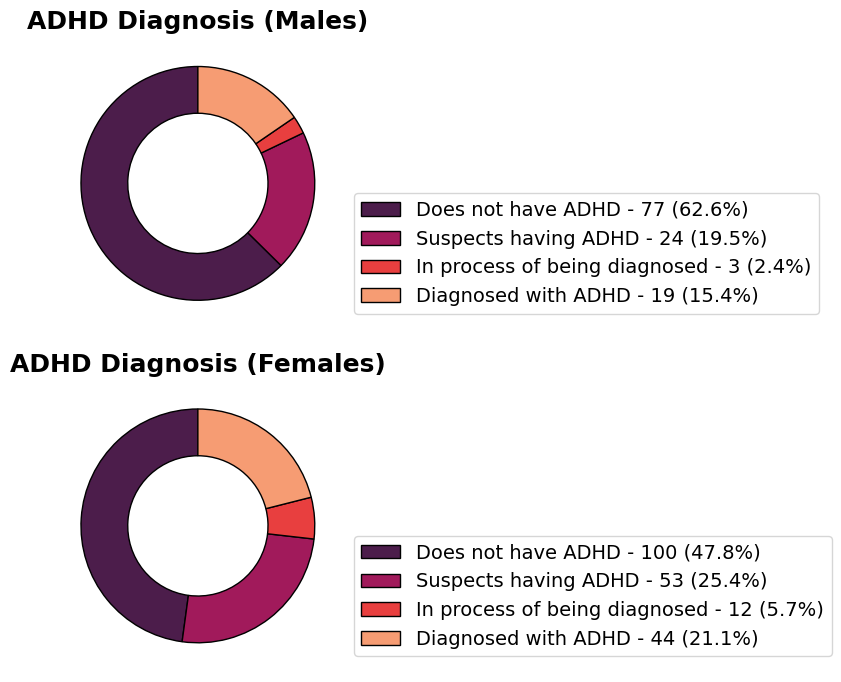

In [12]:
# Define the desired order for ADHD diagnosis categories
adhd_order = [
    "Does not have ADHD",
    "Suspects having ADHD",
    "In process of being diagnosed",
    "Diagnosed with ADHD",
]

# Filter and reorder value_counts to match adhd_order for both sexes
male_data = df[df["sex"] == "Male"]["adhd_diagnosis"].value_counts().reindex(adhd_order, fill_value=0)
female_data = df[df["sex"] == "Female"]["adhd_diagnosis"].value_counts().reindex(adhd_order, fill_value=0)

# Create labels in the same order
male_labels = [
    f"{label} - {count} ({count / male_data.sum() * 100:.1f}%)"
    for label, count in zip(adhd_order, male_data)
]
female_labels = [
    f"{label} - {count} ({count / female_data.sum() * 100:.1f}%)"
    for label, count in zip(adhd_order, female_data)
]

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 7))

# Donut chart for males
axes[0].pie(
    male_data,
    startangle=90,
    colors=sns.color_palette("rocket", len(male_data)),
    wedgeprops={"edgecolor": "black", "width": 0.4},
)
axes[0].set_title("ADHD Diagnosis (Males)", fontsize=18, fontweight="bold")
axes[0].legend(
    labels=male_labels, loc="upper left", bbox_to_anchor=(1, 0.5), fontsize=14
)

# Donut chart for females
axes[1].pie(
    female_data,
    startangle=90,
    colors=sns.color_palette("rocket", len(female_data)),
    wedgeprops={"edgecolor": "black", "width": 0.4},
)
axes[1].set_title("ADHD Diagnosis (Females)", fontsize=18, fontweight="bold")
axes[1].legend(
    labels=female_labels, loc="upper left", bbox_to_anchor=(1, 0.5), fontsize=14
)

plt.tight_layout()
plt.savefig("data/adhd_diagnosis_by_sex.png", dpi=300, bbox_inches="tight")
plt.show()

<Figure size 1400x800 with 0 Axes>

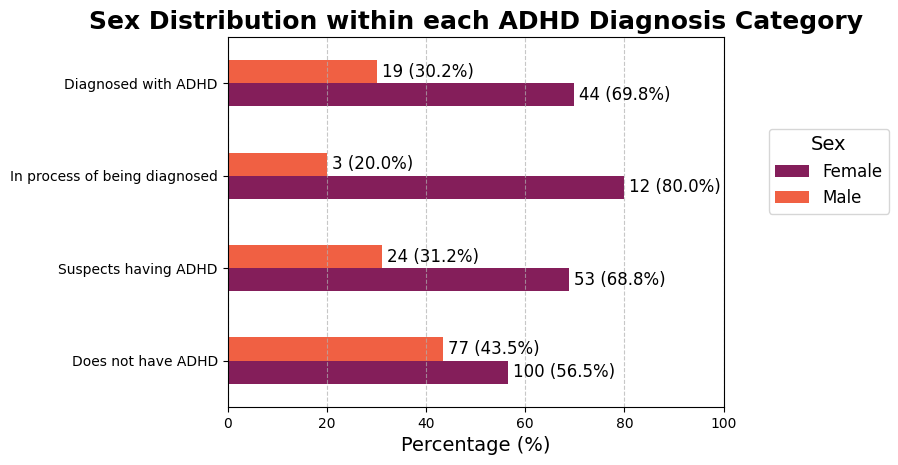

In [13]:
# Calculate the count of each diagnosis by gender
gender_adhd_counts = pd.crosstab(df["adhd_diagnosis"], df["sex"])

# Explicitly define the ADHD diagnosis order
adhd_order = [
    "Does not have ADHD",
    "Suspects having ADHD",
    "In process of being diagnosed",
    "Diagnosed with ADHD",
]

# Reindex to ensure the order
gender_adhd_counts = gender_adhd_counts.reindex(adhd_order)
gender_adhd_percent = (
    gender_adhd_counts.div(gender_adhd_counts.sum(axis=1), axis=0) * 100
)
gender_adhd_percent_df = gender_adhd_percent.round(1)

# Create the plot with horizontal bars
plt.figure(figsize=(14, 8))
ax = gender_adhd_percent_df.plot(kind="barh", color=sns.color_palette("rocket", 2))

# Add title and labels
plt.title(
    "Sex Distribution within each ADHD Diagnosis Category",
    fontsize=18,
    fontweight="bold",
)
plt.ylabel("", fontsize=16)
plt.xlabel("Percentage (%)", fontsize=14)

# Customize grid and rotation of labels
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.yticks(rotation=0)

# Add value labels on each bar with count and percentage
for i, container in enumerate(ax.containers):
    col_name = container.get_label()
    for j, val in enumerate(container):
        count = gender_adhd_counts.iloc[j, i]
        percentage = gender_adhd_percent_df.iloc[j, i]
        ax.text(
            val.get_width() + 1,
            val.get_y() + val.get_height() / 2,
            f"{count} ({percentage:.1f}%)",
            va="center",
            fontsize=12,
        )

plt.legend(
    title="Sex",
    fontsize=12,
    title_fontsize=14,
    loc="lower right",
    bbox_to_anchor=(1.35, 0.5),
)

plt.xlim(0, 100)
plt.savefig(
    "data/sex_distribution_within_adhd_diagnosis.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

### ADHD Diagnosis Patterns by Age

/tmp/ipykernel_24475/1304484606.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


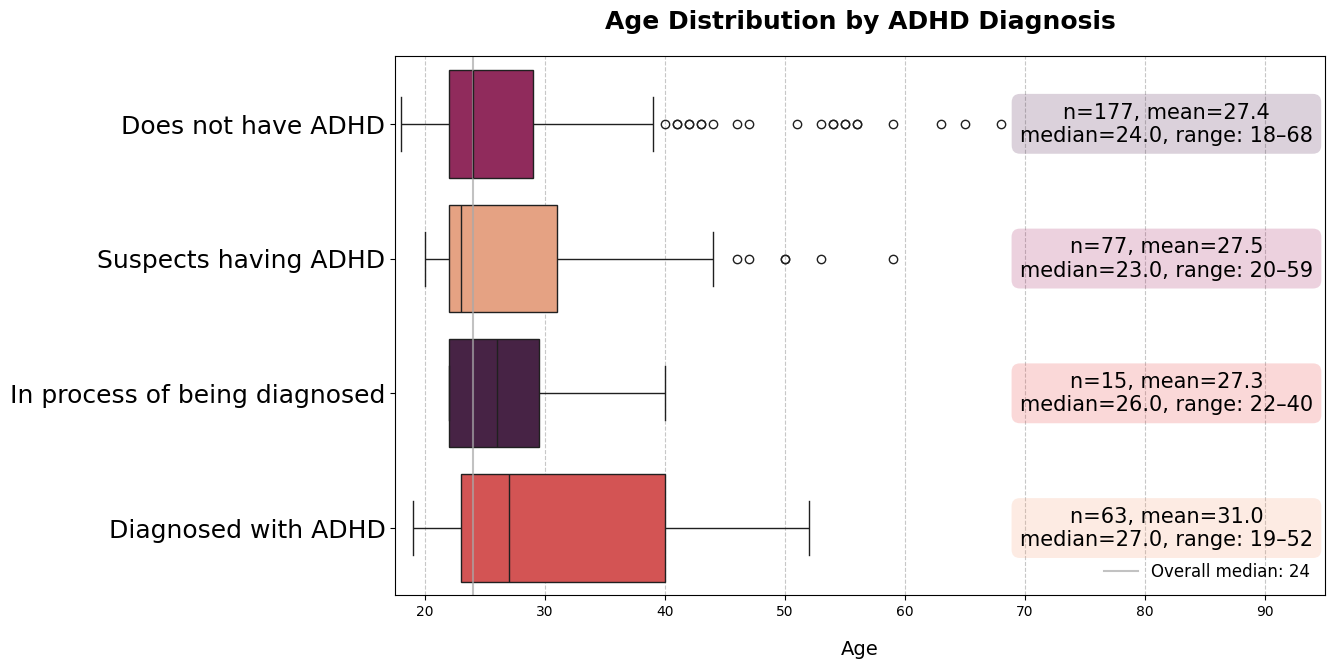

In [14]:
plt.figure(figsize=(12, 7))

# Explicitly define the order to match boxplot categories
order = df["adhd_diagnosis"].unique()

ax = sns.boxplot(
    data=df,
    y="adhd_diagnosis",
    x="age",
    hue="adhd_diagnosis",
    palette="rocket",
    order=order,
)

# Add vertical line for overall median age (remove box around label)
overall_median_age = df["age"].median()
ax.axvline(
    overall_median_age,
    color="darkgray",
    linestyle="-",
    alpha=0.7,
    label=f"Overall median: {overall_median_age:.0f}",
)

# Correctly annotate statistics next to each box (remove edge from annotation box)
for i, diagnosis in enumerate(order):
    y_pos = i
    subset = df[df["adhd_diagnosis"] == diagnosis]["age"]

    annotation = (
        f"n={len(subset)}, mean={subset.mean():.1f}\n"
        f"median={subset.median():.1f}, range: {subset.min()}–{subset.max()}"
    )

    ax.annotate(
        annotation,
        xy=(ax.get_xlim()[1] * 1.16, y_pos),
        xytext=(0, 0),
        textcoords="offset points",
        ha="center",
        va="center",
        fontsize=15,
        bbox=dict(
            boxstyle="round,pad=0.4",
            fc=sns.color_palette("rocket", 4)[i],
            alpha=0.2,
            ec="none"  # Remove edge color
        ),
    )

ax.set_xlim(17.5, 95)
# Customize plot
ax.set_title(
    "Age Distribution by ADHD Diagnosis", fontsize=18, fontweight="bold", pad=20
)
ax.set_xlabel("Age", fontsize=14, labelpad=15)
ax.set_ylabel("")
ax.grid(axis="x", linestyle="--", alpha=0.7)
ax.legend(loc="lower right", fontsize=12, frameon=False)  # Remove legend box
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

# plt.tight_layout()
plt.savefig("data/age_distribution_adhd_diagnosis.png", dpi=300, bbox_inches="tight")
plt.show()


### ADHD Diagnosis Patterns by Education

/tmp/ipykernel_24475/2217183801.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df.pivot_table(


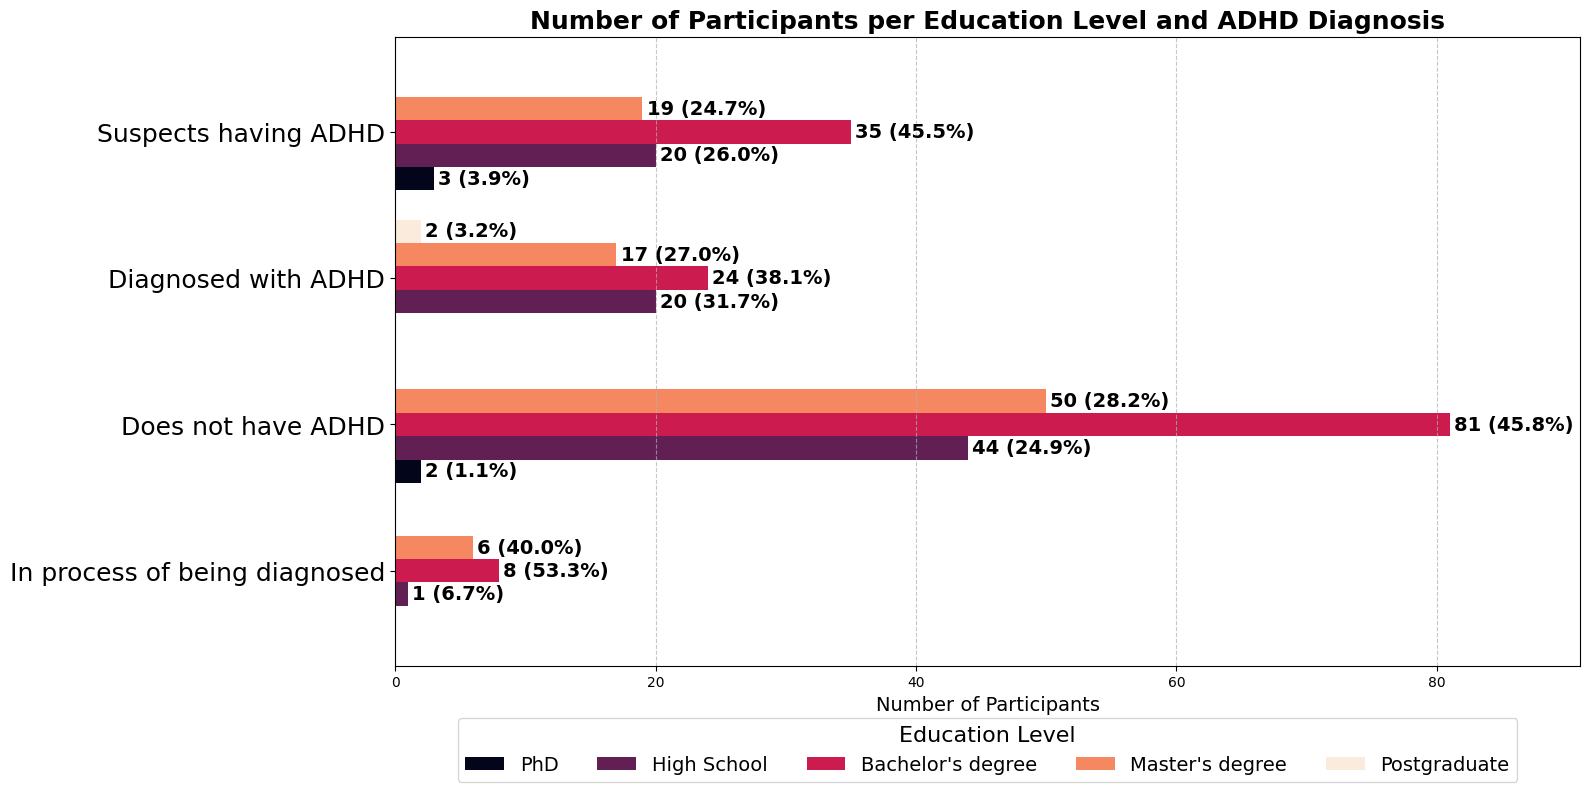

In [15]:
# Create pivot table
pivot_table = df.pivot_table(
    index="adhd_diagnosis",
    columns="education",
    values="age",
    aggfunc="count",
).fillna(0)

# Reorder columns according to education_order for consistency
education_order = ["PhD", "High School", "Bachelor's degree", "Master's degree", "Postgraduate"]
pivot_table = pivot_table[[e for e in education_order if e in pivot_table.columns]]

fig, ax = plt.subplots(figsize=(16, 8))
bars = pivot_table.plot(kind="barh", stacked=False, ax=ax, colormap="rocket", width=0.8)

# Annotate with row‐percentages
for container in ax.containers:
    for bar in container:
        count = bar.get_width()
        if count > 0:
            y = bar.get_y() + bar.get_height() / 2
            row_idx = int(np.round(y))
            diag_label = pivot_table.index[row_idx]
            row_total = pivot_table.loc[diag_label].sum()
            pct = (count / row_total) * 100
            ax.annotate(
                f"{int(count)} ({pct:.1f}%)",
                xy=(count, y),
                xytext=(3, 0),
                textcoords="offset points",
                ha="left",
                va="center",
                fontsize=14,
                fontweight="bold",
            )

# Customizing the plot
ax.set_title(
    "Number of Participants per Education Level and ADHD Diagnosis",
    fontsize=18,
    fontweight="bold",
)
ax.set_ylabel("", fontsize=14)
ax.set_xlabel("Number of Participants", fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
ax.grid(axis="x", linestyle="--", alpha=0.7)
plt.xlim(0, 91)
ax.set_ymargin(0.1)

# Place legend below the plot, horizontal and full width
ax.legend(
    title="Education Level",
    fontsize=14,
    title_fontsize=16,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.2),
    ncol=len(pivot_table.columns),
    frameon=True,
)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

plt.tight_layout()
plt.savefig("data/adhd_diagnosis_education.png", dpi=300, bbox_inches="tight")
plt.show()


### ADHD Diagnosis Patterns by Occupation

/tmp/ipykernel_24475/3079862510.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df.pivot_table(


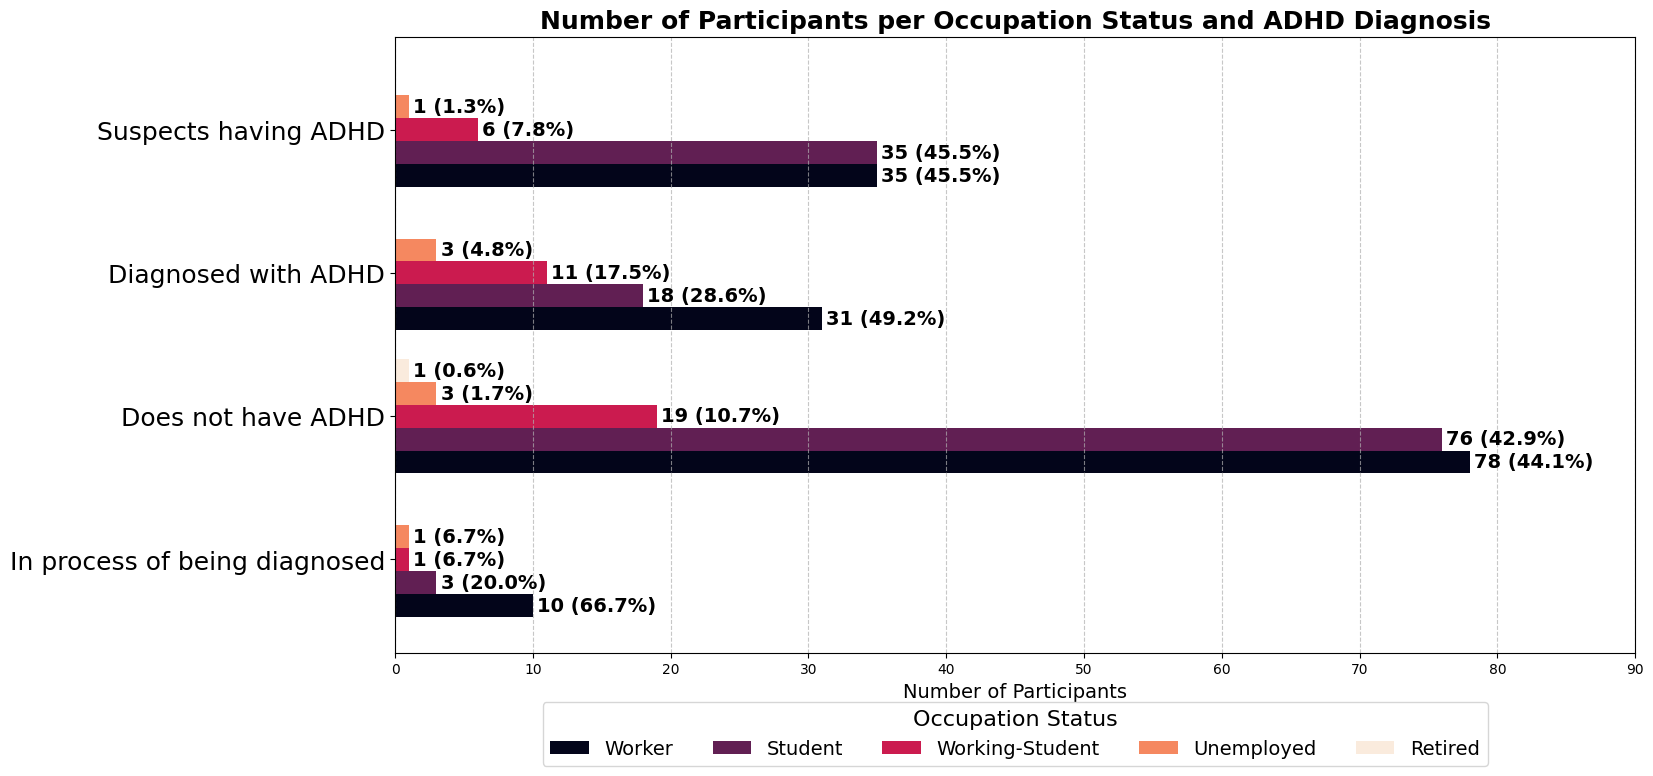

In [16]:
# Create pivot table
pivot_table = df.pivot_table(
    index="adhd_diagnosis",
    columns="occupation",
    values="age",
    aggfunc="count",
).fillna(0)

# Explicitly define the order of occupations
occupation_order = [
    "Worker",
    "Student",
    "Working-Student",
    "Unemployed",
    "Retired",
]
# Filter to only occupations present in the data
occupation_order = [occ for occ in occupation_order if occ in pivot_table.columns]
pivot_table = pivot_table[occupation_order]

# Set parameters
fig, ax = plt.subplots(figsize=(16, 8))
pivot_table.plot(kind="barh", stacked=False, ax=ax, colormap="rocket", width=0.8)

# Annotate with row‐percentages
for container in ax.containers:
    # container corresponds to one occupation level
    for bar in container:
        count = bar.get_width()
        if count > 0:
            # get the vertical center of the bar
            y = bar.get_y() + bar.get_height() / 2
            # map back to the integer row index
            row_idx = int(np.round(y))
            # diagnosis label (e.g. "Yes" or "No")
            diag_label = pivot_table.index[row_idx]
            # total participants for that diagnosis
            row_total = pivot_table.loc[diag_label].sum()
            # compute % within that row
            pct = (count / row_total) * 100
            ax.annotate(
                f"{int(count)} ({pct:.1f}%)",
                xy=(count, y),
                xytext=(3, 0),
                textcoords="offset points",
                ha="left",
                va="center",
                fontsize=14,
                fontweight="bold",
            )

# Customizing the plot
ax.set_title(
    "Number of Participants per Occupation Status and ADHD Diagnosis",
    fontsize=18,
    fontweight="bold",
)
ax.set_ylabel("", fontsize=14)
ax.set_xlabel("Number of Participants", fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
ax.legend(
    title="Occupation Status",
    fontsize=14,
    title_fontsize=16,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.2),
    ncol=len(pivot_table.columns),
    frameon=True,
)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

ax.grid(axis="x", linestyle="--", alpha=0.7)
plt.xlim(0, 90)

# Adding spacing between groups
ax.set_ymargin(0.1)

# plt.tight_layout()
plt.savefig("data/adhd_diagnosis_occupation.png", dpi=300, bbox_inches="tight")
plt.show()

### Engagement with Open-Ended Prompts

/tmp/ipykernel_24475/3177491235.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("adhd_diagnosis")[column]
/tmp/ipykernel_24475/3177491235.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_per_diagnosis = df.groupby("adhd_diagnosis").size().reset_index(name="total")
/tmp/ipykernel_24475/3177491235.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("adhd_diagnosis")[column]
/tmp/ipykerne

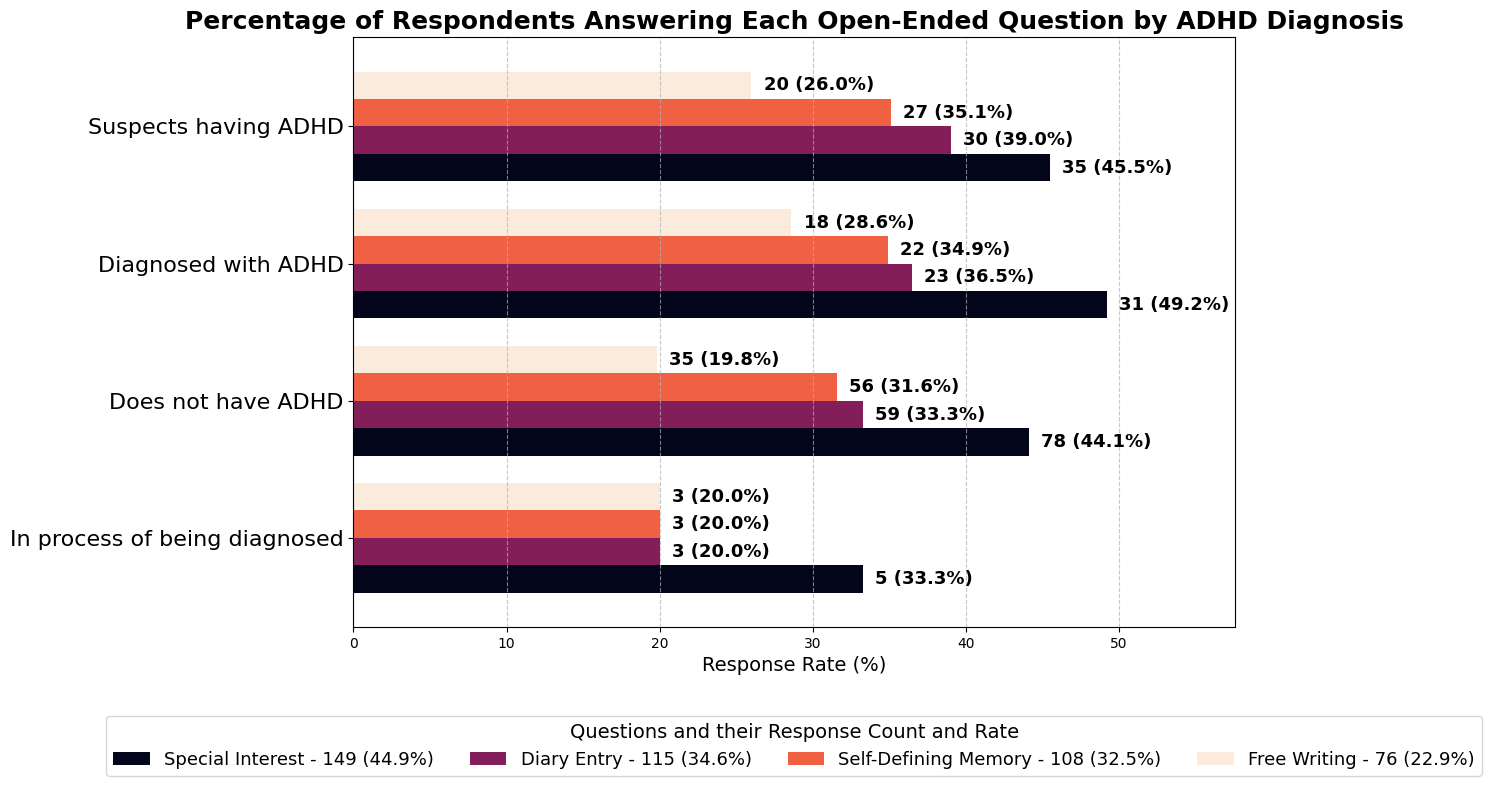

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Count non‐empty entries (unchanged)
def count_non_empty_entries(df, column):
    counts = (
        df.groupby("adhd_diagnosis")[column]
        .apply(lambda x: x.notna().sum())
        .reset_index(name="count")
    )
    total_per_diagnosis = df.groupby("adhd_diagnosis").size().reset_index(name="total")
    result = pd.merge(counts, total_per_diagnosis, on="adhd_diagnosis")
    result["percentage"] = (result["count"] / result["total"] * 100).round(1)
    return result

# 2. Build response_data as before
response_data = pd.DataFrame()
for column, desc in column_descriptive_names.items():
    data = count_non_empty_entries(df, column)
    data["question_type"] = desc
    response_data = pd.concat([response_data, data], ignore_index=True)

# Compute overall counts per question type
overall_counts = {}
total_rows = len(df)
for column, desc in column_descriptive_names.items():
    overall_counts[desc] = df[column].notna().sum()

# Compute overall percentages as before
overall_totals = {
    desc: round(overall_counts[desc] / total_rows * 100, 1)
    for desc in overall_counts
}

# 4. Pivot for plotting
pivot_data = response_data.pivot(
    index="adhd_diagnosis",
    columns="question_type",
    values="percentage"
).reset_index()

# 5. Plot horizontal bars
ax = pivot_data.plot(
    x="adhd_diagnosis",
    y=list(column_descriptive_names.values()),
    kind="barh",
    figsize=(14, 8),
    width=0.8,
    colormap="rocket",
)

# 6. Customize axes and grid
plt.title("Response Rate by Question Type and ADHD Diagnosis", fontsize=18, fontweight="bold")
plt.ylabel("", fontsize=14)
plt.xlabel("Response Rate (%)", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.yticks(rotation=0, fontsize=16)

# 7. Annotate each bar
for i, container in enumerate(ax.containers):
    question_type = list(column_descriptive_names.values())[i]
    for j, bar in enumerate(container):
        diagnosis = pivot_data.iloc[j]["adhd_diagnosis"]
        data_row = response_data[
            (response_data["adhd_diagnosis"] == diagnosis) &
            (response_data["question_type"] == question_type)
        ]
        if not data_row.empty:
            count = int(data_row["count"].values[0])
            pct = data_row["percentage"].values[0]
            ax.text(
                bar.get_width() + .8,
                bar.get_y() + bar.get_height() / 2,
                f"{count} ({pct:.1f}%)",
                va="center",
                ha="left",
                fontsize=13,
                fontweight="bold"
            )

# 8. Extend x‐axis for annotations
x_max = pivot_data.drop(columns="adhd_diagnosis").values.max()
ax.set_xlim(0, x_max * 1.17)

# 9. Build custom legend labels with overall totals
handles, labels = ax.get_legend_handles_labels()
new_labels = [
    f"{label} - {overall_counts[label]} ({overall_totals[label]:.1f}%)"
    for label in labels
]

# 10. Draw the legend horizontally to the right
plt.title(
    "Percentage of Respondents Answering Each Open-Ended Question by ADHD Diagnosis",
    fontsize=18,
    fontweight="bold"
)
ax.legend(
    handles,
    new_labels,
    title="Questions and their Response Count and Rate",
    title_fontsize=14,
    fontsize=13,
    loc="upper center",               # anchor point of legend
    bbox_to_anchor=(0.5, -0.15),      # (x, y) in axes fraction: .5=centered, negative y to go below
    ncol=len(new_labels),             # one column per question for a single row
    frameon=True,
    borderaxespad=0.0,
)

plt.tight_layout()
plt.savefig("data/response_rate_by_question_type.png",
            dpi=300, bbox_inches="tight")
plt.show()

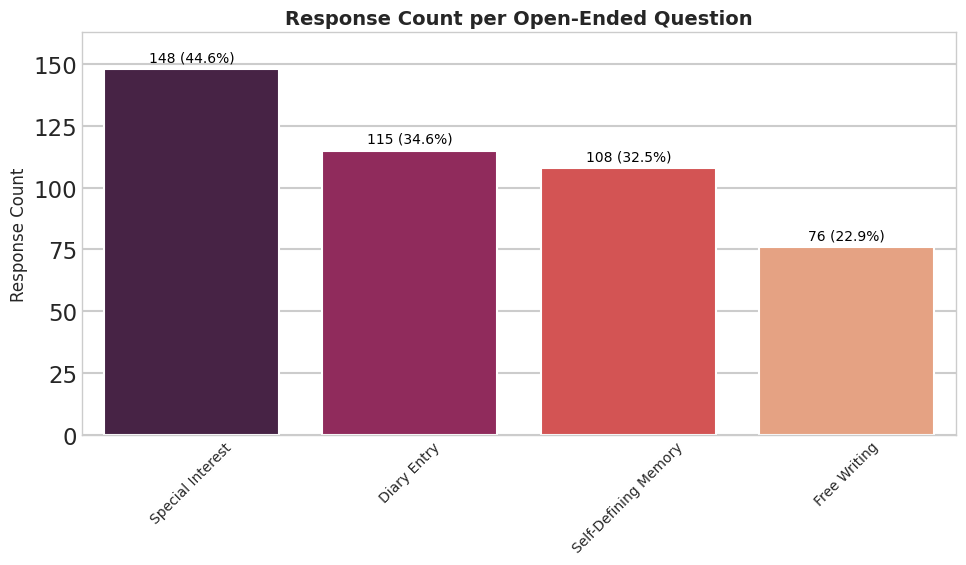

In [32]:
# Calculate the count of missing values for the selected columns
# Count non-empty, non-space-only responses for each open-ended question
response_count = df[["special_interest", "diary_entry", "selfdefining_memory", "empty_sheet"]].apply(
    lambda col: col.dropna().apply(lambda x: bool(str(x).strip())).sum()
)
response_rate = (response_count / len(df)) * 100

# Replace variable names with descriptive text
response_count.index = response_count.index.map(column_descriptive_names)
response_rate.index = response_rate.index.map(column_descriptive_names)

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=response_count.index,
    y=response_count.values,
    hue=response_count.index,
    palette="rocket",
)

# Add value and percentage annotations on top of the bars
for i, (value, percentage) in enumerate(
    zip(response_count.values, response_rate.values)
):
    ax.text(
        i,
        value + 2,
        f"{value} ({percentage:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=10,
        color="black",
    )

# Adjust the y-axis limit
ax.set_ylim(0, response_count.max() + 15)

# Add meaningful labels and title
plt.title("Response Count per Open-Ended Question", fontsize=14, fontweight="bold")
plt.xlabel("", fontsize=12)
plt.ylabel("Response Count", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.savefig("data/response_rate.png", dpi=300, bbox_inches="tight")
plt.show()

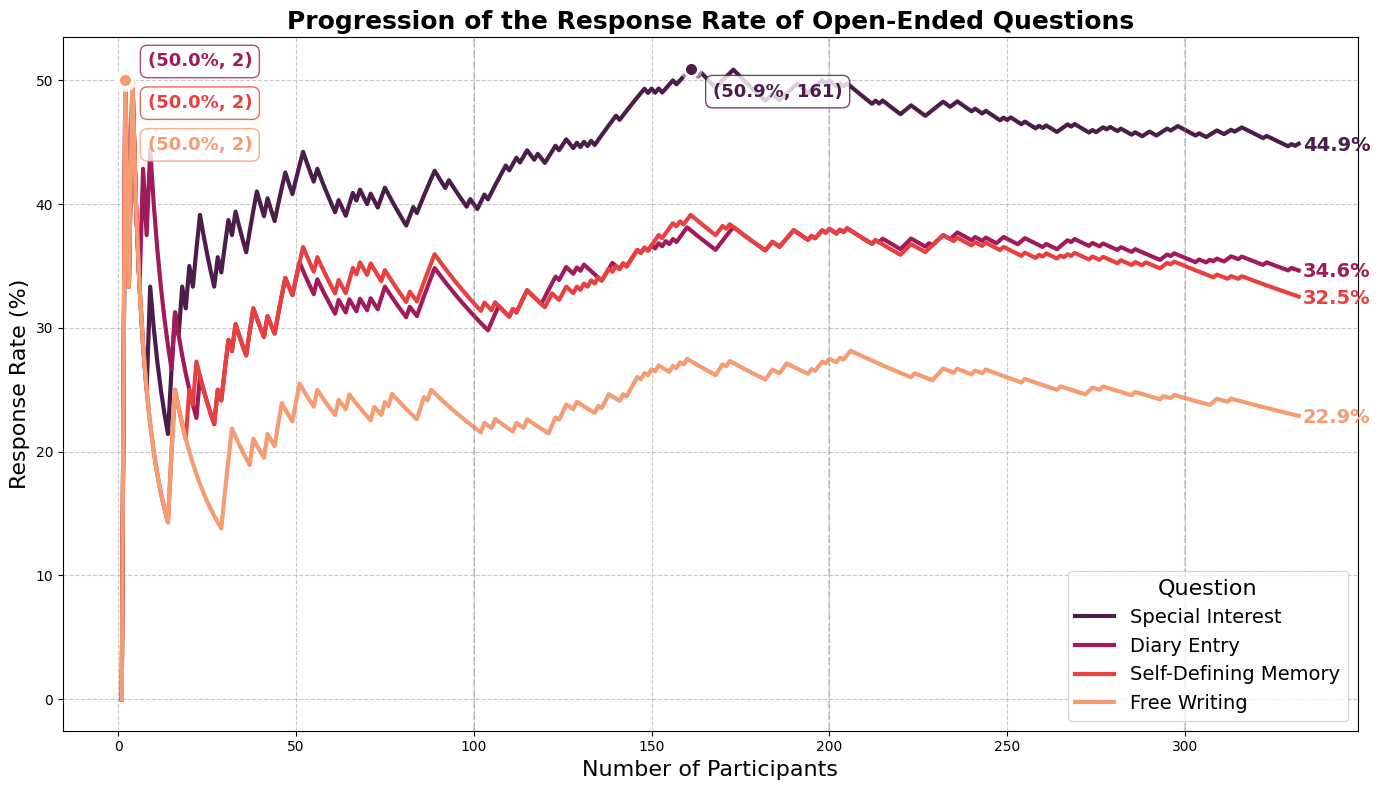

In [19]:
# Create a figure for the progression of response rates
plt.figure(figsize=(14, 8))

# Get the cumulative response counts for each question type
question_columns = [
    "special_interest",
    "diary_entry",
    "selfdefining_memory",
    "empty_sheet",
]
descriptive_names = [column_descriptive_names[col] for col in question_columns]

# Create a cumulative count of responses over the dataset
cumulative_responses = {}
for col in question_columns:
    # Get non-null responses sorted by index
    responses = df[col].notna()
    # Calculate cumulative sum of responses
    cumulative_responses[col] = responses.cumsum()

# Calculate total number of entries at each point
total_entries = pd.Series(range(1, len(df) + 1))

# Calculate the percentage of responses at each point
for col in question_columns:
    # Convert to percentage
    cumulative_responses[col] = (cumulative_responses[col] / total_entries) * 100

# Plot the evolution of response rates
for i, col in enumerate(question_columns):
    plt.plot(
        range(1, len(df) + 1),
        cumulative_responses[col],
        linewidth=3,
        label=descriptive_names[i],
        color=sns.color_palette("rocket", 4)[i],
    )

# Add labels and formatting
plt.title(
    "Progression of the Response Rate of Open-Ended Questions",
    fontsize=18,
    fontweight="bold",
)
plt.xlabel("Number of Participants", fontsize=16)
plt.ylabel("Response Rate (%)", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(title="Question", fontsize=14, title_fontsize=16, loc="lower right")

# Mark final response rates with annotations
for i, col in enumerate(question_columns):
    final_rate = cumulative_responses[col].iloc[-1]
    plt.annotate(
        f"{final_rate:.1f}%",
        xy=(len(df), final_rate),
        xytext=(3, -5),
        textcoords="offset points",
        fontsize=14,
        fontweight="bold",
        color=sns.color_palette("rocket", 4)[i],
    )

# Add vertical lines for milestones (e.g., 100, 200, 300 participants)
milestones = [100, 200, 300]
for milestone in milestones:
    if milestone < len(df):
        plt.axvline(
            milestone,
            color="gray",
            linestyle="--",
            alpha=0.3,
            label=f"{milestone} participants" if milestone == milestones[0] else "",
        )

# Add dots and annotations for maximum response rate points with improved visibility
for i, col in enumerate(question_columns):
    # Find when the response rate was maximum
    max_rate_idx = cumulative_responses[col].idxmax()
    max_rate = cumulative_responses[col].max()

    # Plot a more visible dot at the maximum point
    plt.plot(
        max_rate_idx + 1,  # +1 because index starts at 0 but our x-axis starts at 1
        max_rate,
        "o",
        markersize=10,  # Increased marker size
        color=sns.color_palette("rocket", 4)[i],
        markeredgecolor="white",
        markeredgewidth=2.0,  # Made edge thicker
        zorder=10,  # Ensure dots appear on top of lines
    )

    # Add a halo effect to make dots more visible
    plt.plot(
        max_rate_idx + 1,
        max_rate,
        "o",
        markersize=15,  # Larger outer circle
        color="white",
        alpha=0.4,
        zorder=9,
    )

    # Improved annotation with better visibility
    annotation_color = sns.color_palette("rocket", 4)[i]

    # Adjust text positioning to avoid overlap
    if col == "diary_entry":  # Special positioning for diary entry
        xytext = (16, 10)
    elif i % 2 == 0:
        xytext = (16, -20)
    else:
        xytext = (16, -50)

    plt.annotate(
        f"({max_rate:.1f}%, {max_rate_idx + 1})",
        xy=(max_rate_idx + 1, max_rate),
        xytext=xytext,
        textcoords="offset points",
        fontsize=13,
        fontweight="bold",
        color=annotation_color,
        bbox=dict(boxstyle="round,pad=0.4", fc="white", ec=annotation_color, alpha=0.8),
    )

# Improve the layout and appearance
plt.tight_layout()
plt.savefig("data/response_rate_progression.png", dpi=300, bbox_inches="tight")
plt.show()

### Close-Ended Questions Analysis

/tmp/ipykernel_24475/2259063563.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = df_close_ended.groupby(df["adhd_diagnosis"]).mean().round(2)


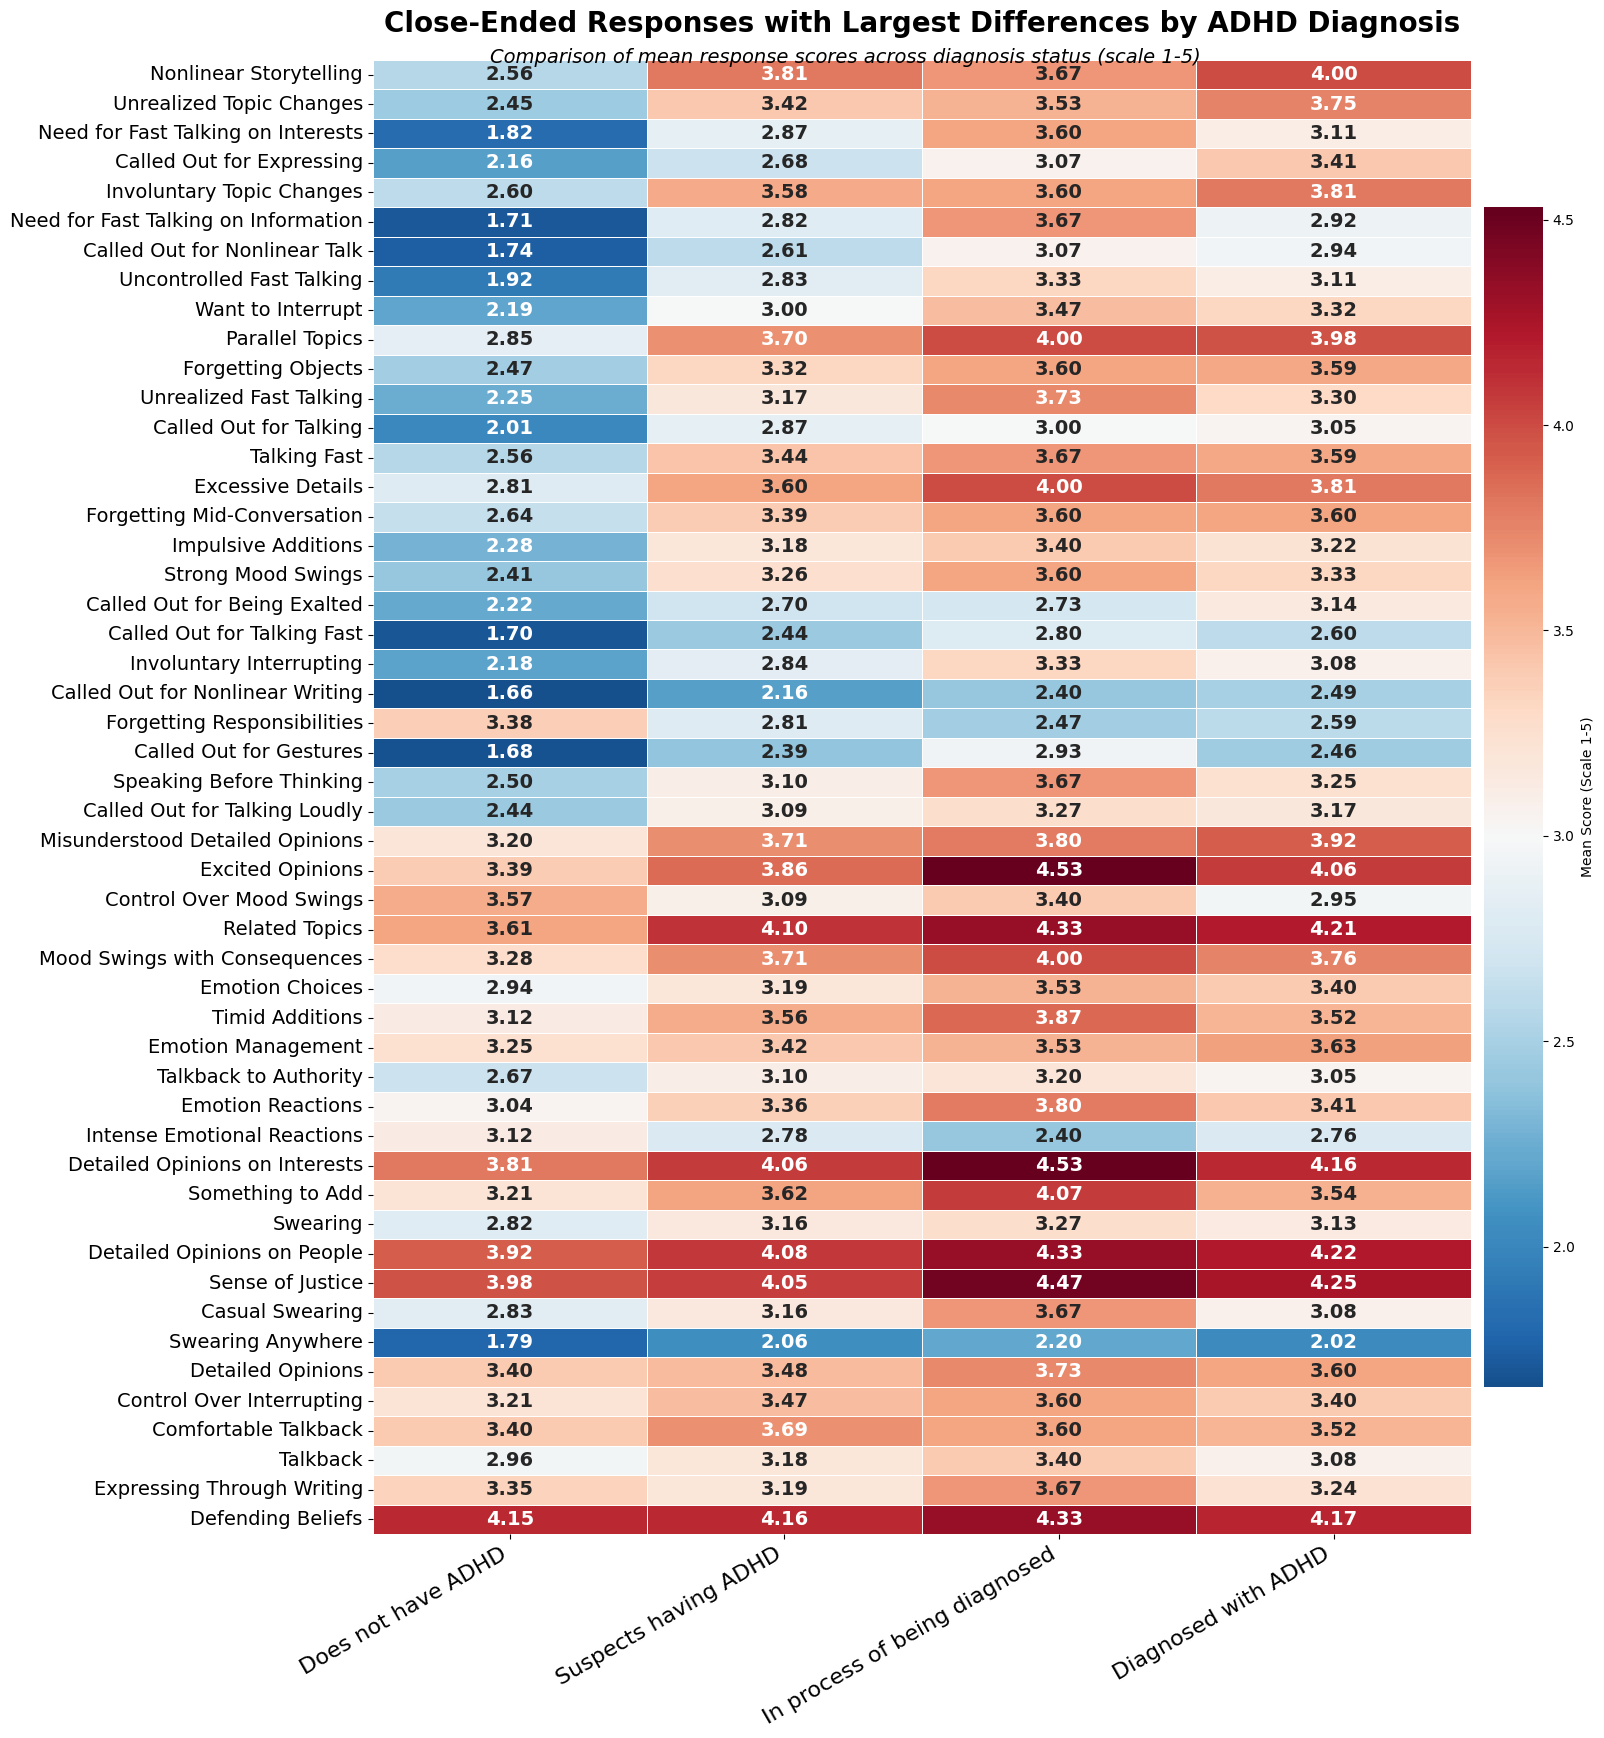

In [20]:
columns_to_ignore = [
    "datetime",
    "sex",
    "adhd_diagnosis",
    "age",
    "education",
    "occupation",
    "dialect",
    "special_interest",
    "diary_entry",
    "selfdefining_memory",
    "empty_sheet",
]

df_filtered = df.drop(columns=columns_to_ignore)

# Rename columns in the dataframe for better readability
df_filtered_renamed = df_filtered.rename(columns=feature_map)

df_close_ended = df_filtered_renamed.copy()

# Convert categorical columns to numeric
for col in df_close_ended.columns:
    if df_close_ended[col].dtype.name == "category":
        df_close_ended[col] = df_close_ended[col].astype(float)

# Calculate the mean of the values for each diagnosis
mean_values = df_close_ended.groupby(df["adhd_diagnosis"]).mean().round(2)

# Define the order for diagnosis categories
diagnosis_order = [
    "Does not have ADHD",
    "Suspects having ADHD",
    "In process of being diagnosed",
    "Diagnosed with ADHD",
]
mean_values = mean_values.reindex(diagnosis_order)

# Transpose and calculate differences between diagnosed and non-ADHD
mean_values_transposed = mean_values.T
diff_column = abs(
    mean_values_transposed["Diagnosed with ADHD"] - mean_values_transposed["Does not have ADHD"]
)
mean_values_transposed["difference"] = diff_column
mean_values_sorted = mean_values_transposed.sort_values(
    by="difference", ascending=False
)
mean_values_sorted = mean_values_sorted.drop("difference", axis=1)

# Create a cleaner heatmap with better color contrast
plt.figure(figsize=(17, 19))
mask = np.zeros_like(mean_values_sorted)
mask = mean_values_sorted.isna()

# Use a sequential colormap for better interpretation
ax = sns.heatmap(
    mean_values_sorted,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"shrink": 0.8, "label": "Mean Score (Scale 1-5)", "pad": 0.01},
    center=3,  # Center colormap at midpoint of scale
    annot_kws={"size": 14, "weight": "bold"},
    mask=mask,
)

# Add title and labels with improved styling
plt.title(
    "Close-Ended Responses with Largest Differences by ADHD Diagnosis",
    fontsize=20,
    fontweight="bold",
    pad=20,
)
plt.xlabel("", fontsize=18, labelpad=15)

# Add a subtitle explaining the data
plt.figtext(
    0.5,
    0.914,
    "Comparison of mean response scores across diagnosis status (scale 1-5)",
    ha="center",
    fontsize=14,
    style="italic",
)

# Format x-axis labels for better readability
plt.xticks(rotation=30, ha="right", fontsize=16)
plt.yticks(fontsize=14)

# Improve spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig("data/heatmap_close_ended_sorted.png", dpi=300, bbox_inches="tight")
plt.show()

## Data Dimensionality

### Dataset Structure

/tmp/ipykernel_24475/2831170387.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=values, palette="rocket", ax=ax)


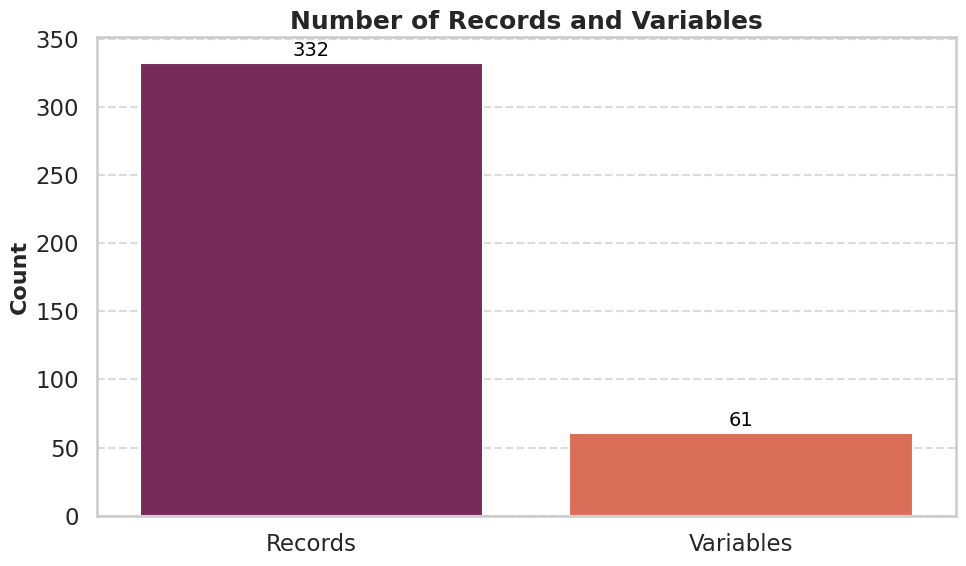

In [21]:
# Set a more visually appealing theme
sns.set_theme(style="whitegrid", context="talk")

# Create the bar plot with improved aesthetics
values = [df.shape[0], df.shape[1]]  # Number of records and variables
categories = ["Records", "Variables"]

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=categories, y=values, palette="rocket", ax=ax)

# Add labels and title with improved font sizes and weights
ax.set_ylabel("Count", fontsize=16, fontweight="bold")
ax.set_xlabel("", fontsize=14)
ax.set_title("Number of Records and Variables", fontsize=18, fontweight="bold")

# Annotate the bars with values
for i, value in enumerate(values):
    ax.text(
        i, value + 2, f"{value}", ha="center", va="bottom", fontsize=14, color="black"
    )

# Set the y-axis limit to ensure the bars fit within the plot
ax.set_ylim(0, max(values) + 19)

# Add a grid for better readability
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig("data/number_of_records_and_variables.png", dpi=300, bbox_inches="tight")
plt.show()

### Principal Component Analysis

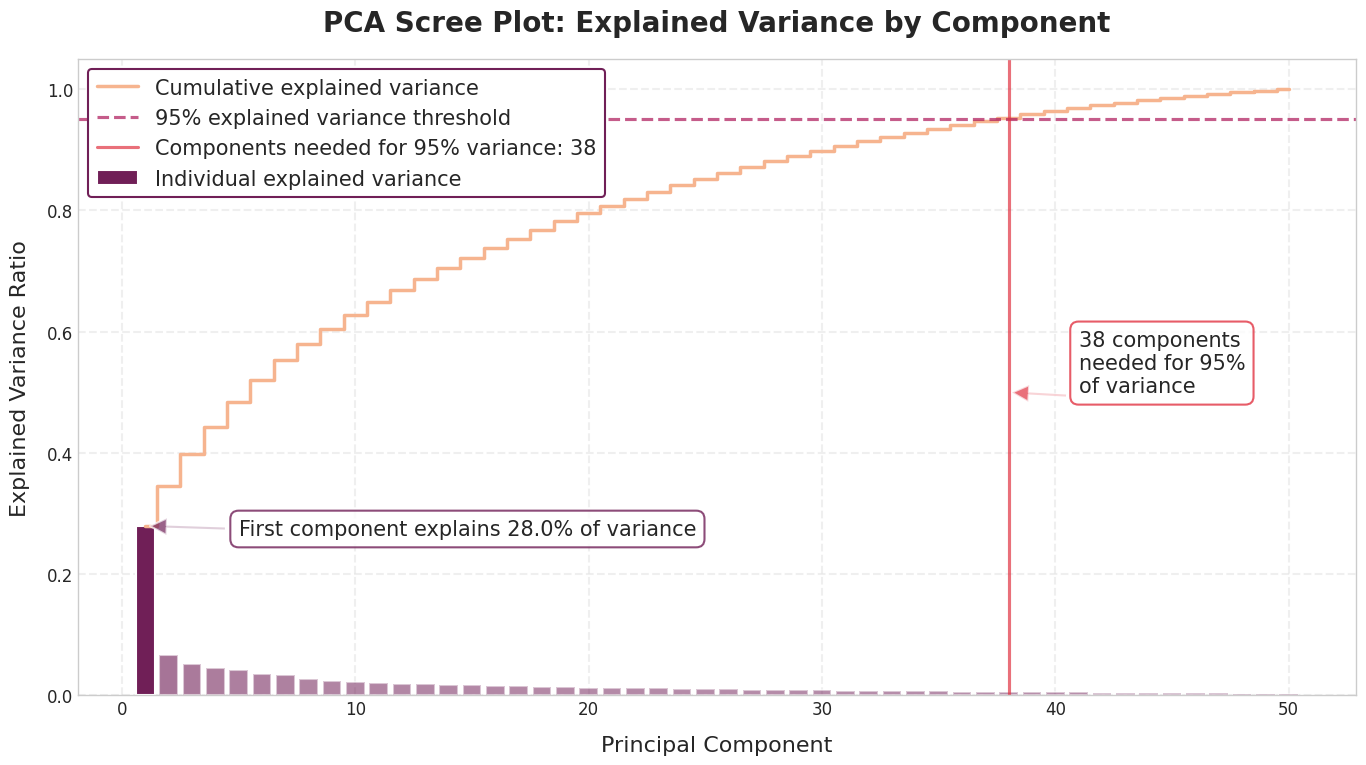

In [22]:
# Filter the dataframe to include only the relevant numerical features
# Excluding demographic and text data
columns_to_ignore = [
    "datetime",
    "sex",
    "adhd_diagnosis",
    "age",
    "education",
    "occupation",
    "dialect",
    "special_interest",
    "diary_entry",
    "selfdefining_memory",
    "empty_sheet",
]

# Use only numeric values for PCA
df_for_pca = df.drop(columns=columns_to_ignore).copy()

# Convert categorical columns to numeric if needed
for col in df_for_pca.columns:
    if df_for_pca[col].dtype.name == "category":
        df_for_pca[col] = df_for_pca[col].astype(float)

# Check for missing values and fill them with the mean for each column
df_for_pca = df_for_pca.fillna(df_for_pca.mean())

# Standardize the data for PCA
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_for_pca)

# Perform PCA
pca = PCA()
principal_components = pca.fit_transform(df_scaled)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Create an enhanced Scree Plot with more professional look
plt.figure(figsize=(14, 8))
plt.style.use("seaborn-v0_8-whitegrid")

rocket_colors = sns.color_palette("rocket", 6)

# Plot individual variance explained with more attractive colors
bars = plt.bar(
    range(1, len(explained_variance_ratio) + 1),
    explained_variance_ratio,
    alpha=0.8,
    color=rocket_colors[1],
    label="Individual explained variance",
)

# Add gradient effect to bars
for i, bar in enumerate(bars):
    bar.set_alpha(0.5 + 0.5 * explained_variance_ratio[i] / explained_variance_ratio[0])

# Plot cumulative variance explained with thicker line
plt.step(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    where="mid",
    label="Cumulative explained variance",
    color=rocket_colors[5],
    linewidth=2.5,
)

# Add reference line for 95% variance explained
plt.axhline(
    y=0.95,
    color=rocket_colors[2],
    linestyle="--",
    alpha=0.7,
    label="95% explained variance threshold",
)

# Find the number of components needed for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
plt.axvline(
    x=n_components_95,
    color=rocket_colors[3],
    linestyle="-",
    alpha=0.7,
    label=f"Components needed for 95% variance: {n_components_95}",
)

# Add title and labels with improved styling
plt.title(
    "PCA Scree Plot: Explained Variance by Component",
    fontsize=20,
    fontweight="bold",
    pad=20,
)
plt.xlabel("Principal Component", fontsize=16, labelpad=12)
plt.ylabel("Explained Variance Ratio", fontsize=16, labelpad=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Improve grid appearance
plt.grid(alpha=0.3, linestyle="--")

# Add annotations with more appealing format
plt.annotate(
    f"First component explains {explained_variance_ratio[0] * 100:.1f}% of variance",
    xy=(1, explained_variance_ratio[0]),
    xytext=(5, explained_variance_ratio[0] - 0.015),
    fontsize=15,
    arrowprops=dict(facecolor=rocket_colors[1], shrink=0.05, width=1.5, alpha=0.7),
    bbox=dict(boxstyle="round,pad=0.4", fc="white", ec=rocket_colors[1], alpha=0.8),
)

# Add annotation for the 95% threshold component
plt.annotate(
    f"{n_components_95} components\nneeded for 95%\nof variance",
    xy=(n_components_95, 0.5),
    xytext=(n_components_95 + 3, 0.5),
    fontsize=15,
    arrowprops=dict(facecolor=rocket_colors[3], shrink=0.05, width=1.5, alpha=0.7),
    bbox=dict(boxstyle="round,pad=0.4", fc="white", ec=rocket_colors[3], alpha=0.8),
)

# Add legend with better styling and positioning
plt.legend(
    fontsize=15,
    loc="upper left",
    framealpha=1,
    edgecolor=rocket_colors[1],
    fancybox=True,
    frameon=True,
)

# Improve overall appearance
plt.tight_layout()
plt.savefig("data/pca_scree_plot.png", dpi=300, bbox_inches="tight")
plt.show()

## Data Sparsity

### All Words

In [23]:
# use spacy to get the number of words in each diary entry
word_count_df = df[
    ["special_interest", "diary_entry", "selfdefining_memory", "empty_sheet"]
].copy()

nlp = spacy.load("pt_core_news_lg")


def count_words(text):
    if pd.isna(text):
        return 0
    doc = nlp(text)
    return len(doc)

def count_content_words(text):
    if pd.isna(text):
        return 0
    doc = nlp(text)
    # Count only content words: NOUN, VERB, ADJ, ADV, PROPN
    content_pos = {"NOUN", "VERB", "ADJ", "ADV", "PROPN"}
    return sum(1 for token in doc if token.pos_ in content_pos)


word_count_df["special_interest_word_count"] = word_count_df["special_interest"].apply(
    count_words
)
word_count_df["diary_entry_word_count"] = word_count_df["diary_entry"].apply(
    count_words
)
word_count_df["selfdefining_memory_word_count"] = word_count_df[
    "selfdefining_memory"
].apply(count_words)
word_count_df["empty_sheet_word_count"] = word_count_df["empty_sheet"].apply(
    count_words
)



#### Word Count Distribution

/tmp/ipykernel_24475/29395994.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


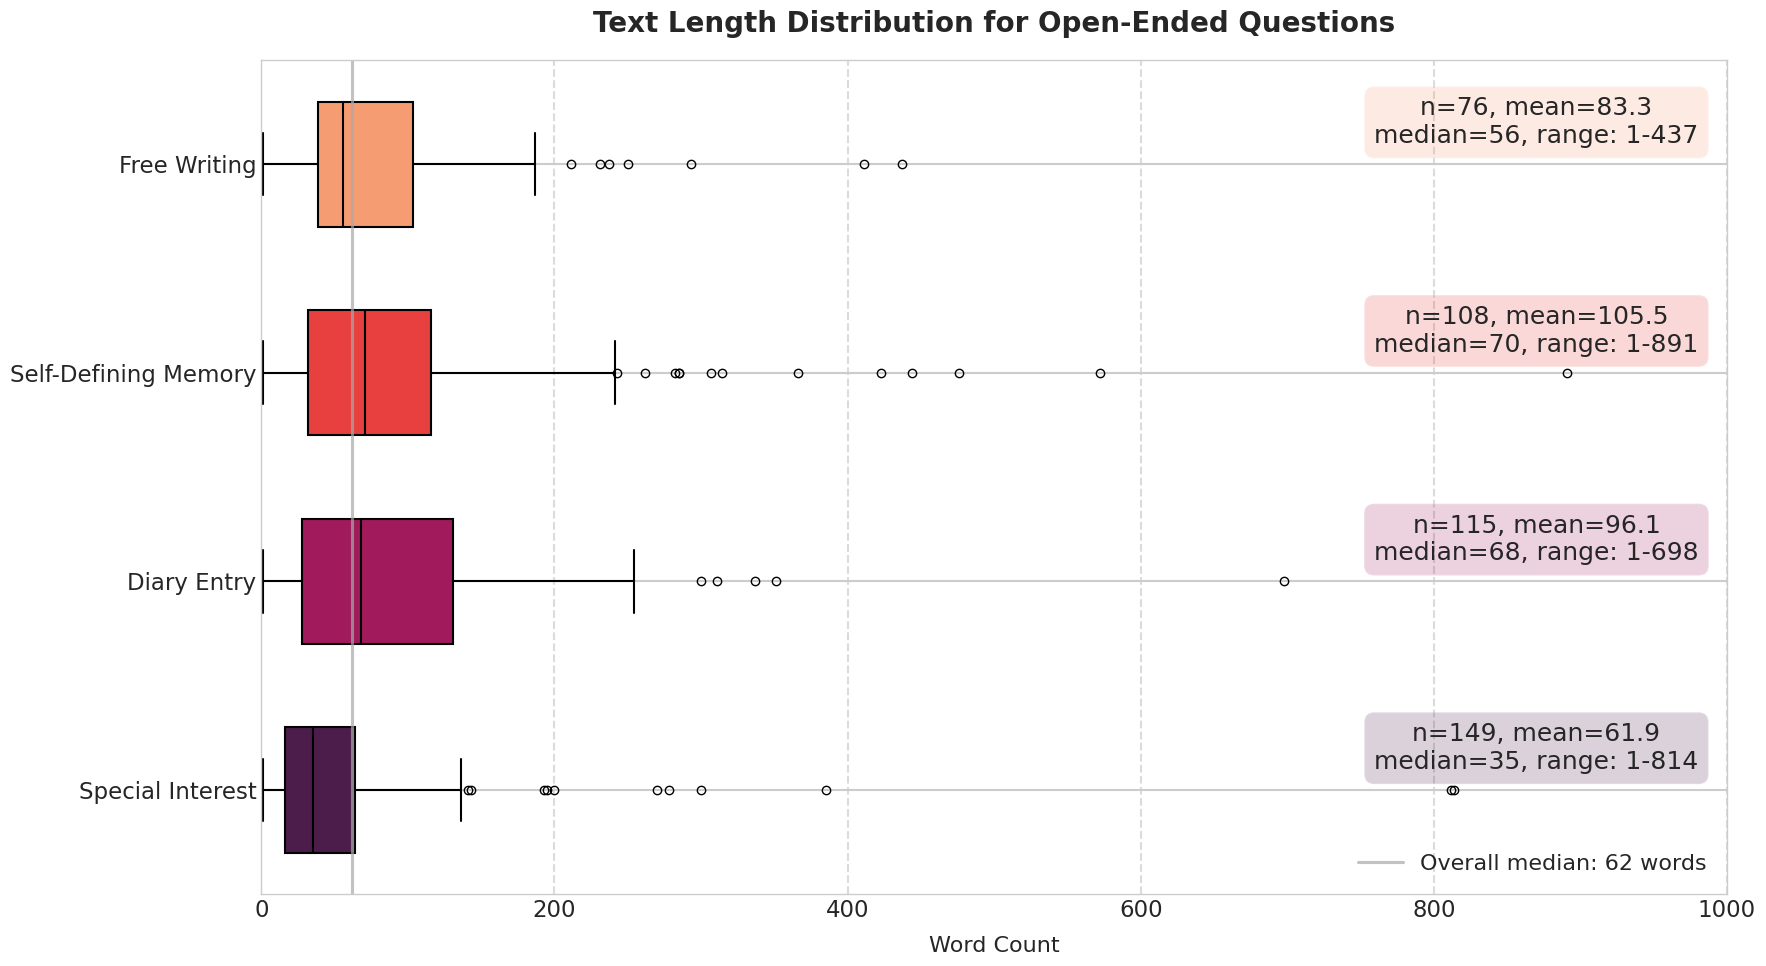

In [24]:
# Create a figure with more appropriate dimensions
fig, ax = plt.subplots(figsize=(18, 10))

# Explicitly define the order of columns to be displayed
question_order = [
    "special_interest",
    "diary_entry",
    "selfdefining_memory",
    "empty_sheet",
]
column_order = [col + "_word_count" for col in question_order]

# Get question descriptions in the right order
descriptive_names = [column_descriptive_names[col] for col in question_order]

# Prepare data for the boxplot, filtering out zero values (empty responses)
boxplot_data = []
for col in column_order:
    # Filter out zeros (empty texts)
    filtered_data = word_count_df[word_count_df[col] > 0][col]
    boxplot_data.append(filtered_data)

# Calculate statistics for each text type
stats = {}
for i, (col, name) in enumerate(zip(question_order, descriptive_names)):
    filtered_data = word_count_df[word_count_df[f"{col}_word_count"] > 0][
        f"{col}_word_count"
    ]
    stats[name] = {
        "count": len(filtered_data),
        "mean": filtered_data.mean(),
        "median": filtered_data.median(),
        "max": filtered_data.max(),
        "min": filtered_data.min(),
    }

# Create the horizontal boxplot with filtered data
bp = ax.boxplot(
    boxplot_data, vert=False, patch_artist=True, labels=descriptive_names, widths=0.6
)

# Customize boxplot colors using rocket color palette
for i, box in enumerate(bp["boxes"]):
    box.set(color="black", linewidth=1.5)
    box.set(facecolor=sns.color_palette("rocket", 4)[i])

for element in ["whiskers", "caps", "medians"]:
    for item in bp[element]:
        item.set(color="black", linewidth=1.5)

# Add a grid for better readability
ax.grid(axis="x", linestyle="--", alpha=0.7)

# Set title and labels with better formatting
ax.set_title(
    "Text Length Distribution for Open-Ended Questions",
    fontsize=20,
    fontweight="bold",
    pad=20,
)
ax.set_xlabel("Word Count", fontsize=16, labelpad=10)
ax.set_ylabel("", fontsize=16, labelpad=10)

# Add annotations with statistics
for i, (name, stat) in enumerate(stats.items()):
    y_pos = i + 1
    # Create the annotation text with key statistics
    annotation = f"n={stat['count']}, mean={stat['mean']:.1f}\nmedian={stat['median']:.0f}, range: {stat['min']}-{stat['max']}"

    # Position the annotation at the right end of the plot
    ax.annotate(
        annotation,
        xy=(
            ax.get_xlim()[1] * 0.93,
            y_pos + 0.2,
        ),  # Adjusted x position for better visibility
        xytext=(0, 0),
        textcoords="offset points",
        ha="center",
        va="center",
        fontsize=18,
        bbox=dict(
            boxstyle="round,pad=0.4", fc=sns.color_palette("rocket", 4)[i], alpha=0.2
        ),
    )

# Add a horizontal reference line for the median value across all responses
median_val = np.median([stats[name]["median"] for name in descriptive_names])
ax.axvline(median_val, color="darkgray", linestyle="-", alpha=0.7,
           label=f"Overall median: {median_val:.0f} words")

# Set x-axis limit to 1000
ax.set_xlim(0, 1000)

# Add legend
ax.legend(loc="lower right", fontsize=16)

# Save and display plot
plt.tight_layout()
plt.savefig("data/text_length_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

#### Word Count Distribution by ADHD Diagnosis

/tmp/ipykernel_24475/3553310587.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


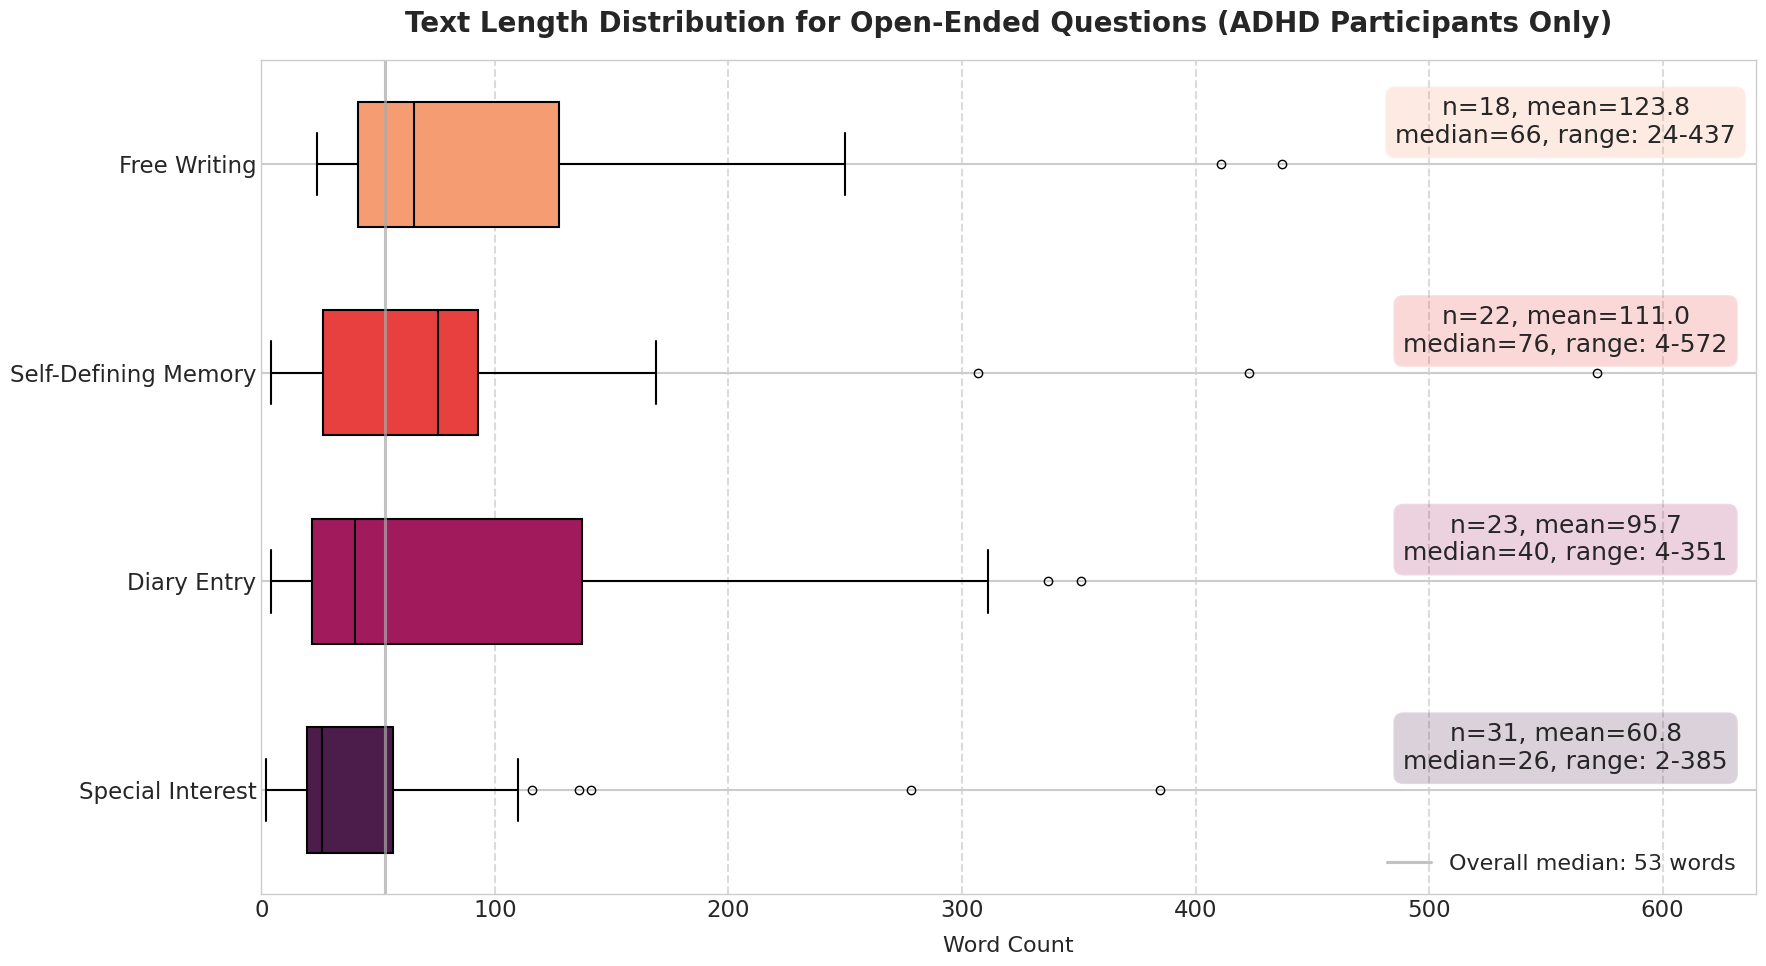

In [25]:
# Create a figure with more appropriate dimensions for ADHD diagnosis only
fig, ax = plt.subplots(figsize=(18, 10))

# Filter data to include only ADHD diagnosed participants
adhd_df = word_count_df[df["adhd_diagnosis"] == "Diagnosed with ADHD"]

# Explicitly define the order of columns to be displayed
question_order = [
    "special_interest",
    "diary_entry",
    "selfdefining_memory",
    "empty_sheet",
]
column_order = [col + "_word_count" for col in question_order]

# Get question descriptions in the right order
descriptive_names = [column_descriptive_names[col] for col in question_order]

# Prepare data for the boxplot, filtering out zero values (empty responses)
boxplot_data = []
for col in column_order:
    # Filter out zeros (empty texts)
    filtered_data = adhd_df[adhd_df[col] > 0][col]
    boxplot_data.append(filtered_data)

# Calculate statistics for each text type
stats = {}
for i, (col, name) in enumerate(zip(question_order, descriptive_names)):
    filtered_data = adhd_df[adhd_df[f"{col}_word_count"] > 0][f"{col}_word_count"]
    stats[name] = {
        "count": len(filtered_data),
        "mean": filtered_data.mean(),
        "median": filtered_data.median(),
        "max": filtered_data.max(),
        "min": filtered_data.min(),
    }

# Create the horizontal boxplot with filtered data
bp = ax.boxplot(
    boxplot_data, vert=False, patch_artist=True, labels=descriptive_names, widths=0.6
)

# Customize boxplot colors using rocket color palette
for i, box in enumerate(bp["boxes"]):
    box.set(color="black", linewidth=1.5)
    box.set(facecolor=sns.color_palette("rocket", 4)[i])

for element in ["whiskers", "caps", "medians"]:
    for item in bp[element]:
        item.set(color="black", linewidth=1.5)

# Add a grid for better readability
ax.grid(axis="x", linestyle="--", alpha=0.7)

# Set title and labels with better formatting
ax.set_title(
    "Text Length Distribution for Open-Ended Questions (ADHD Participants Only)",
    fontsize=20,
    fontweight="bold",
    pad=20,
)
ax.set_xlabel("Word Count", fontsize=16, labelpad=10)
ax.set_ylabel("", fontsize=16, labelpad=10)

# Add annotations with statistics
for i, (name, stat) in enumerate(stats.items()):
    y_pos = i + 1
    # Create the annotation text with key statistics
    annotation = f"n={stat['count']}, mean={stat['mean']:.1f}\nmedian={stat['median']:.0f}, range: {stat['min']}-{stat['max']}"

    # Position the annotation at the right end of the plot
    ax.annotate(
        annotation,
        xy=(
            ax.get_xlim()[1] * 0.93,
            y_pos + 0.2,
        ),  # Adjusted x position for better visibility
        xytext=(0, 0),
        textcoords="offset points",
        ha="center",
        va="center",
        fontsize=18,
        bbox=dict(
            boxstyle="round,pad=0.4", fc=sns.color_palette("rocket", 4)[i], alpha=0.2
        ),
    )

# Add a horizontal reference line for the median value across all responses
median_val = np.median([stats[name]["median"] for name in descriptive_names])
ax.axvline(
    median_val,
    color="darkgray",
    linestyle="-",
    alpha=0.7,
    label=f"Overall median: {median_val:.0f} words",
)

# Set x-axis limit to 1000
ax.set_xlim(0, 640)

# Add legend
ax.legend(loc="lower right", fontsize=16)

# Save and display plot
plt.tight_layout()
plt.savefig("data/text_length_distribution_adhd_only.png", dpi=300, bbox_inches="tight")
plt.show()

/tmp/ipykernel_24475/3784898423.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


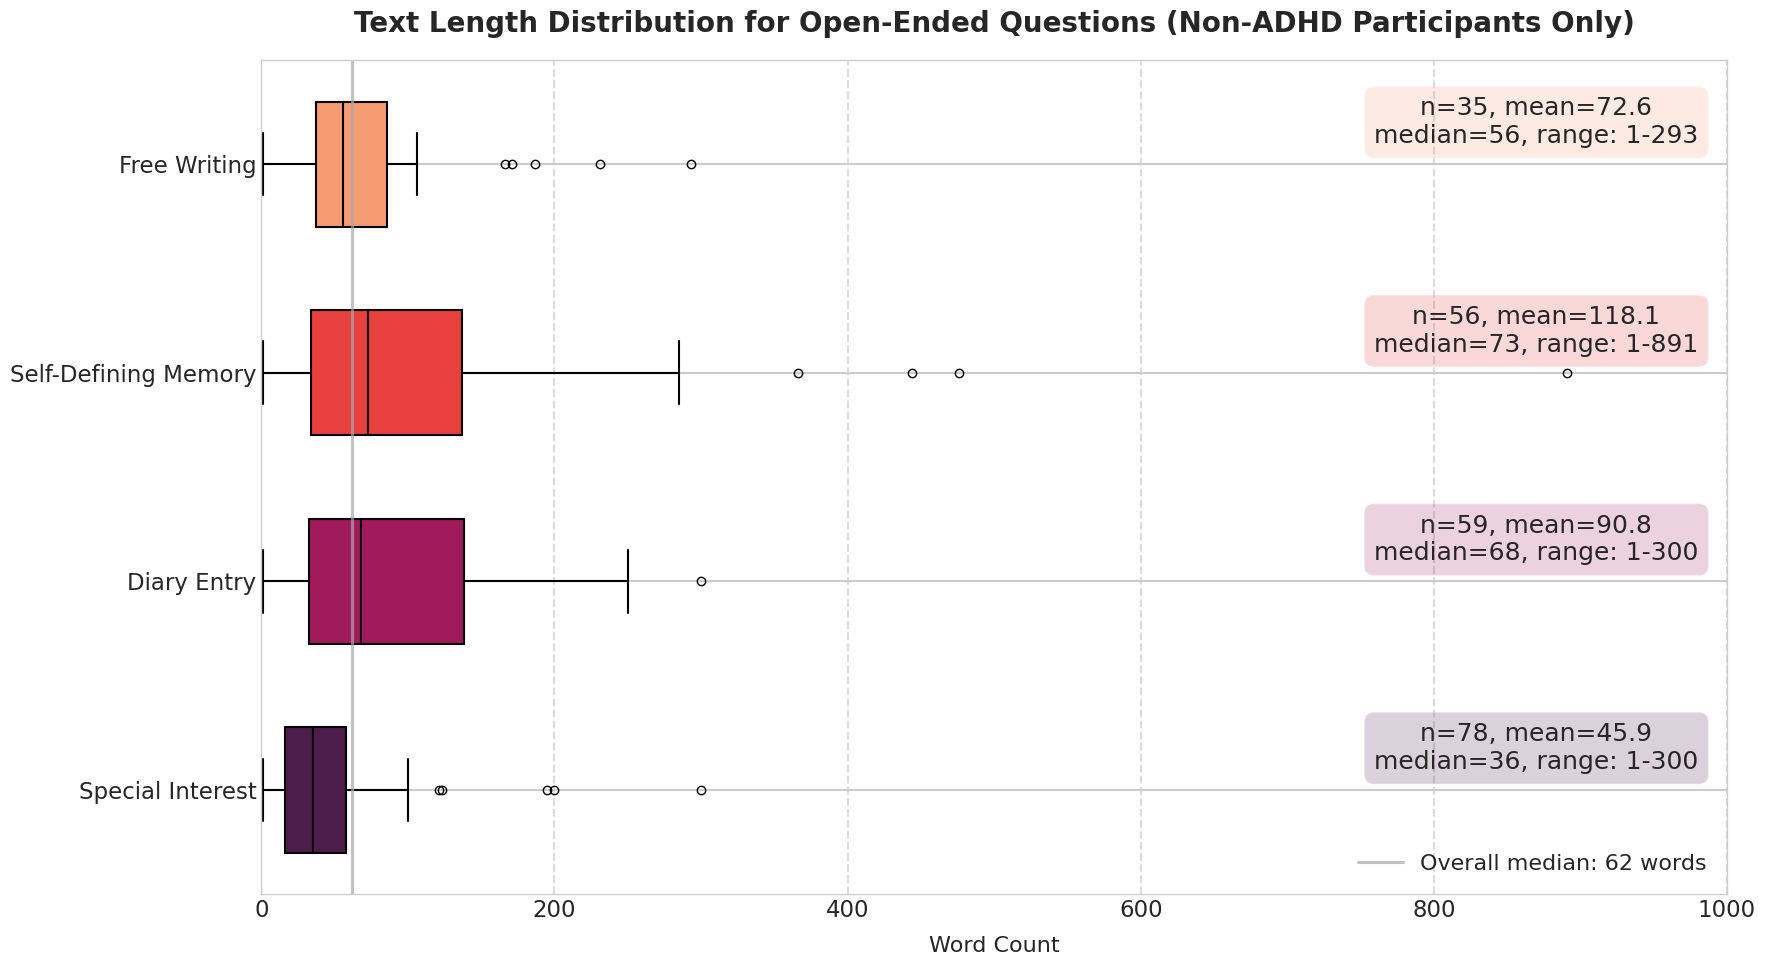

In [26]:
# Create a figure with more appropriate dimensions for ADHD diagnosis only
fig, ax = plt.subplots(figsize=(18, 10))

# Filter data to include only ADHD diagnosed participants
adhd_df = word_count_df[df["adhd_diagnosis"] == "Does not have ADHD"]

# Explicitly define the order of columns to be displayed
question_order = [
    "special_interest",
    "diary_entry",
    "selfdefining_memory",
    "empty_sheet",
]
column_order = [col + "_word_count" for col in question_order]

# Get question descriptions in the right order
descriptive_names = [column_descriptive_names[col] for col in question_order]

# Prepare data for the boxplot, filtering out zero values (empty responses)
boxplot_data = []
for col in column_order:
    # Filter out zeros (empty texts)
    filtered_data = adhd_df[adhd_df[col] > 0][col]
    boxplot_data.append(filtered_data)

# Calculate statistics for each text type
stats = {}
for i, (col, name) in enumerate(zip(question_order, descriptive_names)):
    filtered_data = adhd_df[adhd_df[f"{col}_word_count"] > 0][f"{col}_word_count"]
    stats[name] = {
        "count": len(filtered_data),
        "mean": filtered_data.mean(),
        "median": filtered_data.median(),
        "max": filtered_data.max(),
        "min": filtered_data.min(),
    }

# Create the horizontal boxplot with filtered data
bp = ax.boxplot(
    boxplot_data, vert=False, patch_artist=True, labels=descriptive_names, widths=0.6
)

# Customize boxplot colors using rocket color palette
for i, box in enumerate(bp["boxes"]):
    box.set(color="black", linewidth=1.5)
    box.set(facecolor=sns.color_palette("rocket", 4)[i])

for element in ["whiskers", "caps", "medians"]:
    for item in bp[element]:
        item.set(color="black", linewidth=1.5)

# Add a grid for better readability
ax.grid(axis="x", linestyle="--", alpha=0.7)

# Set title and labels with better formatting
ax.set_title(
    "Text Length Distribution for Open-Ended Questions (Non-ADHD Participants Only)",
    fontsize=20,
    fontweight="bold",
    pad=20,
)
ax.set_xlabel("Word Count", fontsize=16, labelpad=10)
ax.set_ylabel("", fontsize=16, labelpad=10)

# Add annotations with statistics
for i, (name, stat) in enumerate(stats.items()):
    y_pos = i + 1
    # Create the annotation text with key statistics
    annotation = f"n={stat['count']}, mean={stat['mean']:.1f}\nmedian={stat['median']:.0f}, range: {stat['min']}-{stat['max']}"

    # Position the annotation at the right end of the plot
    ax.annotate(
        annotation,
        xy=(
            ax.get_xlim()[1] * 0.93,
            y_pos + 0.2,
        ),  # Adjusted x position for better visibility
        xytext=(0, 0),
        textcoords="offset points",
        ha="center",
        va="center",
        fontsize=18,
        bbox=dict(
            boxstyle="round,pad=0.4", fc=sns.color_palette("rocket", 4)[i], alpha=0.2
        ),
    )

# Add a horizontal reference line for the median value across all responses
median_val = np.median([stats[name]["median"] for name in descriptive_names])
ax.axvline(
    median_val,
    color="darkgray",
    linestyle="-",
    alpha=0.7,
    label=f"Overall median: {median_val:.0f} words",
)

# Set x-axis limit to 1000
ax.set_xlim(0, 1000)

# Add legend
ax.legend(loc="lower right", fontsize=16)

# Save and display plot
plt.tight_layout()
plt.savefig(
    "data/text_length_distribution_non_adhd_only.png", dpi=300, bbox_inches="tight"
)
plt.show()

#### Word Count Distribution by Sex

/tmp/ipykernel_24475/3320468227.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


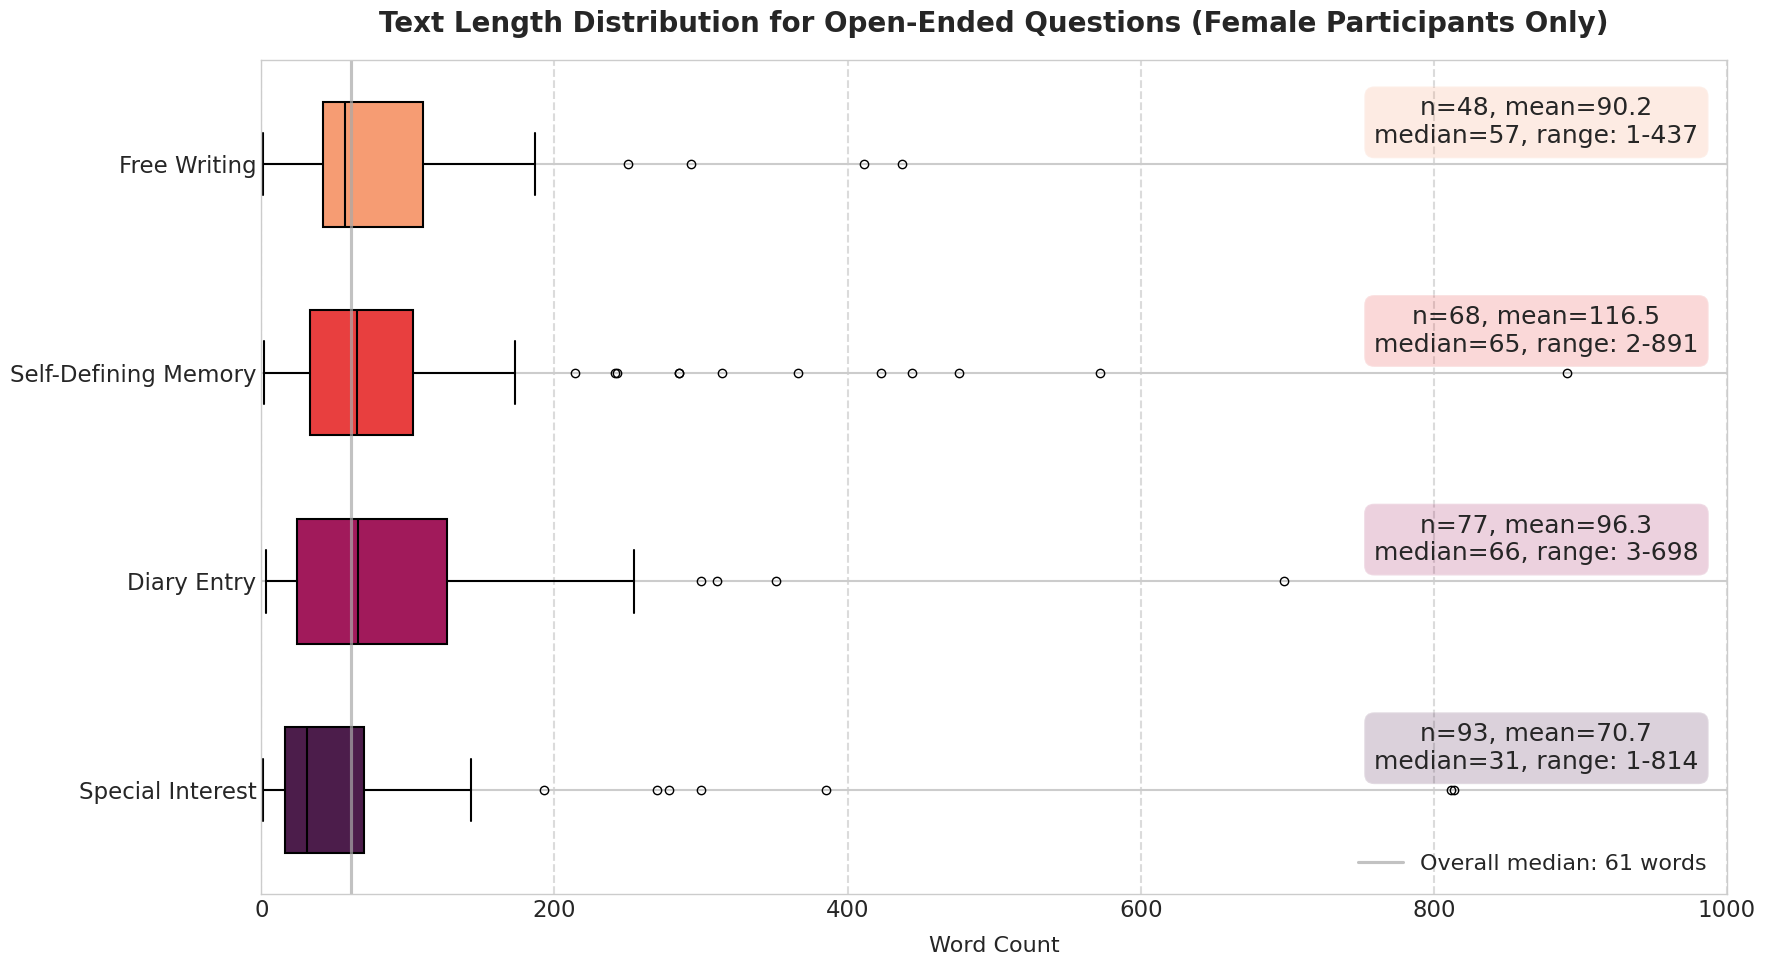

In [27]:
# Create a figure with more appropriate dimensions for ADHD diagnosis only
fig, ax = plt.subplots(figsize=(18, 10))

# Filter data to include only ADHD diagnosed participants
adhd_df = word_count_df[df["sex"] == "Female"]

# Explicitly define the order of columns to be displayed
question_order = [
    "special_interest",
    "diary_entry",
    "selfdefining_memory",
    "empty_sheet",
]
column_order = [col + "_word_count" for col in question_order]

# Get question descriptions in the right order
descriptive_names = [column_descriptive_names[col] for col in question_order]

# Prepare data for the boxplot, filtering out zero values (empty responses)
boxplot_data = []
for col in column_order:
    # Filter out zeros (empty texts)
    filtered_data = adhd_df[adhd_df[col] > 0][col]
    boxplot_data.append(filtered_data)

# Calculate statistics for each text type
stats = {}
for i, (col, name) in enumerate(zip(question_order, descriptive_names)):
    filtered_data = adhd_df[adhd_df[f"{col}_word_count"] > 0][f"{col}_word_count"]
    stats[name] = {
        "count": len(filtered_data),
        "mean": filtered_data.mean(),
        "median": filtered_data.median(),
        "max": filtered_data.max(),
        "min": filtered_data.min(),
    }

# Create the horizontal boxplot with filtered data
bp = ax.boxplot(
    boxplot_data, vert=False, patch_artist=True, labels=descriptive_names, widths=0.6
)

# Customize boxplot colors using rocket color palette
for i, box in enumerate(bp["boxes"]):
    box.set(color="black", linewidth=1.5)
    box.set(facecolor=sns.color_palette("rocket", 4)[i])

for element in ["whiskers", "caps", "medians"]:
    for item in bp[element]:
        item.set(color="black", linewidth=1.5)

# Add a grid for better readability
ax.grid(axis="x", linestyle="--", alpha=0.7)

# Set title and labels with better formatting
ax.set_title(
    "Text Length Distribution for Open-Ended Questions (Female Participants Only)",
    fontsize=20,
    fontweight="bold",
    pad=20,
)
ax.set_xlabel("Word Count", fontsize=16, labelpad=10)
ax.set_ylabel("", fontsize=16, labelpad=10)

# Add annotations with statistics
for i, (name, stat) in enumerate(stats.items()):
    y_pos = i + 1
    # Create the annotation text with key statistics
    annotation = f"n={stat['count']}, mean={stat['mean']:.1f}\nmedian={stat['median']:.0f}, range: {stat['min']}-{stat['max']}"

    # Position the annotation at the right end of the plot
    ax.annotate(
        annotation,
        xy=(
            ax.get_xlim()[1] * 0.93,
            y_pos + 0.2,
        ),  # Adjusted x position for better visibility
        xytext=(0, 0),
        textcoords="offset points",
        ha="center",
        va="center",
        fontsize=18,
        bbox=dict(
            boxstyle="round,pad=0.4", fc=sns.color_palette("rocket", 4)[i], alpha=0.2
        ),
    )

# Add a horizontal reference line for the median value across all responses
median_val = np.median([stats[name]["median"] for name in descriptive_names])
ax.axvline(
    median_val,
    color="darkgray",
    linestyle="-",
    alpha=0.7,
    label=f"Overall median: {median_val:.0f} words",
)

# Set x-axis limit to 1000
ax.set_xlim(0, 1000)

# Add legend
ax.legend(loc="lower right", fontsize=16)

# Save and display plot
plt.tight_layout()
plt.savefig(
    "data/text_length_distribution_female_only.png", dpi=300, bbox_inches="tight"
)
plt.show()

/tmp/ipykernel_24475/3049327471.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


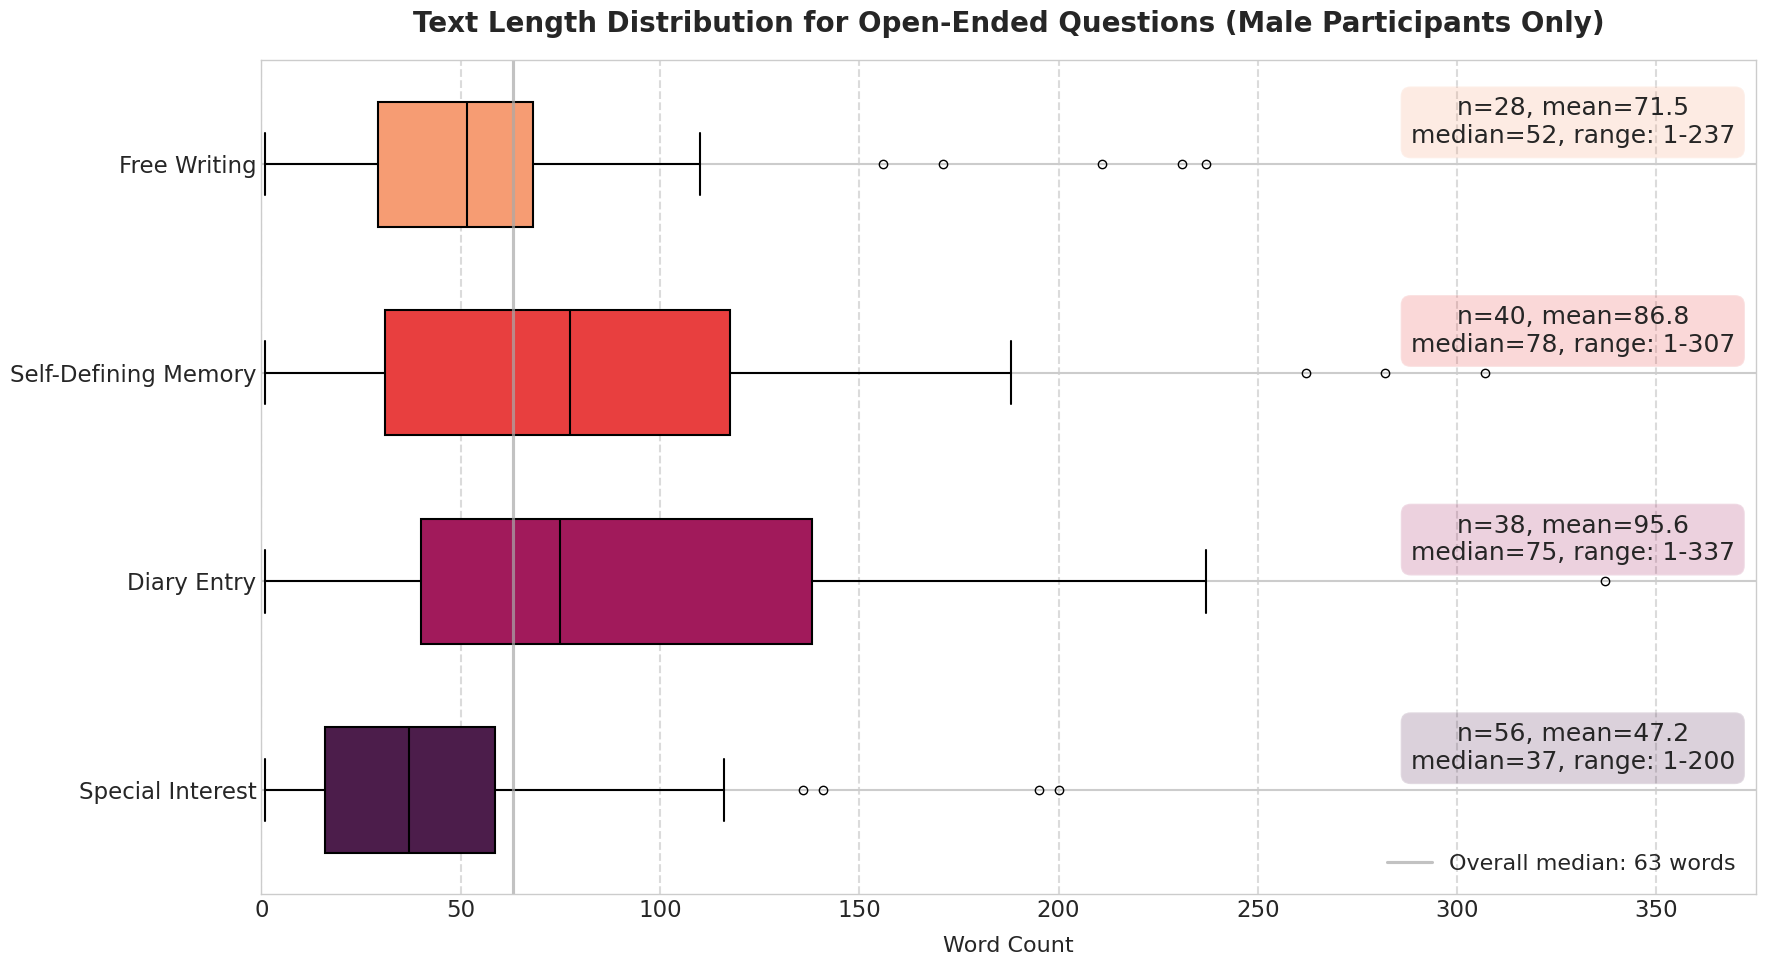

In [28]:
# Create a figure with more appropriate dimensions for ADHD diagnosis only
fig, ax = plt.subplots(figsize=(18, 10))

# Filter data to include only ADHD diagnosed participants
adhd_df = word_count_df[df["sex"] == "Male"]

# Explicitly define the order of columns to be displayed
question_order = [
    "special_interest",
    "diary_entry",
    "selfdefining_memory",
    "empty_sheet",
]
column_order = [col + "_word_count" for col in question_order]

# Get question descriptions in the right order
descriptive_names = [column_descriptive_names[col] for col in question_order]

# Prepare data for the boxplot, filtering out zero values (empty responses)
boxplot_data = []
for col in column_order:
    # Filter out zeros (empty texts)
    filtered_data = adhd_df[adhd_df[col] > 0][col]
    boxplot_data.append(filtered_data)

# Calculate statistics for each text type
stats = {}
for i, (col, name) in enumerate(zip(question_order, descriptive_names)):
    filtered_data = adhd_df[adhd_df[f"{col}_word_count"] > 0][f"{col}_word_count"]
    stats[name] = {
        "count": len(filtered_data),
        "mean": filtered_data.mean(),
        "median": filtered_data.median(),
        "max": filtered_data.max(),
        "min": filtered_data.min(),
    }

# Create the horizontal boxplot with filtered data
bp = ax.boxplot(
    boxplot_data, vert=False, patch_artist=True, labels=descriptive_names, widths=0.6
)

# Customize boxplot colors using rocket color palette
for i, box in enumerate(bp["boxes"]):
    box.set(color="black", linewidth=1.5)
    box.set(facecolor=sns.color_palette("rocket", 4)[i])

for element in ["whiskers", "caps", "medians"]:
    for item in bp[element]:
        item.set(color="black", linewidth=1.5)

# Add a grid for better readability
ax.grid(axis="x", linestyle="--", alpha=0.7)

# Set title and labels with better formatting
ax.set_title(
    "Text Length Distribution for Open-Ended Questions (Male Participants Only)",
    fontsize=20,
    fontweight="bold",
    pad=20,
)
ax.set_xlabel("Word Count", fontsize=16, labelpad=10)
ax.set_ylabel("", fontsize=16, labelpad=10)

# Add annotations with statistics
for i, (name, stat) in enumerate(stats.items()):
    y_pos = i + 1
    # Create the annotation text with key statistics
    annotation = f"n={stat['count']}, mean={stat['mean']:.1f}\nmedian={stat['median']:.0f}, range: {stat['min']}-{stat['max']}"

    # Position the annotation at the right end of the plot
    ax.annotate(
        annotation,
        xy=(
            ax.get_xlim()[1] * 0.93,
            y_pos + 0.2,
        ),  # Adjusted x position for better visibility
        xytext=(0, 0),
        textcoords="offset points",
        ha="center",
        va="center",
        fontsize=18,
        bbox=dict(
            boxstyle="round,pad=0.4", fc=sns.color_palette("rocket", 4)[i], alpha=0.2
        ),
    )

# Add a horizontal reference line for the median value across all responses
median_val = np.median([stats[name]["median"] for name in descriptive_names])
ax.axvline(
    median_val,
    color="darkgray",
    linestyle="-",
    alpha=0.7,
    label=f"Overall median: {median_val:.0f} words",
)

# Set x-axis limit to 1000
ax.set_xlim(0, 375)

# Add legend
ax.legend(loc="lower right", fontsize=16)

# Save and display plot
plt.tight_layout()
plt.savefig("data/text_length_distribution_male_only.png", dpi=300, bbox_inches="tight")
plt.show()

### Content Words

In [29]:
# use spacy to get the number of words in each diary entry
word_count_df = df[
    ["special_interest", "diary_entry", "selfdefining_memory", "empty_sheet"]
].copy()

nlp = spacy.load("pt_core_news_lg")

def count_content_words(text):
    if pd.isna(text):
        return 0
    doc = nlp(text)
    # Count only content words: NOUN, VERB, ADJ, ADV, PROPN
    content_pos = {"NOUN", "VERB", "ADJ", "ADV", "PROPN"}
    return sum(1 for token in doc if token.pos_ in content_pos)


word_count_df["special_interest_word_count"] = word_count_df["special_interest"].apply(
    count_content_words
)
word_count_df["diary_entry_word_count"] = word_count_df["diary_entry"].apply(
    count_content_words
)
word_count_df["selfdefining_memory_word_count"] = word_count_df[
    "selfdefining_memory"
].apply(count_content_words)
word_count_df["empty_sheet_word_count"] = word_count_df["empty_sheet"].apply(
    count_content_words
)



#### Word Count Distribution

/tmp/ipykernel_24475/3389848592.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


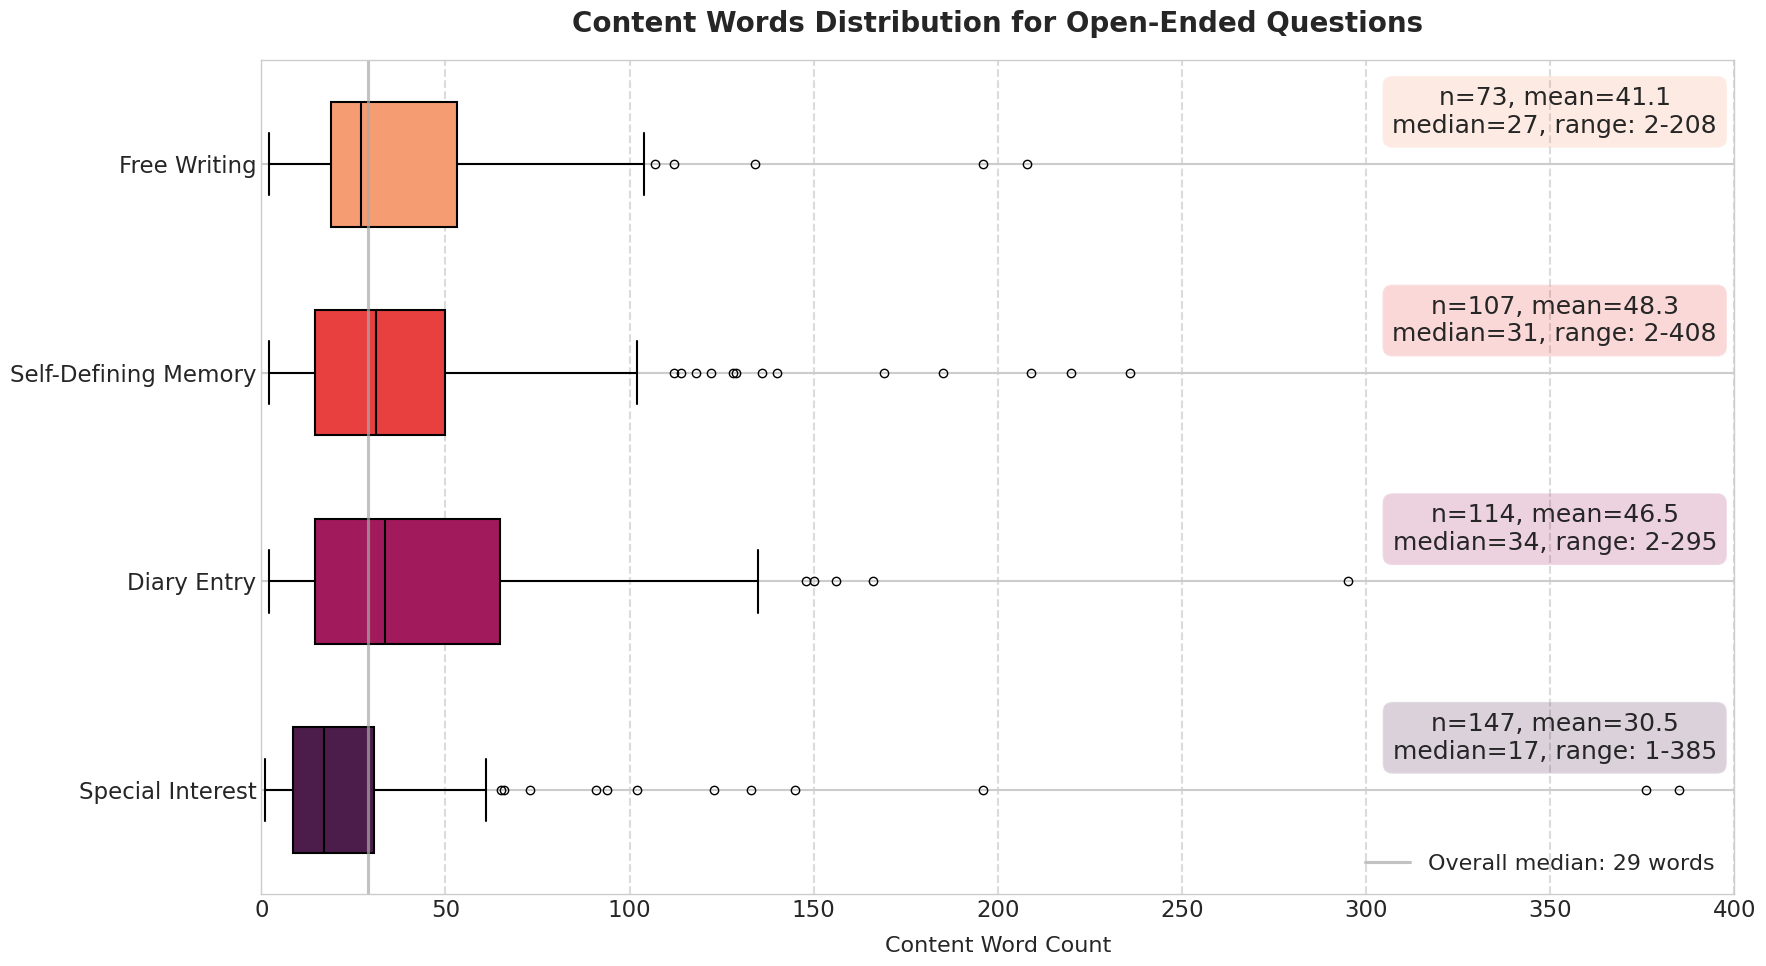

In [30]:
# Create a figure with more appropriate dimensions
fig, ax = plt.subplots(figsize=(18, 10))

# Explicitly define the order of columns to be displayed
question_order = [
    "special_interest",
    "diary_entry",
    "selfdefining_memory",
    "empty_sheet",
]
column_order = [col + "_word_count" for col in question_order]

# Get question descriptions in the right order
descriptive_names = [column_descriptive_names[col] for col in question_order]

# Prepare data for the boxplot, filtering out zero values (empty responses)
boxplot_data = []
for col in column_order:
    # Filter out zeros (empty texts)
    filtered_data = word_count_df[word_count_df[col] > 0][col]
    boxplot_data.append(filtered_data)

# Calculate statistics for each text type
stats = {}
for i, (col, name) in enumerate(zip(question_order, descriptive_names)):
    filtered_data = word_count_df[word_count_df[f"{col}_word_count"] > 0][
        f"{col}_word_count"
    ]
    stats[name] = {
        "count": len(filtered_data),
        "mean": filtered_data.mean(),
        "median": filtered_data.median(),
        "max": filtered_data.max(),
        "min": filtered_data.min(),
    }

# Create the horizontal boxplot with filtered data
bp = ax.boxplot(
    boxplot_data, vert=False, patch_artist=True, labels=descriptive_names, widths=0.6
)

# Customize boxplot colors using rocket color palette
for i, box in enumerate(bp["boxes"]):
    box.set(color="black", linewidth=1.5)
    box.set(facecolor=sns.color_palette("rocket", 4)[i])

for element in ["whiskers", "caps", "medians"]:
    for item in bp[element]:
        item.set(color="black", linewidth=1.5)

# Add a grid for better readability
ax.grid(axis="x", linestyle="--", alpha=0.7)

# Set title and labels with better formatting
ax.set_title(
    "Content Words Distribution for Open-Ended Questions",
    fontsize=20,
    fontweight="bold",
    pad=20,
)
ax.set_xlabel("Content Word Count", fontsize=16, labelpad=10)
ax.set_ylabel("", fontsize=16, labelpad=10)

# Add annotations with statistics
for i, (name, stat) in enumerate(stats.items()):
    y_pos = i + 1
    # Create the annotation text with key statistics
    annotation = f"n={stat['count']}, mean={stat['mean']:.1f}\nmedian={stat['median']:.0f}, range: {stat['min']}-{stat['max']}"

    # Position the annotation at the right end of the plot
    ax.annotate(
        annotation,
        xy=(
            ax.get_xlim()[1] * 0.82,
            y_pos + 0.25,
        ),  # Adjusted x position for better visibility
        xytext=(0, 0),
        textcoords="offset points",
        ha="center",
        va="center",
        fontsize=18,
        bbox=dict(
            boxstyle="round,pad=0.4", fc=sns.color_palette("rocket", 4)[i], alpha=0.2
        ),
    )

# Add a horizontal reference line for the median value across all responses
median_val = np.median([stats[name]["median"] for name in descriptive_names])
ax.axvline(median_val, color="darkgray", linestyle="-", alpha=0.7,
           label=f"Overall median: {median_val:.0f} words")

# Set x-axis limit to 1000
ax.set_xlim(0, 400)

# Add legend
ax.legend(loc="lower right", fontsize=16)

# Save and display plot
plt.tight_layout()
plt.savefig("data/content_word_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

#### Word Count Distribution by ADHD Diagnosis

/tmp/ipykernel_24475/1153355906.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


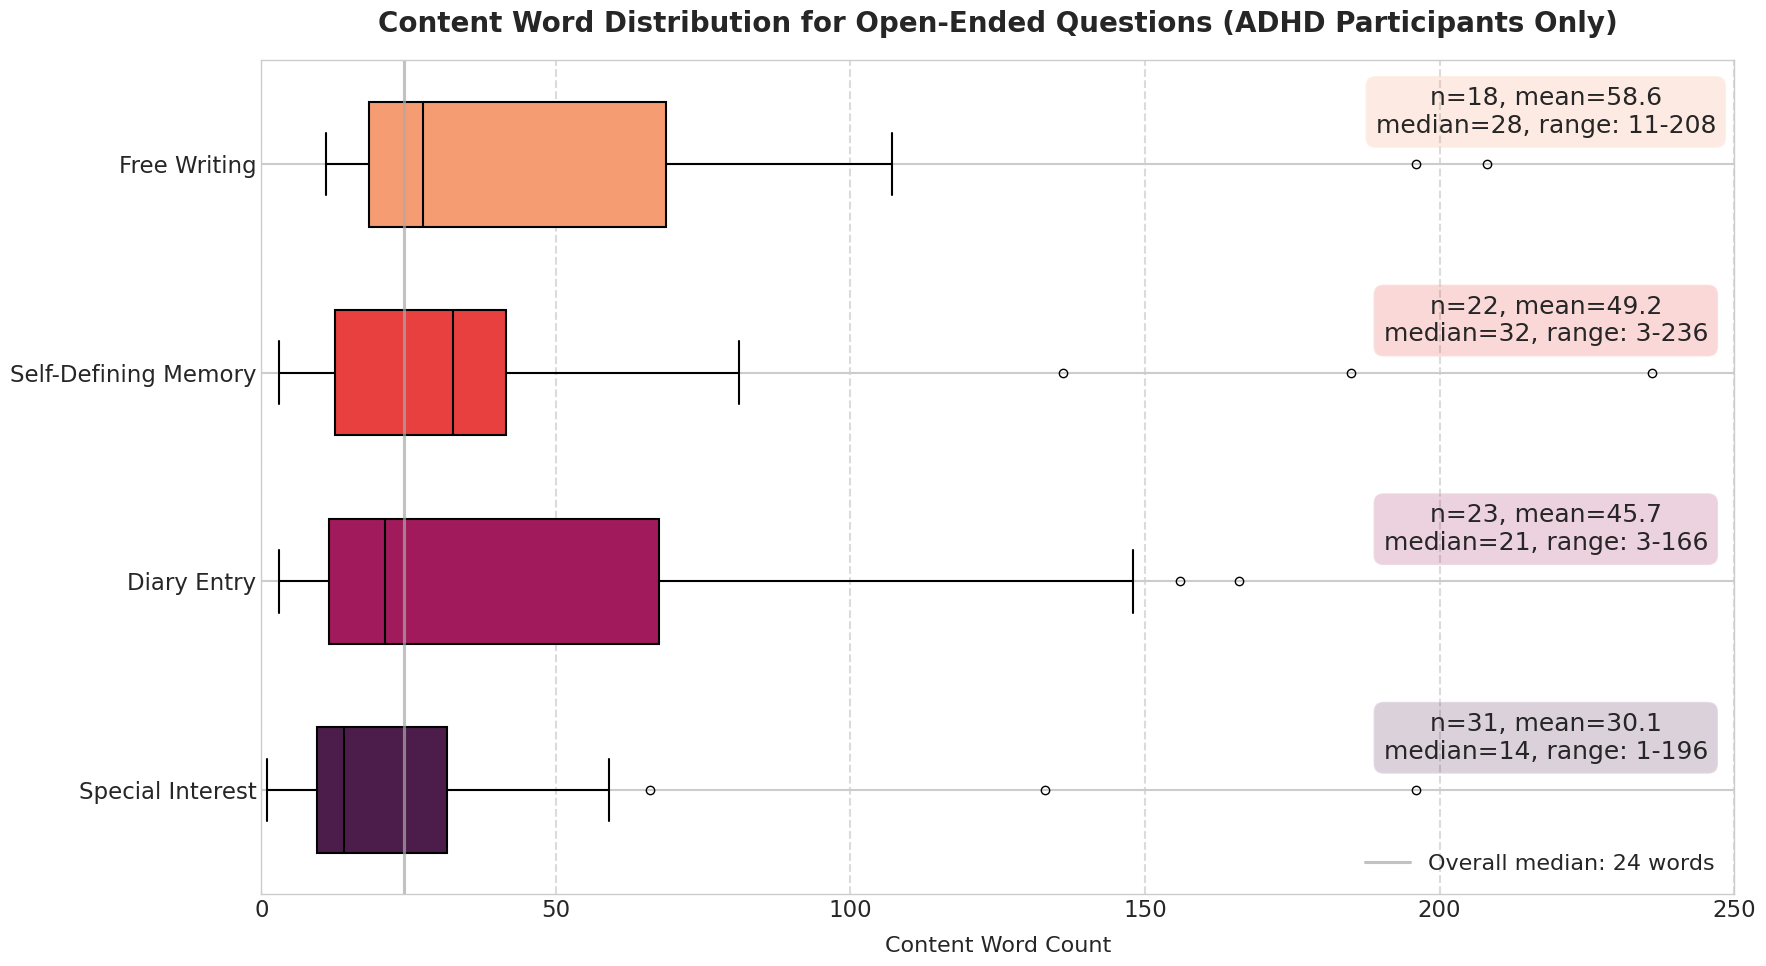

In [31]:
# Create a figure with more appropriate dimensions for ADHD diagnosis only
fig, ax = plt.subplots(figsize=(18, 10))

# Filter data to include only ADHD diagnosed participants
adhd_df = word_count_df[df["adhd_diagnosis"] == "Diagnosed with ADHD"]

# Explicitly define the order of columns to be displayed
question_order = [
    "special_interest",
    "diary_entry",
    "selfdefining_memory",
    "empty_sheet",
]
column_order = [col + "_word_count" for col in question_order]

# Get question descriptions in the right order
descriptive_names = [column_descriptive_names[col] for col in question_order]

# Prepare data for the boxplot, filtering out zero values (empty responses)
boxplot_data = []
for col in column_order:
    # Filter out zeros (empty texts)
    filtered_data = adhd_df[adhd_df[col] > 0][col]
    boxplot_data.append(filtered_data)

# Calculate statistics for each text type
stats = {}
for i, (col, name) in enumerate(zip(question_order, descriptive_names)):
    filtered_data = adhd_df[adhd_df[f"{col}_word_count"] > 0][f"{col}_word_count"]
    stats[name] = {
        "count": len(filtered_data),
        "mean": filtered_data.mean(),
        "median": filtered_data.median(),
        "max": filtered_data.max(),
        "min": filtered_data.min(),
    }

# Create the horizontal boxplot with filtered data
bp = ax.boxplot(
    boxplot_data, vert=False, patch_artist=True, labels=descriptive_names, widths=0.6
)

# Customize boxplot colors using rocket color palette
for i, box in enumerate(bp["boxes"]):
    box.set(color="black", linewidth=1.5)
    box.set(facecolor=sns.color_palette("rocket", 4)[i])

for element in ["whiskers", "caps", "medians"]:
    for item in bp[element]:
        item.set(color="black", linewidth=1.5)

# Add a grid for better readability
ax.grid(axis="x", linestyle="--", alpha=0.7)

# Set title and labels with better formatting
ax.set_title(
    "Content Word Distribution for Open-Ended Questions (ADHD Participants Only)",
    fontsize=20,
    fontweight="bold",
    pad=20,
)
ax.set_xlabel("Content Word Count", fontsize=16, labelpad=10)
ax.set_ylabel("", fontsize=16, labelpad=10)

# Add annotations with statistics
for i, (name, stat) in enumerate(stats.items()):
    y_pos = i + 1
    # Create the annotation text with key statistics
    annotation = f"n={stat['count']}, mean={stat['mean']:.1f}\nmedian={stat['median']:.0f}, range: {stat['min']}-{stat['max']}"

    # Position the annotation at the right end of the plot
    ax.annotate(
        annotation,
        xy=(
            ax.get_xlim()[1] * 0.88,
            y_pos + 0.25,
        ),  # Adjusted x position for better visibility
        xytext=(0, 0),
        textcoords="offset points",
        ha="center",
        va="center",
        fontsize=18,
        bbox=dict(
            boxstyle="round,pad=0.4", fc=sns.color_palette("rocket", 4)[i], alpha=0.2
        ),
    )

# Add a horizontal reference line for the median value across all responses
median_val = np.median([stats[name]["median"] for name in descriptive_names])
ax.axvline(
    median_val,
    color="darkgray",
    linestyle="-",
    alpha=0.7,
    label=f"Overall median: {median_val:.0f} words",
)

# Set x-axis limit to 1000
ax.set_xlim(0, 250)

# Add legend
ax.legend(loc="lower right", fontsize=16)

# Save and display plot
plt.tight_layout()
plt.savefig("data/content_word_distribution_adhd_only.png", dpi=300, bbox_inches="tight")
plt.show()

/tmp/ipykernel_24475/1019270985.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


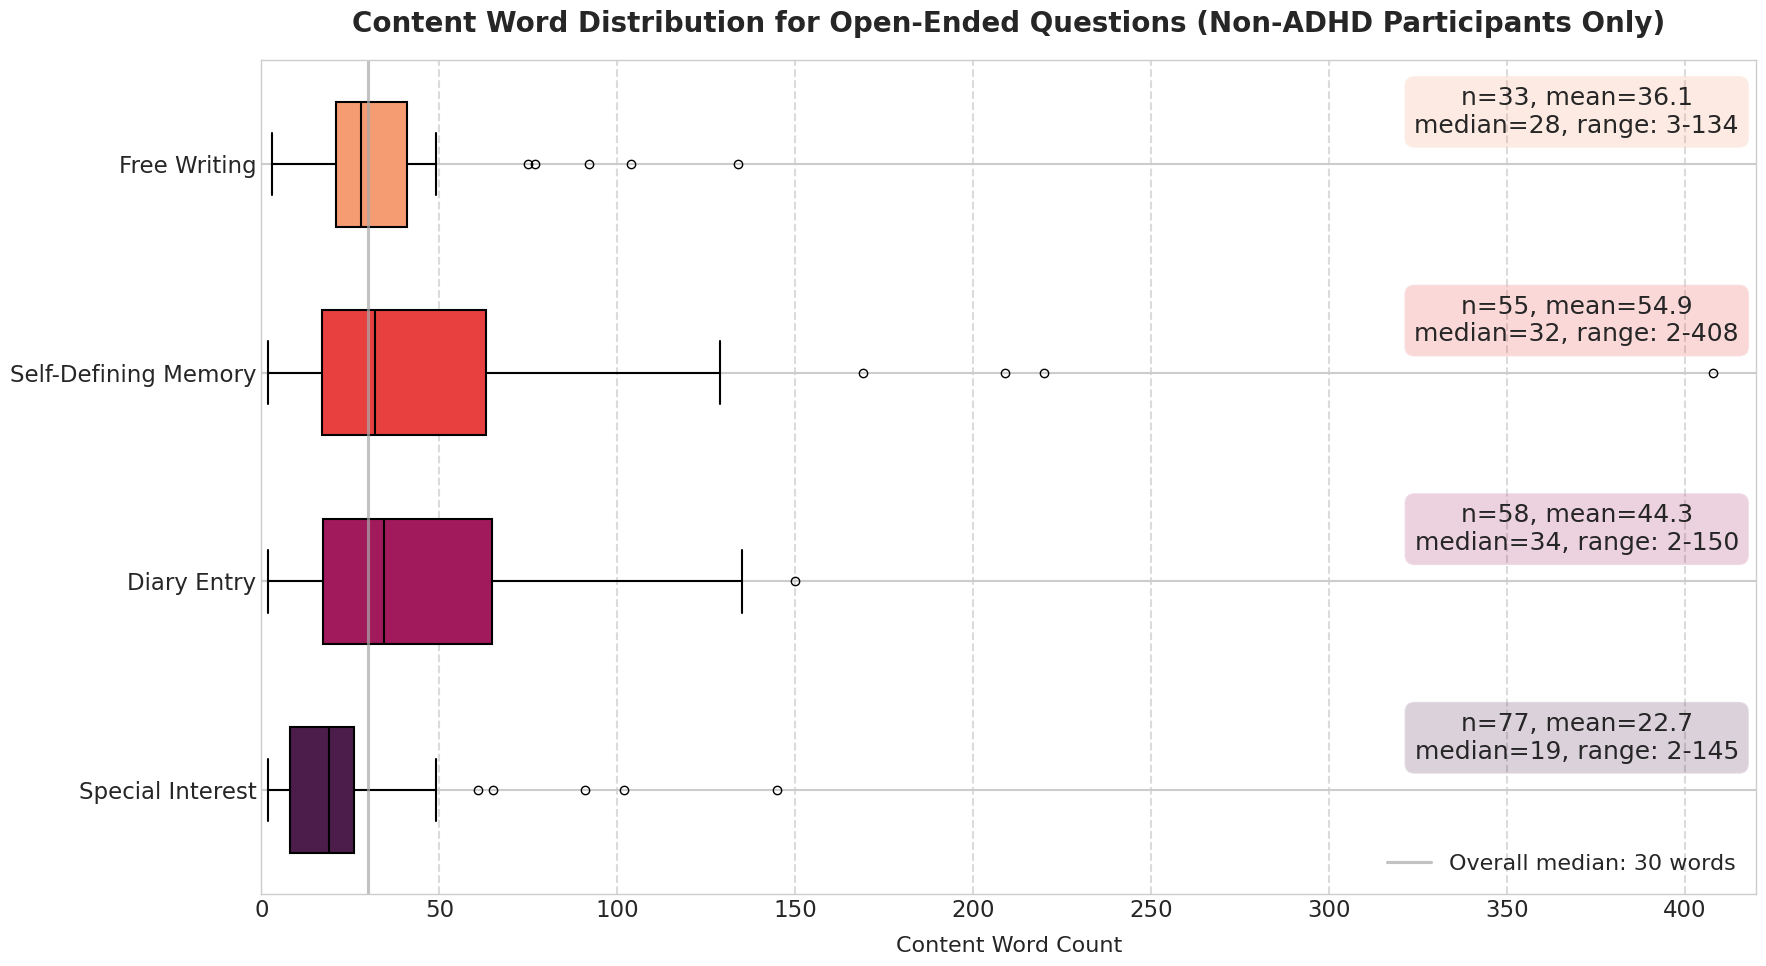

In [32]:
# Create a figure with more appropriate dimensions for ADHD diagnosis only
fig, ax = plt.subplots(figsize=(18, 10))

# Filter data to include only ADHD diagnosed participants
adhd_df = word_count_df[df["adhd_diagnosis"] == "Does not have ADHD"]

# Explicitly define the order of columns to be displayed
question_order = [
    "special_interest",
    "diary_entry",
    "selfdefining_memory",
    "empty_sheet",
]
column_order = [col + "_word_count" for col in question_order]

# Get question descriptions in the right order
descriptive_names = [column_descriptive_names[col] for col in question_order]

# Prepare data for the boxplot, filtering out zero values (empty responses)
boxplot_data = []
for col in column_order:
    # Filter out zeros (empty texts)
    filtered_data = adhd_df[adhd_df[col] > 0][col]
    boxplot_data.append(filtered_data)

# Calculate statistics for each text type
stats = {}
for i, (col, name) in enumerate(zip(question_order, descriptive_names)):
    filtered_data = adhd_df[adhd_df[f"{col}_word_count"] > 0][f"{col}_word_count"]
    stats[name] = {
        "count": len(filtered_data),
        "mean": filtered_data.mean(),
        "median": filtered_data.median(),
        "max": filtered_data.max(),
        "min": filtered_data.min(),
    }

# Create the horizontal boxplot with filtered data
bp = ax.boxplot(
    boxplot_data, vert=False, patch_artist=True, labels=descriptive_names, widths=0.6
)

# Customize boxplot colors using rocket color palette
for i, box in enumerate(bp["boxes"]):
    box.set(color="black", linewidth=1.5)
    box.set(facecolor=sns.color_palette("rocket", 4)[i])

for element in ["whiskers", "caps", "medians"]:
    for item in bp[element]:
        item.set(color="black", linewidth=1.5)

# Add a grid for better readability
ax.grid(axis="x", linestyle="--", alpha=0.7)

# Set title and labels with better formatting
ax.set_title(
    "Content Word Distribution for Open-Ended Questions (Non-ADHD Participants Only)",
    fontsize=20,
    fontweight="bold",
    pad=20,
)
ax.set_xlabel("Content Word Count", fontsize=16, labelpad=10)
ax.set_ylabel("", fontsize=16, labelpad=10)

# Add annotations with statistics
for i, (name, stat) in enumerate(stats.items()):
    y_pos = i + 1
    # Create the annotation text with key statistics
    annotation = f"n={stat['count']}, mean={stat['mean']:.1f}\nmedian={stat['median']:.0f}, range: {stat['min']}-{stat['max']}"

    # Position the annotation at the right end of the plot
    ax.annotate(
        annotation,
        xy=(
            ax.get_xlim()[1] * 0.863,
            y_pos + 0.25,
        ),  # Adjusted x position for better visibility
        xytext=(0, 0),
        textcoords="offset points",
        ha="center",
        va="center",
        fontsize=18,
        bbox=dict(
            boxstyle="round,pad=0.4", fc=sns.color_palette("rocket", 4)[i], alpha=0.2
        ),
    )

# Add a horizontal reference line for the median value across all responses
median_val = np.median([stats[name]["median"] for name in descriptive_names])
ax.axvline(
    median_val,
    color="darkgray",
    linestyle="-",
    alpha=0.7,
    label=f"Overall median: {median_val:.0f} words",
)

# Set x-axis limit to 1000
ax.set_xlim(0, 420)

# Add legend
ax.legend(loc="lower right", fontsize=16)

# Save and display plot
plt.tight_layout()
plt.savefig(
    "data/content_word_distribution_non_adhd_only.png", dpi=300, bbox_inches="tight"
)
plt.show()

#### Word Count Distribution by Sex

/tmp/ipykernel_24475/3303009574.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


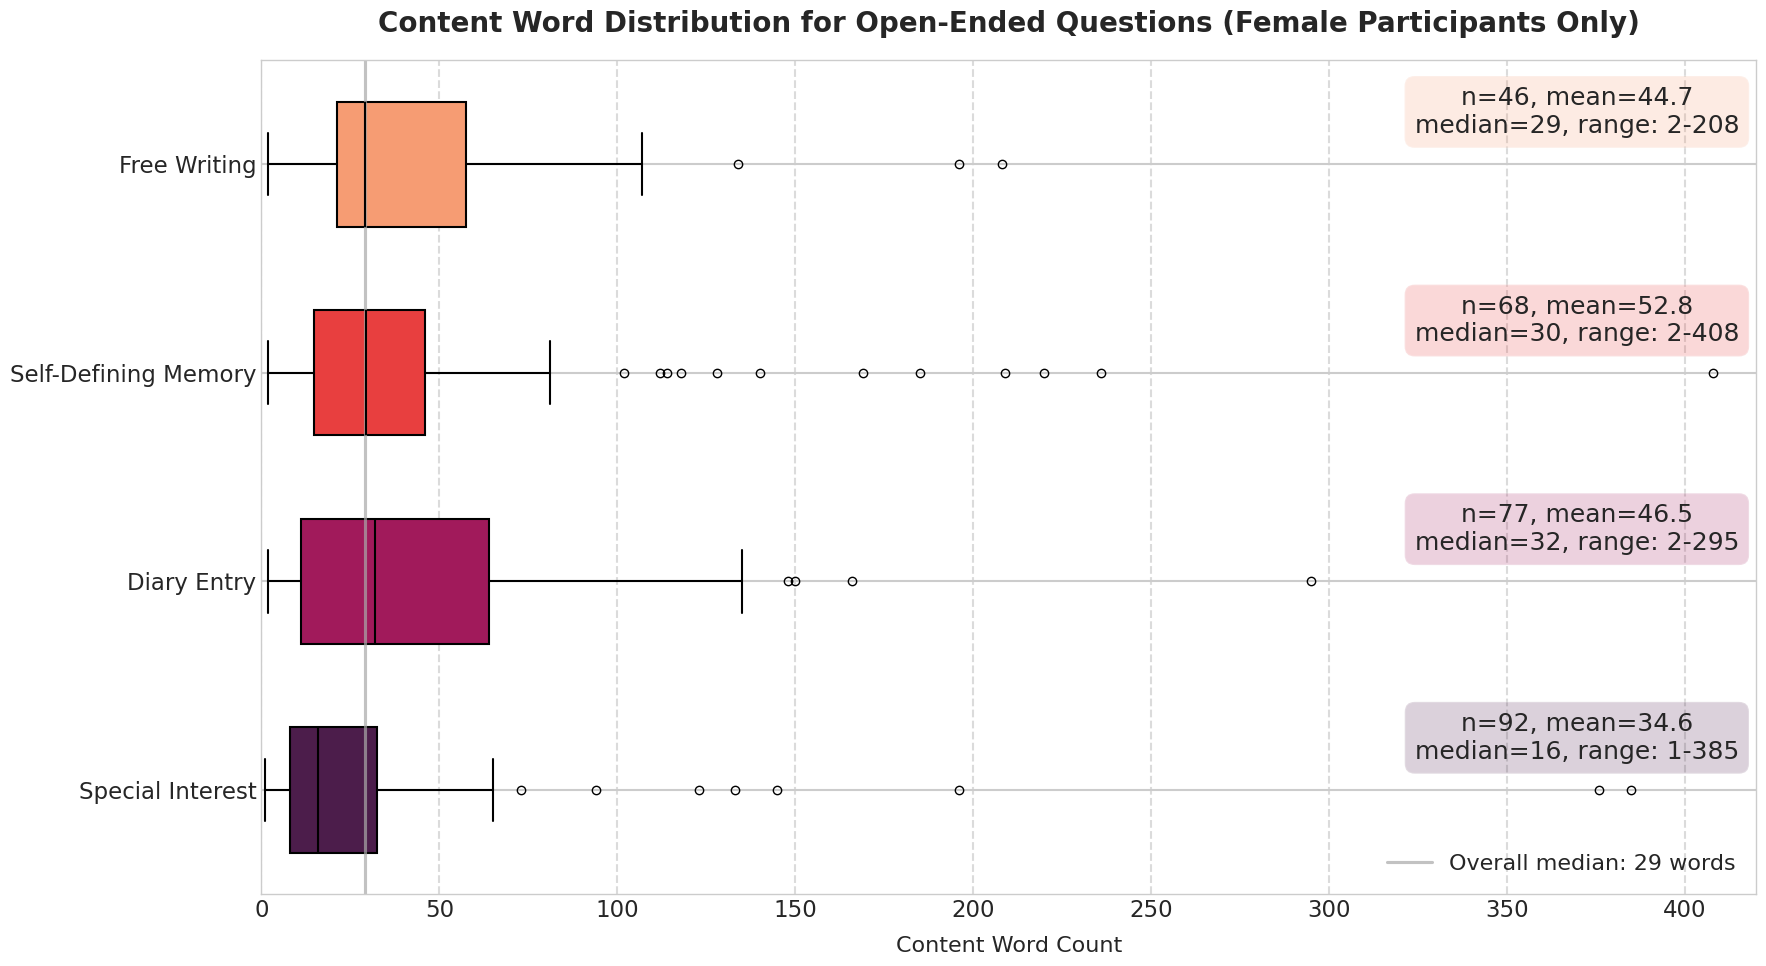

In [33]:
# Create a figure with more appropriate dimensions for ADHD diagnosis only
fig, ax = plt.subplots(figsize=(18, 10))

# Filter data to include only ADHD diagnosed participants
adhd_df = word_count_df[df["sex"] == "Female"]

# Explicitly define the order of columns to be displayed
question_order = [
    "special_interest",
    "diary_entry",
    "selfdefining_memory",
    "empty_sheet",
]
column_order = [col + "_word_count" for col in question_order]

# Get question descriptions in the right order
descriptive_names = [column_descriptive_names[col] for col in question_order]

# Prepare data for the boxplot, filtering out zero values (empty responses)
boxplot_data = []
for col in column_order:
    # Filter out zeros (empty texts)
    filtered_data = adhd_df[adhd_df[col] > 0][col]
    boxplot_data.append(filtered_data)

# Calculate statistics for each text type
stats = {}
for i, (col, name) in enumerate(zip(question_order, descriptive_names)):
    filtered_data = adhd_df[adhd_df[f"{col}_word_count"] > 0][f"{col}_word_count"]
    stats[name] = {
        "count": len(filtered_data),
        "mean": filtered_data.mean(),
        "median": filtered_data.median(),
        "max": filtered_data.max(),
        "min": filtered_data.min(),
    }

# Create the horizontal boxplot with filtered data
bp = ax.boxplot(
    boxplot_data, vert=False, patch_artist=True, labels=descriptive_names, widths=0.6
)

# Customize boxplot colors using rocket color palette
for i, box in enumerate(bp["boxes"]):
    box.set(color="black", linewidth=1.5)
    box.set(facecolor=sns.color_palette("rocket", 4)[i])

for element in ["whiskers", "caps", "medians"]:
    for item in bp[element]:
        item.set(color="black", linewidth=1.5)

# Add a grid for better readability
ax.grid(axis="x", linestyle="--", alpha=0.7)

# Set title and labels with better formatting
ax.set_title(
    "Content Word Distribution for Open-Ended Questions (Female Participants Only)",
    fontsize=20,
    fontweight="bold",
    pad=20,
)
ax.set_xlabel("Content Word Count", fontsize=16, labelpad=10)
ax.set_ylabel("", fontsize=16, labelpad=10)

# Add annotations with statistics
for i, (name, stat) in enumerate(stats.items()):
    y_pos = i + 1
    # Create the annotation text with key statistics
    annotation = f"n={stat['count']}, mean={stat['mean']:.1f}\nmedian={stat['median']:.0f}, range: {stat['min']}-{stat['max']}"

    # Position the annotation at the right end of the plot
    ax.annotate(
        annotation,
        xy=(
            ax.get_xlim()[1] * 0.863,
            y_pos + 0.25,
        ),  # Adjusted x position for better visibility
        xytext=(0, 0),
        textcoords="offset points",
        ha="center",
        va="center",
        fontsize=18,
        bbox=dict(
            boxstyle="round,pad=0.4", fc=sns.color_palette("rocket", 4)[i], alpha=0.2
        ),
    )

# Add a horizontal reference line for the median value across all responses
median_val = np.median([stats[name]["median"] for name in descriptive_names])
ax.axvline(
    median_val,
    color="darkgray",
    linestyle="-",
    alpha=0.7,
    label=f"Overall median: {median_val:.0f} words",
)

# Set x-axis limit to 1000
ax.set_xlim(0, 420)

# Add legend
ax.legend(loc="lower right", fontsize=16)

# Save and display plot
plt.tight_layout()
plt.savefig(
    "data/content_word_distribution_female_only.png", dpi=300, bbox_inches="tight"
)
plt.show()

/tmp/ipykernel_24475/3632370784.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


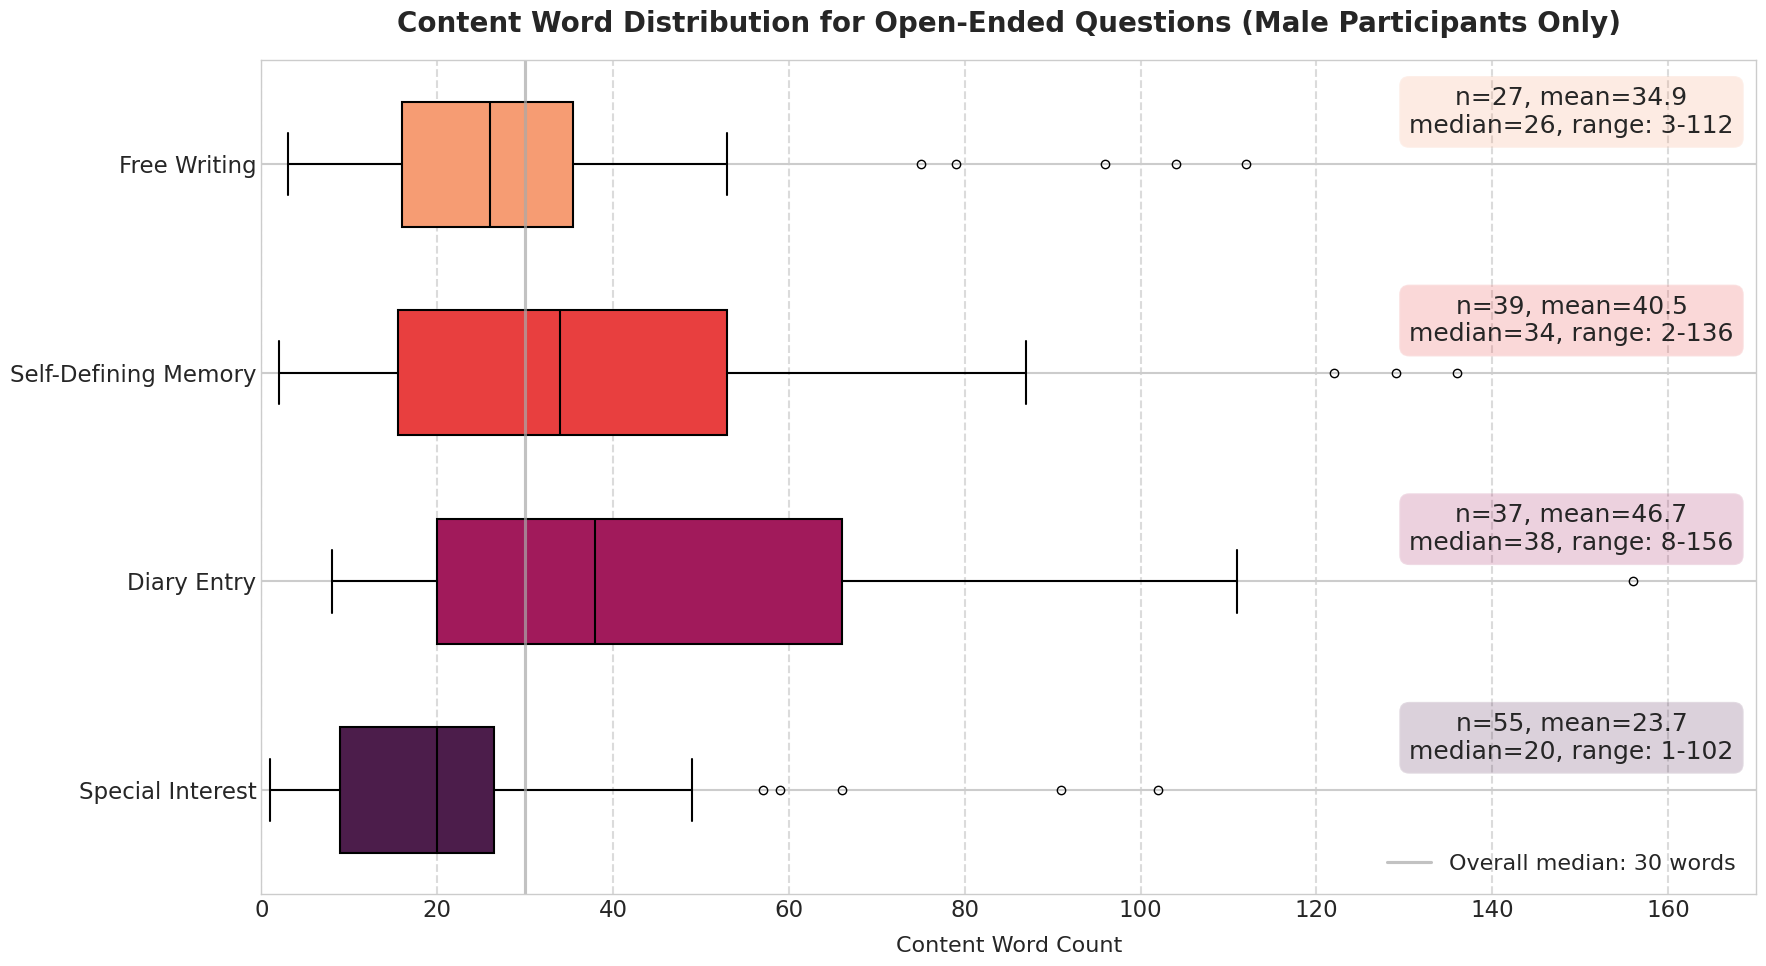

In [34]:
# Create a figure with more appropriate dimensions for ADHD diagnosis only
fig, ax = plt.subplots(figsize=(18, 10))

# Filter data to include only ADHD diagnosed participants
adhd_df = word_count_df[df["sex"] == "Male"]

# Explicitly define the order of columns to be displayed
question_order = [
    "special_interest",
    "diary_entry",
    "selfdefining_memory",
    "empty_sheet",
]
column_order = [col + "_word_count" for col in question_order]

# Get question descriptions in the right order
descriptive_names = [column_descriptive_names[col] for col in question_order]

# Prepare data for the boxplot, filtering out zero values (empty responses)
boxplot_data = []
for col in column_order:
    # Filter out zeros (empty texts)
    filtered_data = adhd_df[adhd_df[col] > 0][col]
    boxplot_data.append(filtered_data)

# Calculate statistics for each text type
stats = {}
for i, (col, name) in enumerate(zip(question_order, descriptive_names)):
    filtered_data = adhd_df[adhd_df[f"{col}_word_count"] > 0][f"{col}_word_count"]
    stats[name] = {
        "count": len(filtered_data),
        "mean": filtered_data.mean(),
        "median": filtered_data.median(),
        "max": filtered_data.max(),
        "min": filtered_data.min(),
    }

# Create the horizontal boxplot with filtered data
bp = ax.boxplot(
    boxplot_data, vert=False, patch_artist=True, labels=descriptive_names, widths=0.6
)

# Customize boxplot colors using rocket color palette
for i, box in enumerate(bp["boxes"]):
    box.set(color="black", linewidth=1.5)
    box.set(facecolor=sns.color_palette("rocket", 4)[i])

for element in ["whiskers", "caps", "medians"]:
    for item in bp[element]:
        item.set(color="black", linewidth=1.5)

# Add a grid for better readability
ax.grid(axis="x", linestyle="--", alpha=0.7)

# Set title and labels with better formatting
ax.set_title(
    "Content Word Distribution for Open-Ended Questions (Male Participants Only)",
    fontsize=20,
    fontweight="bold",
    pad=20,
)
ax.set_xlabel("Content Word Count", fontsize=16, labelpad=10)
ax.set_ylabel("", fontsize=16, labelpad=10)

# Add annotations with statistics
for i, (name, stat) in enumerate(stats.items()):
    y_pos = i + 1
    # Create the annotation text with key statistics
    annotation = f"n={stat['count']}, mean={stat['mean']:.1f}\nmedian={stat['median']:.0f}, range: {stat['min']}-{stat['max']}"

    # Position the annotation at the right end of the plot
    ax.annotate(
        annotation,
        xy=(
            ax.get_xlim()[1] * 0.91,
            y_pos + 0.25,
        ),  # Adjusted x position for better visibility
        xytext=(0, 0),
        textcoords="offset points",
        ha="center",
        va="center",
        fontsize=18,
        bbox=dict(
            boxstyle="round,pad=0.4", fc=sns.color_palette("rocket", 4)[i], alpha=0.2
        ),
    )

# Add a horizontal reference line for the median value across all responses
median_val = np.median([stats[name]["median"] for name in descriptive_names])
ax.axvline(
    median_val,
    color="darkgray",
    linestyle="-",
    alpha=0.7,
    label=f"Overall median: {median_val:.0f} words",
)

# Set x-axis limit to 1000
ax.set_xlim(0, 170)

# Add legend
ax.legend(loc="lower right", fontsize=16)

# Save and display plot
plt.tight_layout()
plt.savefig("data/content_word_distribution_male_only.png", dpi=300, bbox_inches="tight")
plt.show()

### Most Significant Terms

In [35]:
word_count_df = df[
    ["special_interest", "diary_entry", "selfdefining_memory", "empty_sheet"]
].copy()

nlp = spacy.load("pt_core_news_lg")


word_count_df["special_interest_word_count"] = word_count_df["special_interest"].apply(
    count_words
)
word_count_df["diary_entry_word_count"] = word_count_df["diary_entry"].apply(
    count_words
)
word_count_df["selfdefining_memory_word_count"] = word_count_df[
    "selfdefining_memory"
].apply(count_words)
word_count_df["empty_sheet_word_count"] = word_count_df["empty_sheet"].apply(
    count_words
)

In [36]:
# Download Portuguese stopwords (only once)
nltk.download("stopwords", quiet=True)

# Load Portuguese stopwords
portuguese_stopwords = stopwords.words("portuguese")
additional_stopwords = [
    "pra",
    "pro",
    "tá",
    "já",
    "ter",
    "vai",
    "vou",
    "então",
    "assim",
    "aí",
    "sobre"
]
portuguese_stopwords.extend(additional_stopwords)

# Filter to include only entries with text content
mask = (
    (word_count_df["special_interest_word_count"] > 0)
    | (word_count_df["diary_entry_word_count"] > 0)
    | (word_count_df["selfdefining_memory_word_count"] > 0)
    | (word_count_df["empty_sheet_word_count"] > 0)
)

filtered_df = df[mask].copy()

# Fill empty entries with empty strings for term processing
text_columns = ["special_interest", "diary_entry", "selfdefining_memory", "empty_sheet"]
terms_df = filtered_df[text_columns].fillna("").replace("NaN", "")
terms_df["combined_text"] = terms_df.agg(" ".join, axis=1).str.strip()
terms_df = terms_df[terms_df["combined_text"] != ""]
print(terms_df.shape)

vectorizer = CountVectorizer(
    max_df=1.0,  # Include all terms
    min_df=0.0,  # Include all terms
    stop_words=portuguese_stopwords,
    ngram_range=(1, 3),  # Consider both unigrams and bigrams
    max_features=2000,  # Limit vocabulary size
)

# Create the term matrix
term_matrix = vectorizer.fit_transform(terms_df["combined_text"])
total_elements = term_matrix.shape[0] * term_matrix.shape[1]
nonzero_elements = term_matrix.count_nonzero()
sparsity = 100 * (1 - (nonzero_elements / total_elements))

# Print summary statistics with better formatting
print("📊 Count-Vectorizer Analysis Summary:")
print(
    f"➡️ Documents with text: {terms_df.shape[0]} out of {df.shape[0]} ({terms_df.shape[0] / df.shape[0] * 100:.1f}%)"
)
print(f"➡️ Matrix shape: {term_matrix.shape[0]}×{term_matrix.shape[1]}")
print(f"➡️ Vocabulary size: {len(vectorizer.get_feature_names_out())}")
print(f"➡️ Sparsity: {sparsity:.2f}% (mostly empty)")

# Get the most important terms (highest TF-IDF scores)
feature_names = vectorizer.get_feature_names_out()
# Sum counts for each term across all documents
terms_sum = np.asarray(term_matrix.sum(axis=0)).flatten()
# Get indices of top terms
top_n = 20  # Show top 20 terms
top_indices = terms_sum.argsort()[-top_n:][::-1]
top_terms = [feature_names[i] for i in top_indices]
top_scores = terms_sum[top_indices]

display_labels = []
for pt in top_terms:
    try:
        # translate one term using deep_translator
        en = GoogleTranslator(source='pt', target='en').translate(pt)
    except Exception:
        # if anything goes wrong, fall back to the Portuguese itself
        en = pt
    display_labels.append(f"{en} ({pt})")

# Separate by source type (optional)
source_scores = {}
for col in text_columns:
    # Only use non-empty entries for this column
    col_data = filtered_df[filtered_df[col].notna()][col].tolist()
    if col_data:
        col_vectorizer = CountVectorizer(vocabulary=vectorizer.vocabulary_)
        col_matrix = col_vectorizer.fit_transform(col_data)
        col_sum = np.asarray(col_matrix.sum(axis=0)).flatten()
        source_scores[column_descriptive_names[col]] = {
            feature_names[i]: col_sum[i] for i in top_indices
        }
        
source_scores_table = pd.DataFrame({
    source: [source_scores[source].get(term, 0) for term in top_terms]
    for source in source_scores
}, index=top_terms)

# Add translated labels for readability
source_scores_table.index = display_labels

# Prepare DataFrame for top 20 terms: columns = source types + 'Overall', rows = top_terms
overall_scores = {feature_names[i]: terms_sum[i] for i in top_indices}

# Build the table
score_table = pd.DataFrame({
    'Overall': [overall_scores.get(term, 0) for term in top_terms],
    **{source: [source_scores[source].get(term, 0) for term in top_terms] for source in source_scores}
}, index=display_labels)

# Display the table
display(score_table.style.format("{:.2f}").set_caption("Top 20 Most Frequent Terms in the Dataset by Source and Overall Count"))


(160, 5)
📊 Count-Vectorizer Analysis Summary:
➡️ Documents with text: 160 out of 332 (48.2%)
➡️ Matrix shape: 160×2000
➡️ Vocabulary size: 2000
➡️ Sparsity: 96.47% (mostly empty)


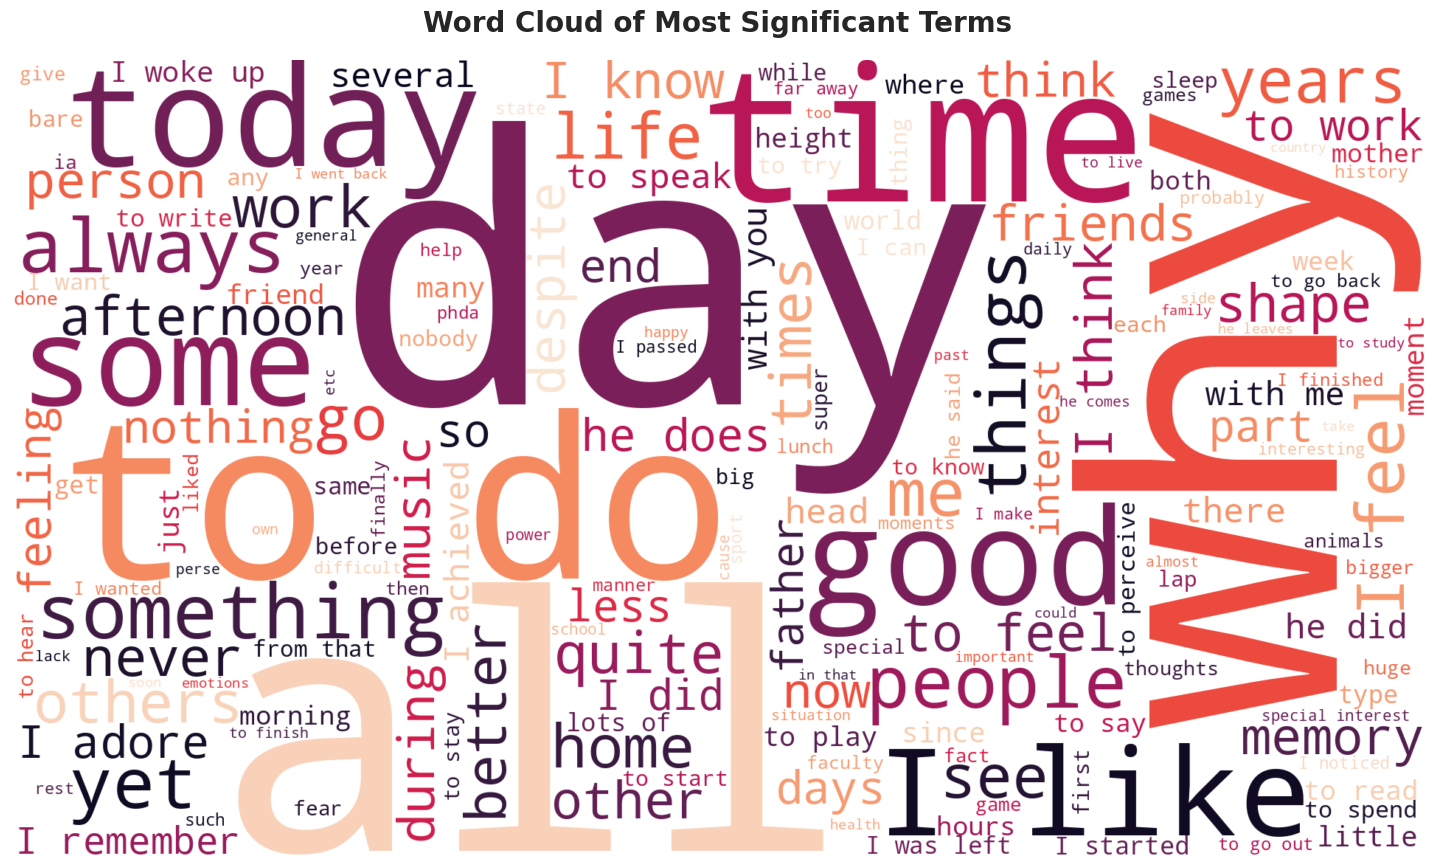

In [37]:
# Get top 200 terms and their scores
top200_indices = terms_sum.argsort()[-200:][::-1]
word_freq = {feature_names[i]: terms_sum[i] for i in top200_indices}

pt_terms = list(word_freq.keys())
english_terms = GoogleTranslator(source='pt', target='en').translate_batch(pt_terms)

en_freq = {}
for pt, en in zip(pt_terms, english_terms):
    en_freq[en] = en_freq.get(en, 0) + word_freq[pt]

# Generate and display the word cloud
plt.figure(figsize=(16, 9))
wc = WordCloud(
    width=1920,
    height=1080,
    background_color="white",
    colormap="rocket",
    max_words=200,
    contour_width=1,
    contour_color="steelblue",
).generate_from_frequencies(en_freq)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title(
    "Word Cloud of Most Significant Terms", fontsize=20, fontweight="bold", pad=20
)
plt.tight_layout()
plt.savefig("data/tfidf_wordcloud.png", dpi=300, bbox_inches="tight")
plt.show()

[135, 136, 187, 189, 194, 205, 229, 235, 250, 253, 254, 260, 264, 268, 273, 276, 288, 292, 293, 296, 297, 307, 322]
[1, 3, 6, 8, 14, 15, 17, 19, 21, 22, 27, 29, 30, 31, 32, 36, 37, 38, 41, 44, 45, 46, 49, 50, 51, 55, 61, 64, 65, 67, 70, 71, 73, 74, 76, 81, 82, 84, 85, 86, 87, 88, 92, 98, 101, 102, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 117, 119, 120, 121, 122, 124, 125, 128, 130, 132, 134, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 149, 150, 151, 153, 154, 155, 157, 158, 159, 160, 163, 168, 169, 170, 171, 172, 182, 183, 186, 188, 190, 195, 196, 197, 199, 202, 204, 212, 214, 220, 221, 222, 223, 227, 228, 230, 231, 234, 240, 243, 247, 248, 258, 265, 266, 272, 275, 278, 281, 285, 294, 303, 306, 308, 311, 312, 314, 315, 329, 331]


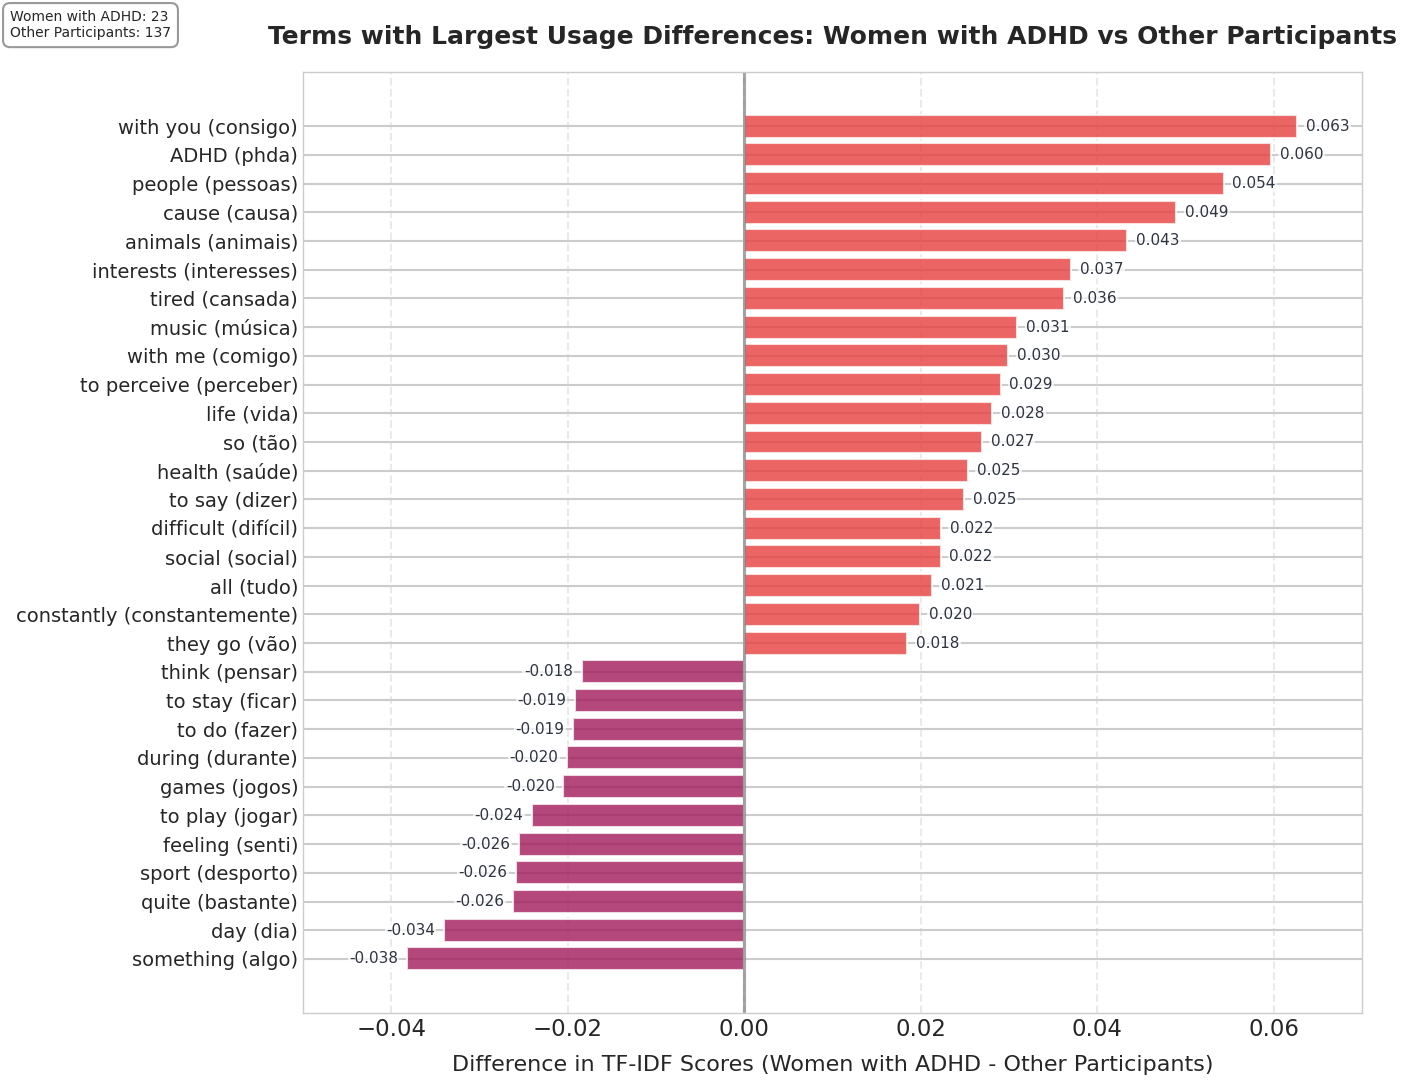

In [38]:
# Create separate TF-IDF matrices for women with ADHD vs everyone else
women_adhd_indices = df[
    (df["adhd_diagnosis"] == "Diagnosed with ADHD") & (df["sex"] == "Female")
].index
women_adhd_indices = [i for i in women_adhd_indices if i in terms_df.index]
print(women_adhd_indices)

others_indices = df.index.difference(women_adhd_indices)
others_indices = [i for i in others_indices if i in terms_df.index]
print(others_indices)

# Calculate term frequency differences between groups
if len(women_adhd_indices) > 0 and len(others_indices) > 0:
    women_adhd_texts = terms_df.loc[women_adhd_indices, "combined_text"]
    others_texts = terms_df.loc[others_indices, "combined_text"]

    # Create new vectorizer to ensure consistent vocabulary
    comparison_vectorizer = TfidfVectorizer(
        max_df=1.0,
        min_df=7,
        stop_words=portuguese_stopwords,
        ngram_range=(1, 3),
        max_features=2000,
    )

    # Fit on all texts to get a common vocabulary
    comparison_vectorizer.fit(terms_df["combined_text"])

    # Transform each group separately
    women_adhd_tfidf = comparison_vectorizer.transform(women_adhd_texts)
    others_tfidf = comparison_vectorizer.transform(others_texts)

    # Calculate average TF-IDF scores for each term in each group
    women_adhd_avg = np.asarray(women_adhd_tfidf.mean(axis=0)).flatten()
    others_avg = np.asarray(others_tfidf.mean(axis=0)).flatten()

    # Calculate difference in average scores
    diff_scores = women_adhd_avg - others_avg
    abs_diff_scores = np.abs(diff_scores)

    # Get the terms with the biggest absolute differences
    feature_names = comparison_vectorizer.get_feature_names_out()
    sorted_indices = np.argsort(abs_diff_scores)[
        -30:
    ]  # Get top 30 terms with biggest differences

    # Sort them by actual difference (not absolute) to see which group uses which terms more
    sorted_indices = sorted_indices[np.argsort(diff_scores[sorted_indices])]

    diff_terms = [feature_names[i] for i in sorted_indices]
    women_adhd_scores = women_adhd_avg[sorted_indices]
    others_scores = others_avg[sorted_indices]
      
    raw_english_terms  = GoogleTranslator(source='pt', target='en') \
                    .translate_batch(diff_terms)

    override = {
        'phda': 'ADHD',
    }

    english_terms = [
        override.get(pt.lower(), en)   # use override if pt matches (case-insensitive)
        for pt, en in zip(diff_terms, raw_english_terms)
    ]
          
    display_labels = [
        f"{en} ({pt})"
        for pt, en in zip(diff_terms, english_terms)
    ]
    
    # Create a horizontal bar chart for better readability of terms
    plt.figure(figsize=(14, 12))
    plt.xlim(-0.05, 0.07)

    # Plot the differences directly
    palette = sns.color_palette("rocket", 4)

    differences = women_adhd_scores - others_scores
    colors = [palette[1] if d < 0 else palette[2] for d in differences]

    # Create horizontal bars showing the difference
    bars = plt.barh(range(len(diff_terms)), differences, color=colors, alpha=0.8)

    # Add a vertical line at x=0 to show the boundary between ADHD-favored and non-ADHD-favored terms
    plt.axvline(x=0, color="gray", linestyle="-", alpha=0.7)

    # Add labels showing the actual values for each group
    for i, (adhd, other) in enumerate(zip(women_adhd_scores, others_scores)):
        diff = differences[i]

        if diff > 0:  # Term is more frequent in women with ADHD
            # ADHD score at end of its bar (right)
            plt.text(
                diff + 0.001,
                i,
                f"{diff:.3f}",
                va="center",
                ha="left",
                fontsize=11,
                color="#2e3440",
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1),
            )

        else:  # Term is more frequent in others
            # Others score at end of its bar (left)
            plt.text(
                diff - 0.001,
                i,
                f"{diff:.3f}",
                va="center",
                ha="right",
                fontsize=11,
                color="#2e3440",
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1),
            )

    # Customize the y-axis with more readable term labels
    plt.yticks(range(len(diff_terms)), display_labels, fontsize=14)

    # Add labels and title
    plt.xlabel(
        "Difference in TF-IDF Scores (Women with ADHD - Other Participants)",
        fontsize=16,
        labelpad=10,
    )
    plt.title(
        "Terms with Largest Usage Differences: Women with ADHD vs Other Participants",
        fontsize=18,
        fontweight="bold",
        pad=20,
    )

    # Add sample counts
    plt.figtext(
        0.015,
        0.95,
        f"Women with ADHD: {len(women_adhd_indices)}\n"
        f"Other Participants: {len(others_indices)}",
        fontsize=10,
        ha="left",
        va="top",
        bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
    )

    # Add grid for better readability
    plt.grid(axis="x", linestyle="--", alpha=0.4)

    # Adjust layout and save
    plt.tight_layout(rect=[0, 0.04, 1, 0.96])
    plt.savefig(
        "data/women_adhd_others_term_comparison.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

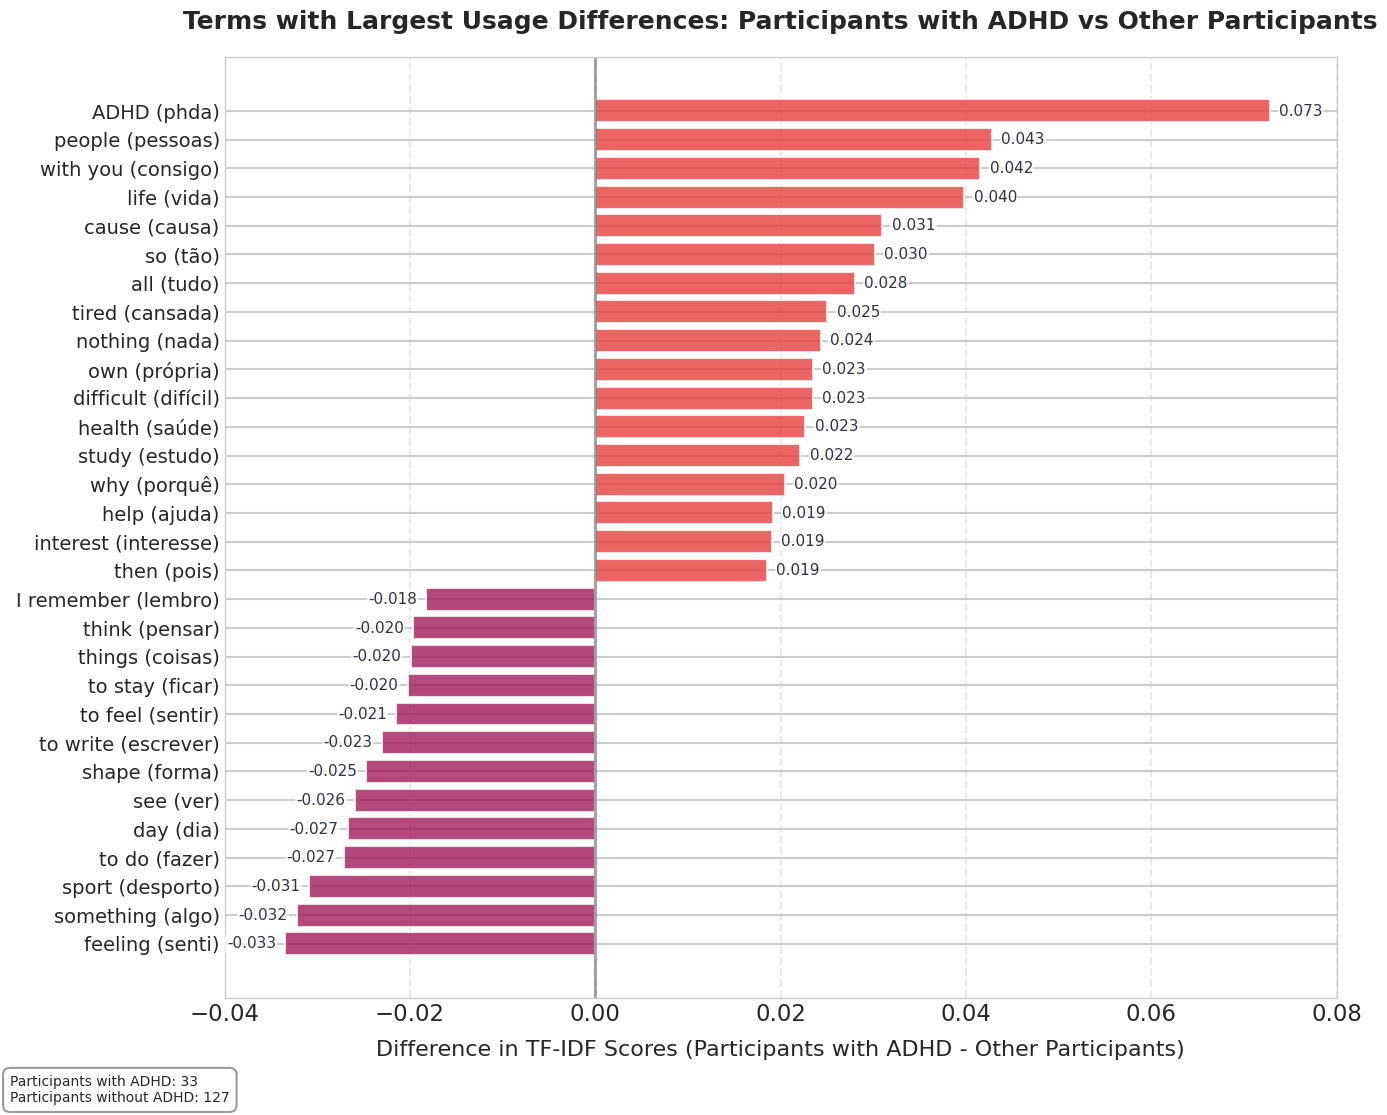

In [39]:
# Create separate TF-IDF matrices for women with ADHD vs everyone else
adhd_indices = df[
    (df["adhd_diagnosis"] == "Diagnosed with ADHD")
].index
adhd_indices = [i for i in adhd_indices if i in terms_df.index]
others_indices = df.index.difference(adhd_indices)
others_indices = [i for i in others_indices if i in terms_df.index]

# Calculate term frequency differences between groups
if len(adhd_indices) > 0 and len(others_indices) > 0:
    women_adhd_texts = terms_df.loc[adhd_indices, "combined_text"]
    others_texts = terms_df.loc[others_indices, "combined_text"]

    # Create new vectorizer to ensure consistent vocabulary
    comparison_vectorizer = TfidfVectorizer(
        max_df=1.0,
        min_df=10,
        stop_words=portuguese_stopwords,
        ngram_range=(1, 3),
        max_features=2000,
    )

    # Fit on all texts to get a common vocabulary
    comparison_vectorizer.fit(terms_df["combined_text"])

    # Transform each group separately
    women_adhd_tfidf = comparison_vectorizer.transform(women_adhd_texts)
    others_tfidf = comparison_vectorizer.transform(others_texts)

    # Calculate average TF-IDF scores for each term in each group
    women_adhd_avg = np.asarray(women_adhd_tfidf.mean(axis=0)).flatten()
    others_avg = np.asarray(others_tfidf.mean(axis=0)).flatten()

    # Calculate difference in average scores
    diff_scores = women_adhd_avg - others_avg
    abs_diff_scores = np.abs(diff_scores)

    # Get the terms with the biggest absolute differences
    feature_names = comparison_vectorizer.get_feature_names_out()
    sorted_indices = np.argsort(abs_diff_scores)[
        -30:
    ]  # Get top 30 terms with biggest differences

    # Sort them by actual difference (not absolute) to see which group uses which terms more
    sorted_indices = sorted_indices[np.argsort(diff_scores[sorted_indices])]

    diff_terms = [feature_names[i] for i in sorted_indices]
    women_adhd_scores = women_adhd_avg[sorted_indices]
    others_scores = others_avg[sorted_indices]
      
    raw_english_terms  = GoogleTranslator(source='pt', target='en') \
                    .translate_batch(diff_terms)

    override = {
        'phda': 'ADHD',
    }

    english_terms = [
        override.get(pt.lower(), en)   # use override if pt matches (case-insensitive)
        for pt, en in zip(diff_terms, raw_english_terms)
    ]
          
    display_labels = [
        f"{en} ({pt})"
        for pt, en in zip(diff_terms, english_terms)
    ]
    
    # Create a horizontal bar chart for better readability of terms
    plt.figure(figsize=(14, 12))
    plt.xlim(-0.04, 0.08)

    # Plot the differences directly
    palette = sns.color_palette("rocket", 4)

    differences = women_adhd_scores - others_scores
    colors = [palette[1] if d < 0 else palette[2] for d in differences]

    # Create horizontal bars showing the difference
    bars = plt.barh(range(len(diff_terms)), differences, color=colors, alpha=0.8)

    # Add a vertical line at x=0 to show the boundary between ADHD-favored and non-ADHD-favored terms
    plt.axvline(x=0, color="gray", linestyle="-", alpha=0.7)

    # Add labels showing the actual values for each group
    for i, (adhd, other) in enumerate(zip(women_adhd_scores, others_scores)):
        diff = differences[i]

        if diff > 0:  # Term is more frequent in women with ADHD
            # ADHD score at end of its bar (right)
            plt.text(
                diff + 0.001,
                i,
                f"{diff:.3f}",
                va="center",
                ha="left",
                fontsize=11,
                color="#2e3440",
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1),
            )

        else:  # Term is more frequent in others
            # Others score at end of its bar (left)
            plt.text(
                diff - 0.001,
                i,
                f"{diff:.3f}",
                va="center",
                ha="right",
                fontsize=11,
                color="#2e3440",
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1),
            )

    # Customize the y-axis with more readable term labels
    plt.yticks(range(len(diff_terms)), display_labels, fontsize=14)

    # Add labels and title
    plt.xlabel(
        "Difference in TF-IDF Scores (Participants with ADHD - Other Participants)",
        fontsize=16,
        labelpad=10,
    )
    plt.title(
        "Terms with Largest Usage Differences: Participants with ADHD vs Other Participants",
        fontsize=18,
        fontweight="bold",
        pad=20,
    )

    # Add sample counts
    plt.figtext(
        0.015,
        0.05,
        f"Participants with ADHD: {len(adhd_indices)}\n"
        f"Participants without ADHD: {len(others_indices)}",
        fontsize=10,
        ha="left",
        va="top",
        bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
    )

    # Add grid for better readability
    plt.grid(axis="x", linestyle="--", alpha=0.4)

    # Adjust layout and save
    plt.tight_layout(rect=[0, 0.04, 1, 0.96])
    plt.savefig(
        "data/adhd_others_term_comparison.png", dpi=300, bbox_inches="tight"
    )
    plt.show()